# 1. Introduction
Climate change has emerged as one of the most pressing challenges of the 21st century, with its effects becoming increasingly evident worldwide. Among the numerous consequences of climate change, the intensification of heatwaves stands out as a significant threat to both human well-being and environmental stability. In recent years, regions such as the Mediterranean have experienced a notable increase in the frequency and severity of heatwaves, posing serious risks to local populations and ecosystems.

This growing concern about heatwaves has sparked a global conversation, especially in cities and regions less accustomed to extreme temperatures. The project analyzes four countries across different climate zones to compare temperatures and predict especially hot days. It examines how adaptable these cities and their residents are to heatwaves. By analyzing the volume and sentiment of tweets about heatwaves in each country, the study seeks to understand public attitudes towards this weather phenomenon. This analysis can inform how countries should approach and respond to heatwaves, encouraging cities to take proactive measures to support their populations. Ultimately, the research uncovers trends in temperature increases and public perception, fostering greater awareness of and readiness for heatwaves worldwide.

Recognizing the urgency of mitigating these impacts, the project aims to develop a comprehensive understanding of the dynamics of heatwaves, focusing on four key cities: Madrid, New York, Copenhagen, and Islamabad. Through an approach combining predictive modeling and sentiment analysis of public discourse on social media and news platforms, the study sheds light on the complex effects of heatwaves on the general population of the regions.

The report consists of different sections. First, the methodology for gathering the weather data is explained. Afterwards, the heatwave identifier is presented to detect heatwaves in the data.

# 2. Weather Data

Moreover, the weather data used in this study is sourced from Open-Meteo, which provides a freely accessible API for non-commercial use. This API was used to acquire the necessary data for the analysis. The key features selected for this study include the date, daily minimum, mean, and maximum temperatures, precipitation levels, and wind speed.

In [7]:
import requests

def weather_data_daily(latitude,longitude,start_date,end_date):
    
    url_base = "https://archive-api.open-meteo.com/v1/archive"
    params = ["latitude="+str(latitude) , "longitude="+str(longitude) ,"start_date="+start_date ,"end_date="+end_date ,"daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,windspeed_10m_max","timezone=auto"]
    
    request_url = url_base + "?" + "&".join(params)

    response = requests.get(request_url)
    data = response.json()

    df_columns = []
    df_data = []
    for keys in data["daily"]:
        df_columns.append(keys)
    for column in df_columns:
        df_data.append(data["daily"][column])

    df = pd.DataFrame(np.transpose(df_data), columns=df_columns)
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")
    df = df.apply(pd.to_numeric)

    return df

In [8]:
#weather_data_daily(40.4168,-3.7038, "2000-01-01","2023-12-31").to_csv('madrid_2000-2023.csv')
#weather_data_daily(55.6761,12.5683, "2000-01-01","2023-12-31").to_csv('Cph_2000-2023.csv')
#weather_data_daily(40.7128,-74.0060, "2000-01-01","2023-12-31").to_csv('NY_2000-2023.csv')
#weather_data_daily(33.6844,73.0479, "2000-01-01","2023-12-31").to_csv('Islamabad_2000-2023.csv')
#weather_data_daily(40.4168,-3.7038, "1971-01-01","2000-12-31").to_csv('madrid_1971-2000.csv')

The datasets are downloaded this way and added in the folder.

In [9]:
madrid_weather = pd.read_csv('madrid_1971-2000.csv')

threshold_madrid = threshold_temp(madrid_weather, 95)

print("The temperature threshold for the city of Madrid is:", threshold_madrid)



The temperature threshold for the city of Madrid is: 36.3


##### *Weather Data upload/cleaning*

This part of the project begins with an exploratory analysis of the data for the four cities: Madrid, New York, Copenhagen, and Islamabad. The main goal of the exploratory analysis is to gain insight into the temperature datasets and how they evolve during the time period 2000-2023.
The data is initially cleaned and converted into the correct settings before further analysis.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb


def cleaning_data(filename):
    df = pd.read_csv(filename)

    df['time'] = pd.to_datetime(df['time'])

    
    columns_to_convert = ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum', 'windspeed_10m_max']

    df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce').round(2)

    df = df.dropna()

    return df


df_madrid = cleaning_data('madrid_2000-2023.csv')
df_copenhagen = cleaning_data('Cph_2000-2023.csv')
df_NY = cleaning_data('NY_2000-2023.csv')
df_islamabad = cleaning_data('Islamabad_2000-2023.csv')


global countries, generic_colors, generic_linestyle, generic_colors_four
countries = ['Madrid', 'Copenhagen', 'New York', 'Islamabad']
generic_colors = ['blue','violet', 'purple', 'red', 'orange', 'black', 'gray', 'hotpink', 'brown',
                  'skyblue', 'darkorange', 'orangered', 'cyan', 'magenta', 'slategray', 'gold',
                  'indigo', 'darkviolet', 'salmon', 'peru', 'mediumslateblue', 'orchid', 'steelblue','dodgerblue']
generic_colors_four = ['blue', 'violet','purple','red'] 
generic_linestyle = ['-', '--', '-.', ':', (5, (10, 3)),'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5)),
                  (0, (1, 1)) , (0, (3, 10, 1, 10))]
generic_markers = ['o', 's', 'v', 'x']

In [11]:
df_madrid.head(20)

time  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0  2000-01-01                10.1                -2.0                  3.1   
1  2000-01-02                 9.7                -2.0                  3.2   
2  2000-01-03                 8.7                -1.8                  2.4   
3  2000-01-04                 8.0                -1.4                  2.4   
4  2000-01-05                 6.2                -1.7                  1.2   
5  2000-01-06                 8.0                -1.5                  2.0   
6  2000-01-07                 9.9                -2.6                  2.6   
7  2000-01-08                 9.0                -2.2                  2.4   
8  2000-01-09                 5.8                -1.0                  1.9   
9  2000-01-10                 7.4                -1.5                  2.1   
10 2000-01-11                 8.2                 0.4                  3.2   
11 2000-01-12                 7.3                -1.2                  2.4   
12 2000-01-13                 6.1                -1.4                  2.3   
13 2000-01-14                 4.5                -0.5                  2.0   
14 2000-01-15                 6.9                -3.0                  1.0   
15 2000-01-16                 7.8                -0.9                  2.8   
16 2000-01-17                 8.7                -1.5                  2.7   
17 2000-01-18                10.2                -1.8                  3.0   
18 2000-01-19                11.7                -2.1                  3.4   
19 2000-01-20                 8.9                -2.2                  2.5   

    precipitation_sum  windspeed_10m_max  
0                 0.0                6.9  
1                 0.0                5.4  
2                 0.0                5.8  
3                 0.0                7.3  
4                 0.0                4.7  
5                 0.0                6.5  
6                 0.0                5.8  
7                 0.0                7.6  
8                 3.6               10.1  
9                 0.0               16.6  
10                0.1               12.2  
11                0.0               10.5  
12                1.3               12.6  
13               19.5                8.0  
14                0.4               14.3  
15                0.0               15.8  
16                0.0                8.9  
17                0.0                6.4  
18                0.0               14.1  
19                0.0               12.1

The table above shows how all datasets for the weather are structured with all variables. All datasets contain identical sets of columns and an equal number of rows, which is why only the dataset for Madrid is visualized.

# 3. Heatwave identifier
Before beginning the analysis, it is necessary to define what a heat wave is. Heat waves are periods of excessively hot weather, typically accompanied by high humidity. They are characterized by temperatures that are significantly above normal for a particular region during a specific time of year. The definition of heat waves can vary not only from country to country but also between cities within the same country.

In this study, two different definitions are used. In the first one, a heat wave is a period of at least 3 consecutive days with the maximum temperatures above a certain threshold. For New York and Copenhagen, this temperature threshold is 32.2°C and 28°C, respectively. For Madrid and Spain in general, another definition is applied. According to the Spanish State Meteorological Agency, a heat wave is considered an episode of at least three consecutive days in which the maximum temperatures are above the 95th percentile of their daily maximum temperature series for the months of July and August of the period 1971-2000. Based on that, the calculated temperature threshold is 36.3°C (function threshold_temp*). Last but not least, for Islamabad no clear definition is stated, but most cities in Pakistan use a temperature threshold of 40°C. Therefore, the definition for heatwaves in Islamabad is 3 consecutive days of 40°C.

Before starting the analysis, functions should be created that can calculate a temperature threshold and identify a heat wave in a dataset.

In [12]:
import numpy as np
import pandas as pd

def heat_wave_detector(df, threshold_temp, consecutive_days_threshold, start_year, end_year):
    
    df['time'] = pd.to_datetime(df['time'])
    df_filtered_years = df[(df['time'].dt.year >= start_year) & (df['time'].dt.year <= end_year)]
    heat_wave_dates = set()
    consecutive_days = 0
    
    for index, row in df_filtered_years.iterrows():
        if row['temperature_2m_max'] >= threshold_temp:
            consecutive_days += 1
        else:
            consecutive_days = 0
            
        if consecutive_days >= consecutive_days_threshold:
            for i in range(1, consecutive_days_threshold + 1):
                idx = index - i
                if idx >= 0: 
                    heat_wave_dates.add(df.iloc[idx]['time'].strftime('%Y-%m-%d'))
    
    return sorted(list(heat_wave_dates))



def threshold_temp(df, percentile):
    
    df_july_august = df[(df['time'].str[5:7] == '07') | (df['time'].str[5:7] == '08')]
    threshold = np.percentile(df_july_august['temperature_2m_max'], percentile)
    
    return threshold



def heat_wave_counter(date_list):
    consecutive_days_count = 1
    consecutive_days_occurrences = 0
    date_list = pd.to_datetime(date_list)
    
    for i in range(1, len(date_list)):
        if date_list[i] - date_list[i-1] == pd.Timedelta(days=1):
            consecutive_days_count += 1
        else:
            if consecutive_days_count > 1:
                consecutive_days_occurrences += 1
            consecutive_days_count = 1
    
    if consecutive_days_count > 1:
        consecutive_days_occurrences += 1
    
    return consecutive_days_occurrences

# 4. Exploratory Analysis Prediction Model
The aim is to visually examine the dataset to identify any trends. The focus is on observing trends in maximum temperatures over the years, as well as trends in minimum temperatures. Additionally, the relationship between mean temperature and both minimum and maximum temperatures is explored.

#### *4.1 Firstly, the maximum temperature for each city is explored*

The analysis explores how the monthly maximum temperature behaves throughout the years.

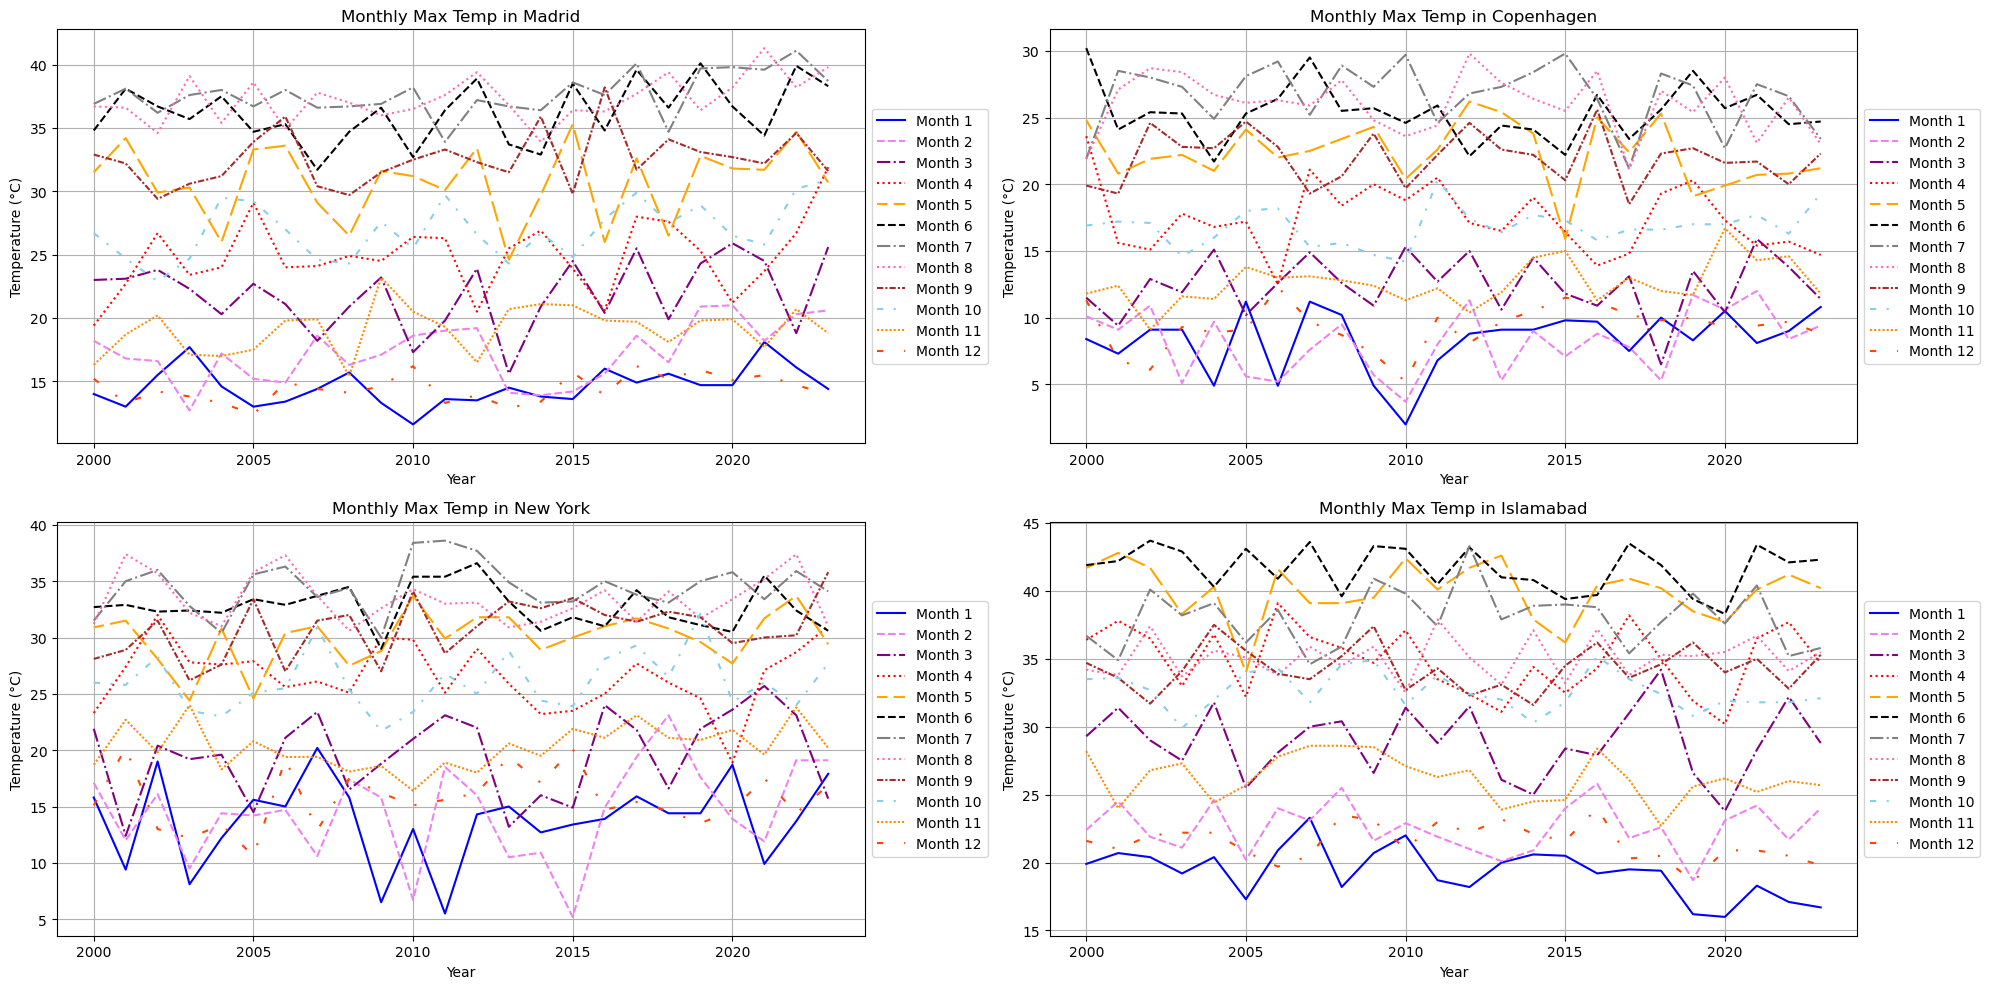

In [13]:
def plot_monthly_max_temp(df1, df2, df3, df4):
    dfs = [df1, df2,df3, df4]
    locations = countries
    colors = generic_colors
    linestyles = generic_linestyle


    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    monthly_avg_max_temp = {}

    for i, (df, location) in enumerate(zip(dfs, locations)):
        row = i // 2
        col = i % 2
        
        df_max_temp = df[['time', 'temperature_2m_max']]
        df_max_temp['month'] = df_max_temp['time'].dt.month
        df_max_temp['year'] = df_max_temp['time'].dt.year

        monthly_max_temp = df_max_temp.groupby(['year', 'month'])['temperature_2m_max'].max().reset_index()
        monthly_max_temp = monthly_max_temp.rename(columns={'temperature_2m_max': f'monthly_max_temp_{location.lower()}'})
        monthly_avg_max_temp[location] = monthly_max_temp

        for month in range(1, 13):
            monthly_data = monthly_max_temp[monthly_max_temp['month'] == month]
            axes[row, col].plot(monthly_data['year'], monthly_data[f'monthly_max_temp_{location.lower()}'], label=f'Month {month}', linestyle =linestyles[month-1], color= colors[month-1])

        axes[row, col].set_title(f'Monthly Max Temp in {location}')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel('Temperature (°C)')
        axes[row, col].legend()
        axes[row, col].grid(True)
        axes[row, col].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


    return monthly_avg_max_temp


monthly_max_temp_data = plot_monthly_max_temp(df_madrid, df_copenhagen, df_NY, df_islamabad)


The above plots show how the maximum temperature of each month in the different cities varies throughout the 24-year time period. Each line corresponds to a month. The maximum temperatures seem to oscillate without creating specific patterns or trends.

Next, the **average max temperature** in each month is examined for every year to determine if any patterns can be detected.

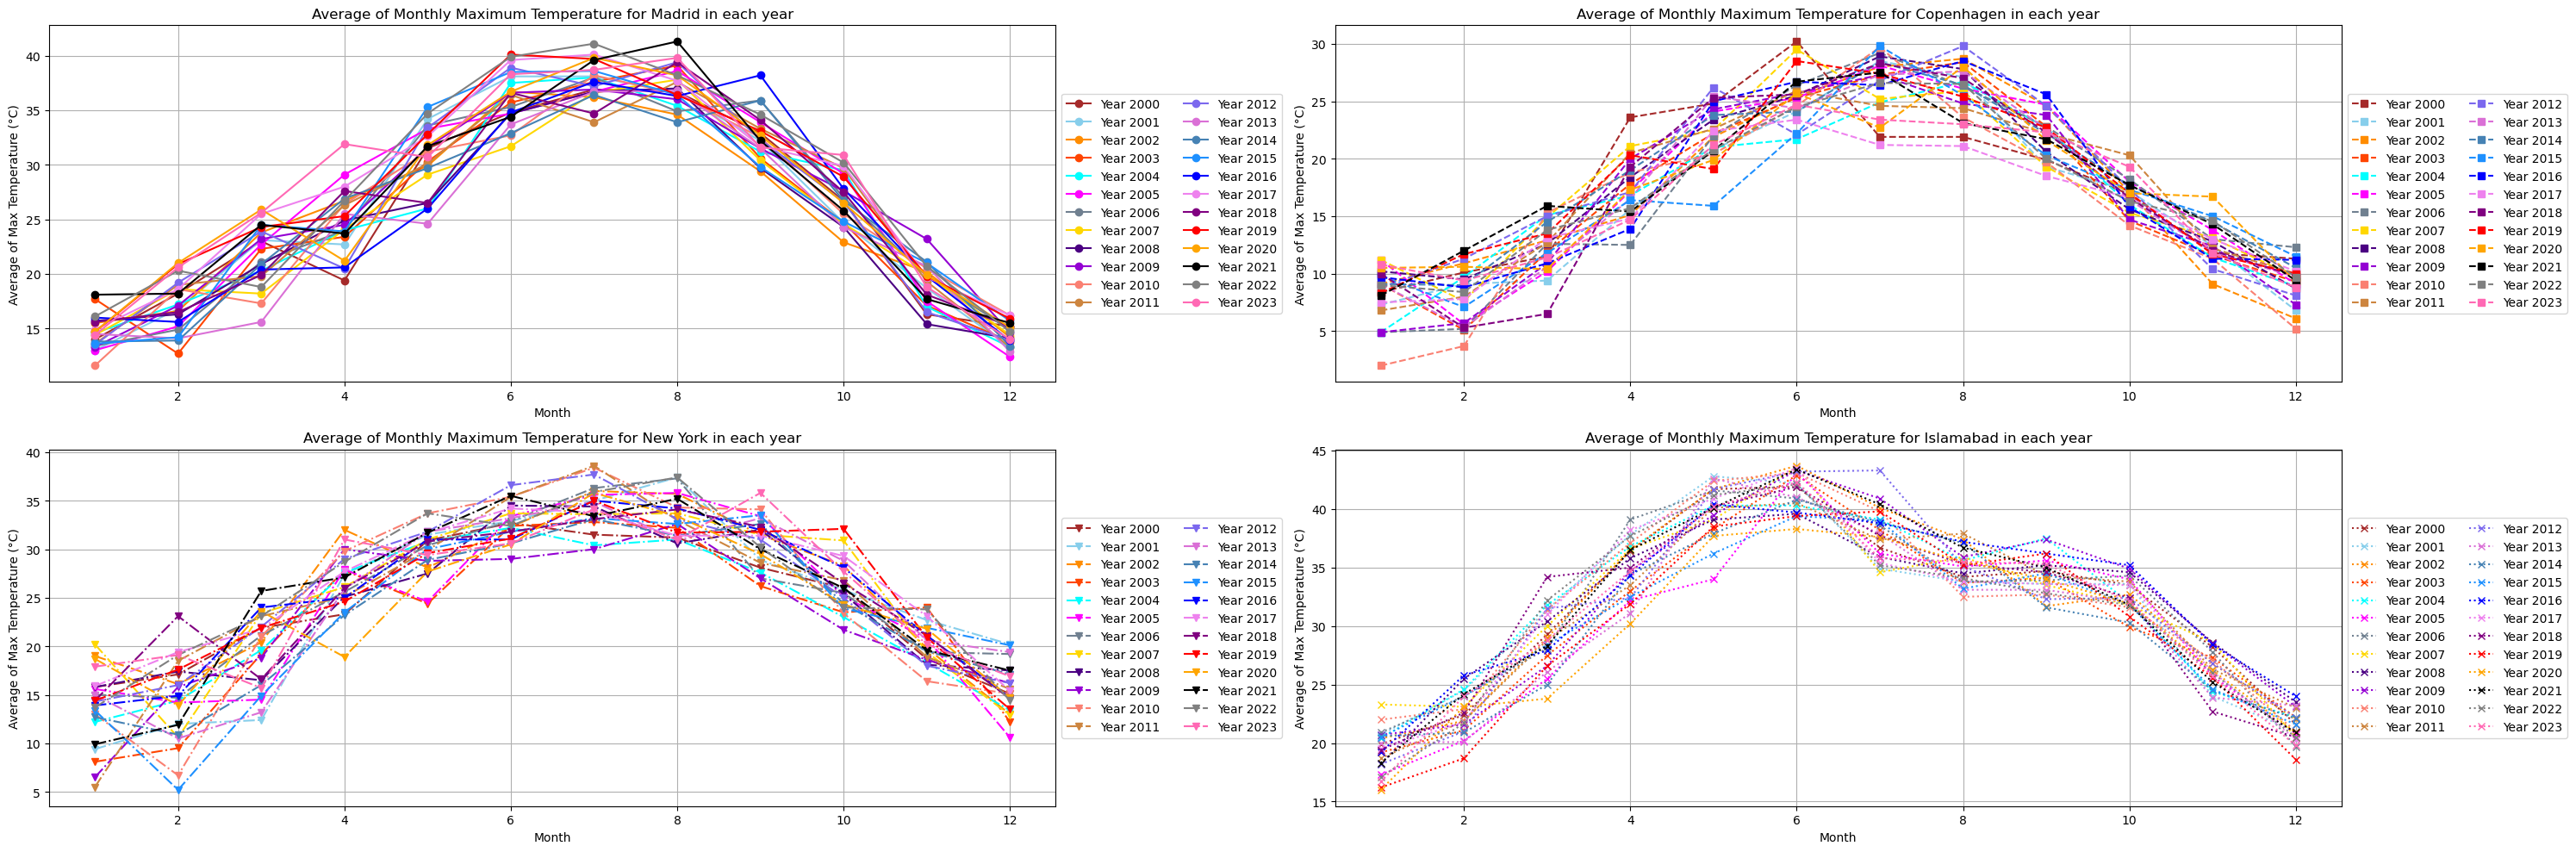

In [14]:
def plot_avg_monthly_max_temp(monthly_max_temp_data):
    linestyles = generic_linestyle
    markers = generic_markers
    colors = generic_colors
    fig, axes = plt.subplots(2, 2, figsize=(30, 10))

    for i, (location, data) in enumerate(monthly_max_temp_data.items()):
        row = i // 2
        col = i % 2

        years = data['year'].unique() 
        monthly_avg_max_temp = data.groupby(['year', 'month'])[f'monthly_max_temp_{location.lower()}'].mean().unstack(level=0) 
        for year in years:
            color_index = year % len(colors)  

            axes[row, col].plot(monthly_avg_max_temp.index, monthly_avg_max_temp[year], label=f'Year {year}', linestyle=linestyles[i], marker=markers[i], color= colors[color_index])

        axes[row, col].set_title(f'Average of Monthly Maximum Temperature for {location} in each year')
        axes[row, col].set_xlabel('Month')
        axes[row, col].set_ylabel('Average of Max Temperature (°C)')
        axes[row, col].grid(True)
        axes[row, col].legend(ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

plot_avg_monthly_max_temp(monthly_max_temp_data)


There is a clear pattern reflecting the overall known pattern of seasons, but no signs indicate that the average maximum temperature is increasing over the time period.

The expectation from this plot was to observe some pattern showing that temperatures in each month increase over the years. A closer look is taken by creating intervals of 5 years to obtain a clearer view of any potential trends.

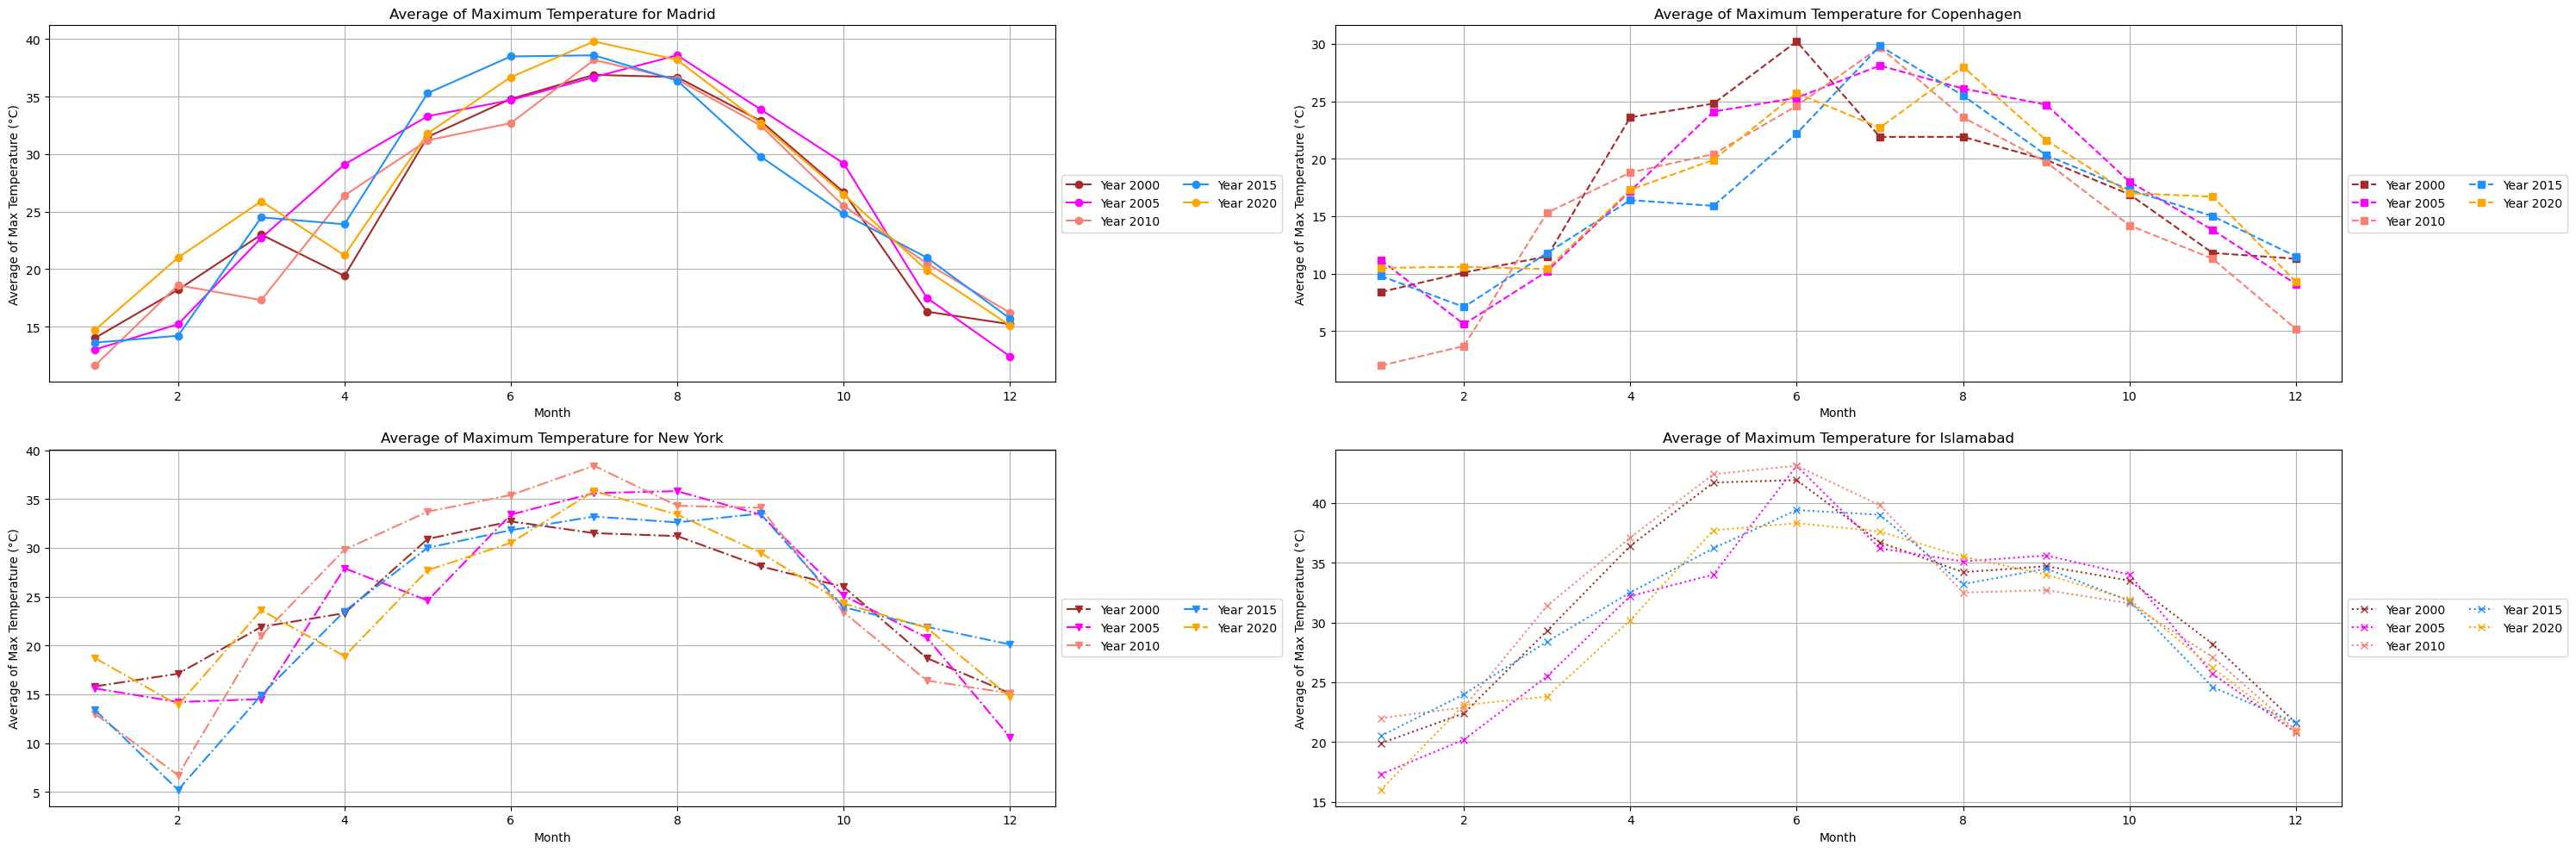

In [15]:
def plot_specific_years(monthly_max_temp_data):
    linestyles = generic_linestyle
    markers = generic_markers
    colors = generic_colors
    fig, axes = plt.subplots(2, 2, figsize=(30, 10))

    specific_years = [2000, 2005, 2010, 2015, 2020]

    for i, (location, data) in enumerate(monthly_max_temp_data.items()):
        row = i // 2
        col = i % 2

        for year in specific_years:
            filtered_data = data[data['year'] == year]
            color_index = year % len(colors) 
            monthly_avg_max_temp = filtered_data.groupby('month')[f'monthly_max_temp_{location.lower()}'].mean() 
            axes[row, col].plot(monthly_avg_max_temp.index, monthly_avg_max_temp.values, label=f'Year {year}', linestyle=linestyles[i], marker=markers[i], color=colors[color_index])

        axes[row, col].set_title(f'Average of Maximum Temperature for {location}')
        axes[row, col].set_xlabel('Month')
        axes[row, col].set_ylabel('Average of Max Temperature (°C)')
        axes[row, col].grid(True)
        axes[row, col].legend(ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

plot_specific_years(monthly_max_temp_data)


In the above figures it is confirmed that there is no direct pattern of increase to detect for the years as the temperatures of the year overlap.

To get an overview over the **average maximum temperature** for each month throughout the years in one graph it looks like this

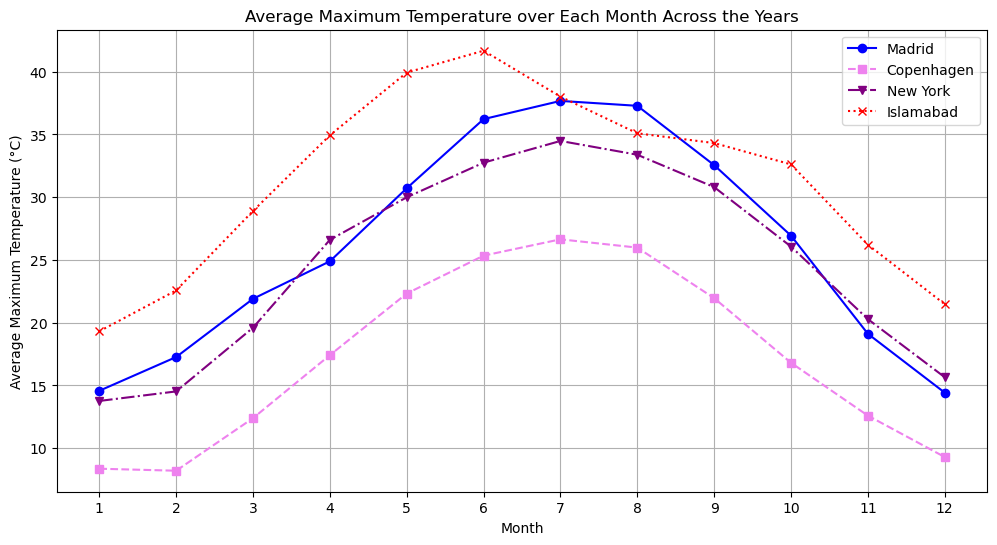

In [16]:
def plot_avg_monthly_max_temp(monthly_max_temp_data):
    linestyles = generic_linestyle
    markers = generic_markers
    plt.figure(figsize=(12, 6))

    for i, (location, data) in enumerate(monthly_max_temp_data.items()):
        monthly_avg_max_temp = data.groupby('month')[f'monthly_max_temp_{location.lower()}'].mean().reset_index().round(2)
        plt.plot(monthly_avg_max_temp['month'], monthly_avg_max_temp[f'monthly_max_temp_{location.lower()}'], label=location, linestyle=linestyles[i], marker=markers[i], color=generic_colors[i])

    plt.title('Average Maximum Temperature over Each Month Across the Years')
    plt.xlabel('Month')
    plt.ylabel('Average Maximum Temperature (°C)')
    plt.grid(True)
    plt.xticks(range(1, 13)) 
    plt.legend()
    plt.show()


plot_avg_monthly_max_temp(monthly_max_temp_data)

In the figure, the previous curve is again observed, indicating that the summer months experience the highest temperatures, as expected. Furthermore, Copenhagen shows the lowest temperatures, while New York and Madrid are similar and closely follow each other, interweaving throughout the period. Lastly, Islamabad exhibits the highest temperatures, as expected based on its geographical location.

#### *4.2 Secondly, the minimum temperature for each city is explored*

The minimum temperature is examined to determine if the same pattern observed for the maximum temperature is present.

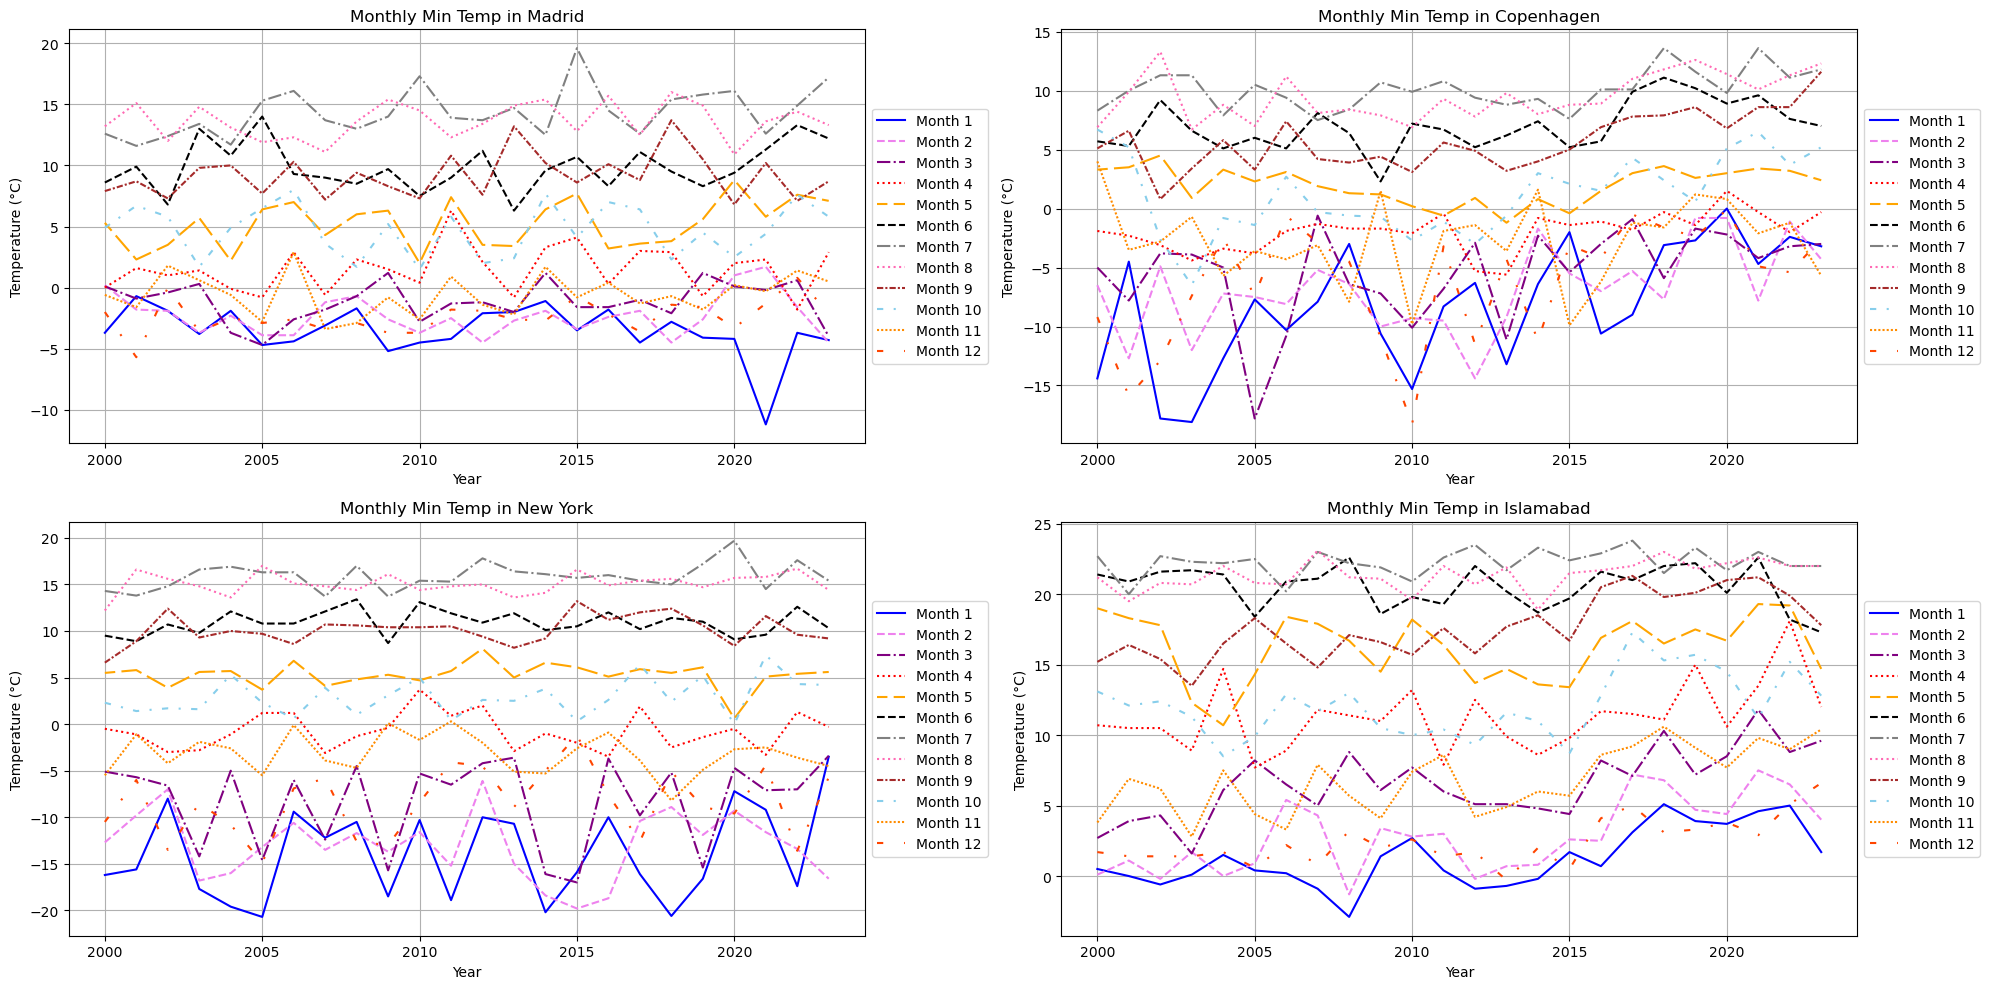

In [17]:
def plot_monthly_min_temp(df1, df2, df3, df4):
    dfs = [df1, df2,df3, df4]
    locations = countries
    colors = generic_colors
    linestyles = generic_linestyle


    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    monthly_avg_min_temp = {}

    for i, (df, location) in enumerate(zip(dfs, locations)):
        row = i // 2
        col = i % 2
        
        df_min_temp = df
        df_min_temp['month'] = df_min_temp['time'].dt.month
        df_min_temp['year'] = df_min_temp['time'].dt.year

        monthly_min_temp = df_min_temp.groupby(['year', 'month'])['temperature_2m_min'].min().reset_index()
        monthly_min_temp = monthly_min_temp.rename(columns={'temperature_2m_min': f'monthly_min_temp_{location.lower()}'})
        monthly_avg_min_temp[location] = monthly_min_temp

        for month in range(1, 13):
            monthly_data = monthly_min_temp[monthly_min_temp['month'] == month]
            axes[row, col].plot(monthly_data['year'], monthly_data[f'monthly_min_temp_{location.lower()}'], label=f'Month {month}', linestyle =linestyles[month-1], color= colors[month-1])

        axes[row, col].set_title(f'Monthly Min Temp in {location}')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel('Temperature (°C)')
        axes[row, col].legend()
        axes[row, col].grid(True)
        axes[row, col].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


    return monthly_avg_min_temp


monthly_min_temp = plot_monthly_min_temp(df_madrid, df_copenhagen, df_NY, df_islamabad)


From these plots, some trends are observed compared to the maximum temperature.
For New York and Madrid, the temperature fluctuates but does not show any clear trends, while Copenhagen exhibits an increase, particularly in temperatures during the winter months. Islamabad shows a similar trend to Copenhagen, but the increase appears less pronounced. Based on the previous figure, there seems to be a relationship between the temperatures in New York and Madrid, which closely follow each other, while Copenhagen and Islamabad, being geographically further north and south, experience more significant changes in temperatures, especially during the winter months.

Following the same approach as for the maximum temperature, the average minimum temperature of each month is examined throughout the years.

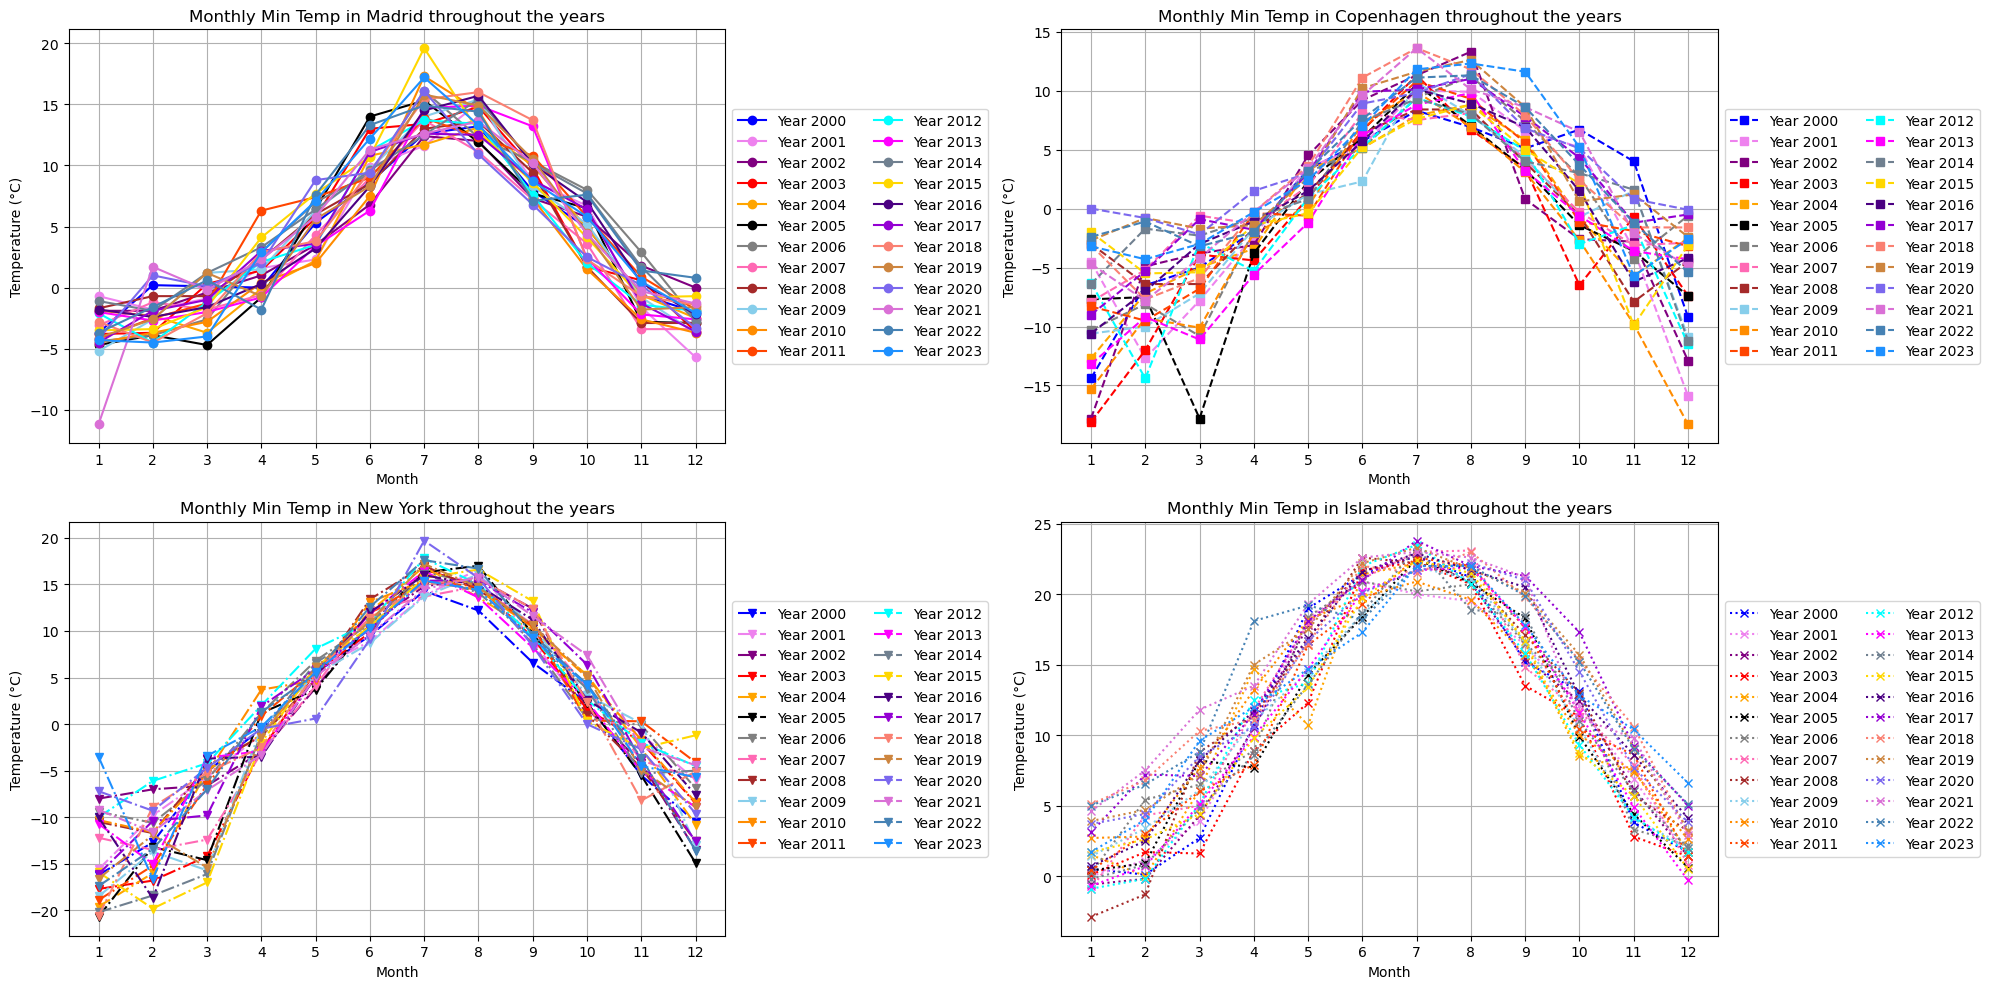

In [18]:
def plot_monthly_years_min_temp(df1, df2, df3, df4):
    dfs = [df1, df2, df3, df4]
    locations = countries 
    linestyles = generic_linestyle
    markers = generic_markers
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
    monthly_avg_min_temp = {} 

    for i, (df, location) in enumerate(zip(dfs, locations)):
        row = i // 2
        col = i % 2
        
        df['month'] = df['time'].dt.month
        df['year'] = df['time'].dt.year

        monthly_min_temp = df.groupby(['year', 'month'])['temperature_2m_min'].min().reset_index()

        unique_years = monthly_min_temp['year'].unique()
        colors = generic_colors 

        for year, color in zip(unique_years, colors):
            year_data = monthly_min_temp[monthly_min_temp['year'] == year]
            months = year_data['month']
            temperatures = year_data['temperature_2m_min']
            axes[row, col].plot(months, temperatures, label=f'Year {year}', marker = markers[i], linestyle = linestyles[i], color=color, alpha=1)

        axes[row, col].set_title(f'Monthly Min Temp in {location} throughout the years')
        axes[row, col].set_xlabel('Month')
        axes[row, col].set_ylabel('Temperature (°C)')
        axes[row, col].legend(ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))
        axes[row, col].grid(True)
        axes[row, col].set_xticks(range(1, 13))  

    plt.tight_layout()
    plt.show()

    return monthly_avg_min_temp

monthly_avg_min_temp = plot_monthly_years_min_temp(df_madrid, df_copenhagen, df_NY, df_islamabad)


Each year is represented by a curve in the graph, showing each month’s average temperature over the 24 years of data. Once again, no clear pattern of temperatures increasing from year to year is observed.

For a clearer visual, the curves are divided into 5-year intervals in the figure below.

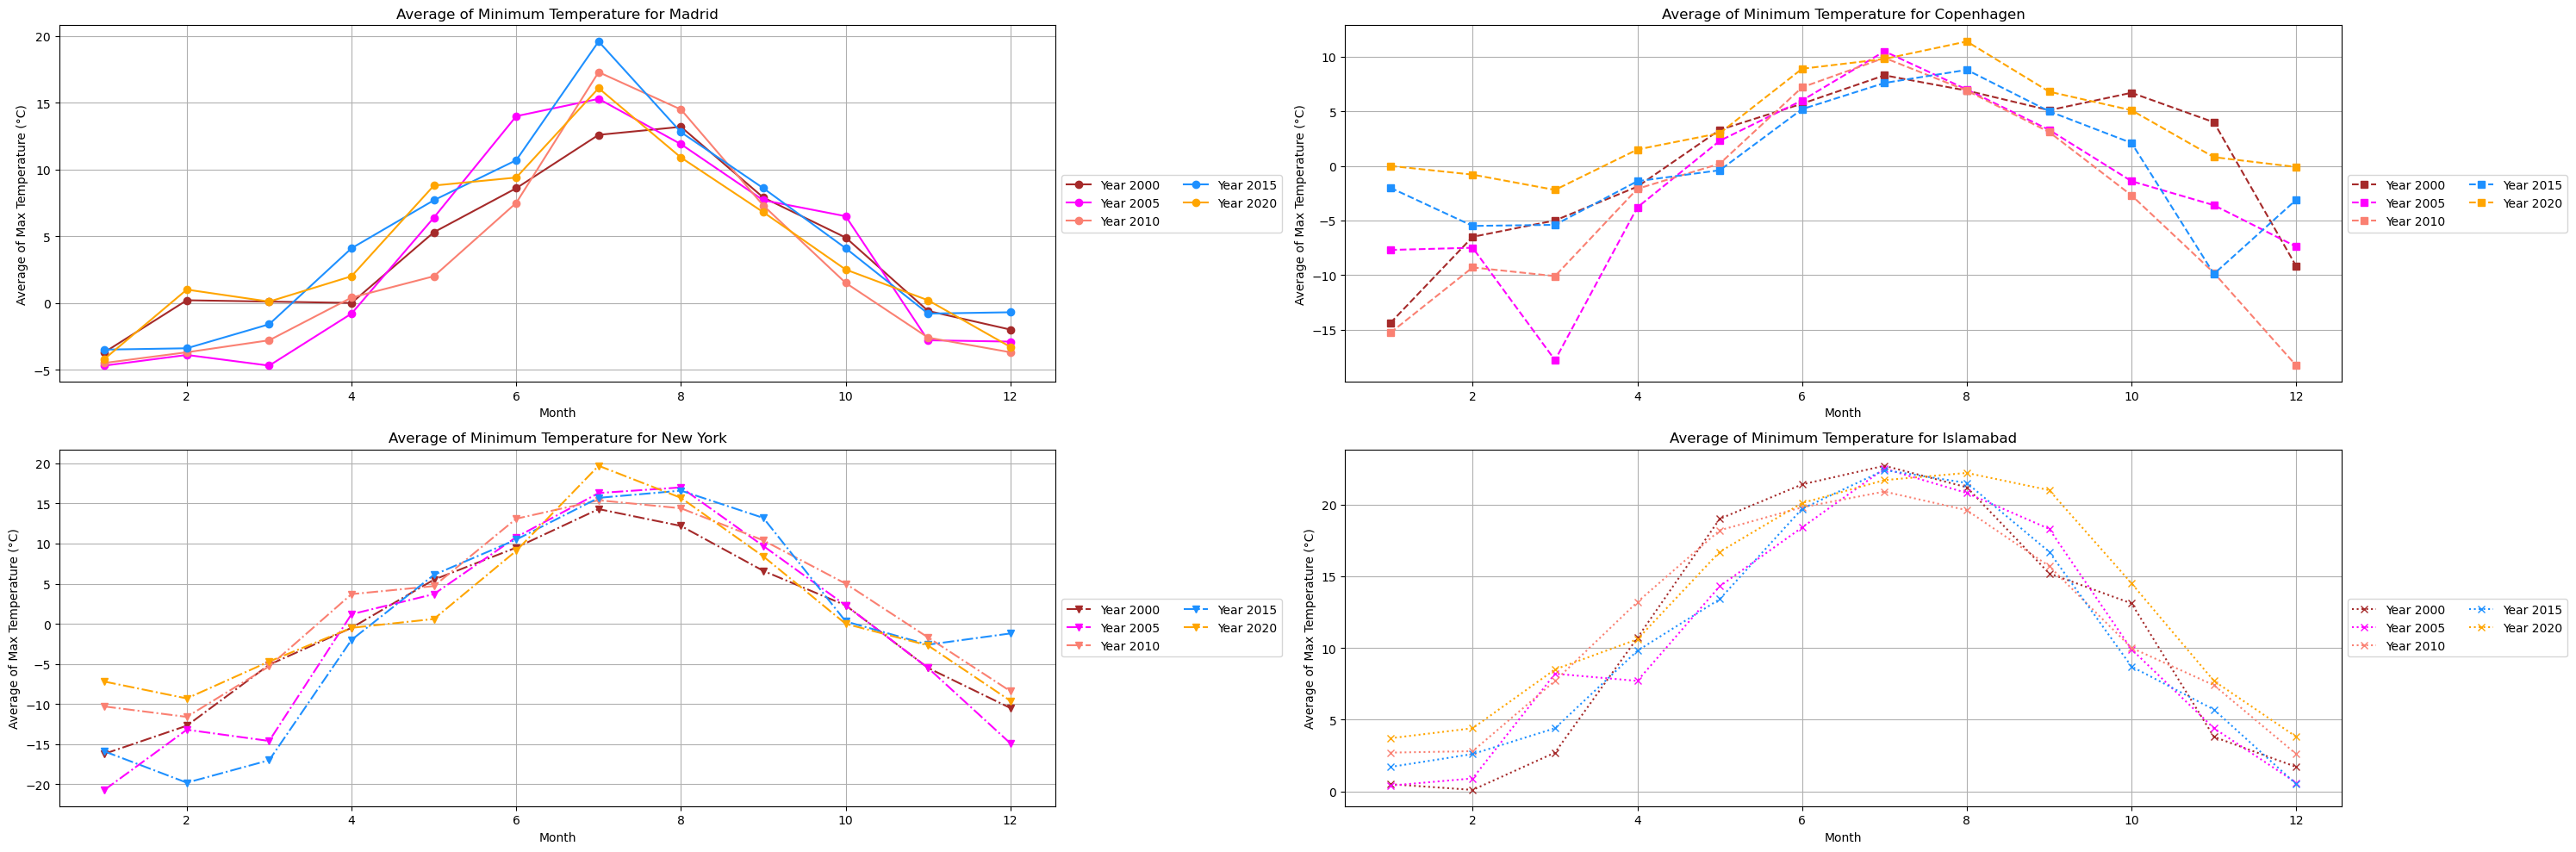

In [19]:
def plot_specific_years(monthly_min_temp_data):
    linestyles = generic_linestyle
    markers = generic_markers
    colors = generic_colors
    fig, axes = plt.subplots(2, 2, figsize=(30, 10))

    specific_years = [2000, 2005, 2010, 2015, 2020]

    for i, (location, data) in enumerate(monthly_min_temp_data.items()):
        row = i // 2
        col = i % 2

        for year in specific_years:
            filtered_data = data[data['year'] == year]
            color_index = year % len(colors) 
            monthly_avg_min_temp = filtered_data.groupby('month')[f'monthly_min_temp_{location.lower()}'].mean() 
            axes[row, col].plot(monthly_avg_min_temp.index, monthly_avg_min_temp.values, label=f'Year {year}', linestyle=linestyles[i], marker=markers[i], color=colors[color_index])

        axes[row, col].set_title(f'Average of Minimum Temperature for {location}')
        axes[row, col].set_xlabel('Month')
        axes[row, col].set_ylabel('Average of Max Temperature (°C)')
        axes[row, col].grid(True)
        axes[row, col].legend(ncol=2, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

plot_specific_years(monthly_min_temp)


Based on the plots, the same tendency is observed as for the maximum temperatures. There is no overall pattern of temperatures increasing. However, during the winter period in Copenhagen, the average minimum temperature shows an increase in the most recent period from 2010 to 2020.

An overview of the minimum temperatures, summarized for each month throughout the years, is presented next.

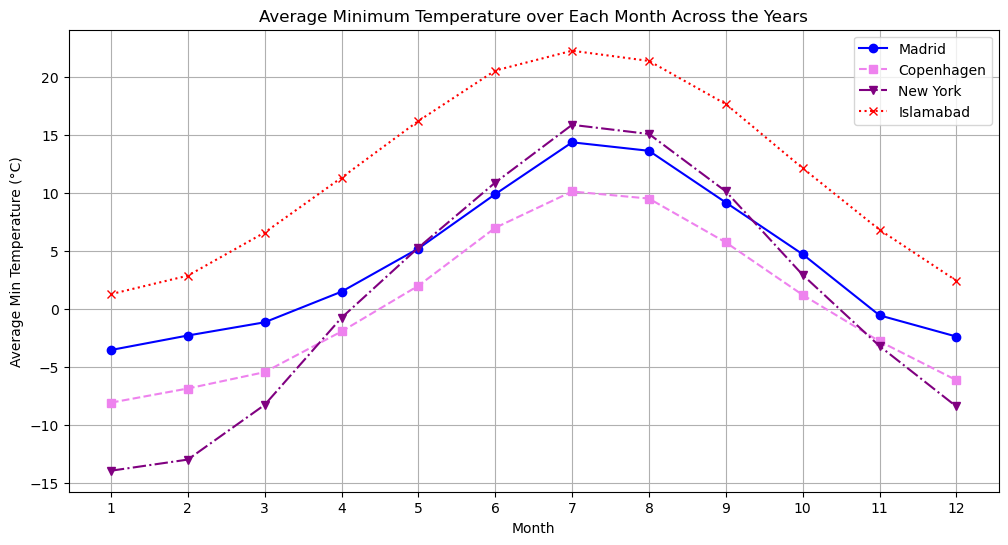

In [20]:
def plot_avg_yearly__min_temp(monthly_min_temp_data):
    linestyles = generic_linestyle
    markers = generic_markers
    plt.figure(figsize=(12, 6))

    for i, (location, data) in enumerate(monthly_min_temp_data.items()):
        monthly_avg_min_temp = data.groupby('month')[f'monthly_min_temp_{location.lower()}'].mean().reset_index().round(2)
        plt.plot(monthly_avg_min_temp['month'], monthly_avg_min_temp[f'monthly_min_temp_{location.lower()}'], label=location, linestyle=linestyles[i], marker=markers[i], color=generic_colors[i])

    plt.title('Average Minimum Temperature over Each Month Across the Years')
    plt.xlabel('Month')
    plt.ylabel('Average Min Temperature (°C)')
    plt.grid(True)
    plt.xticks(range(1, 13)) 
    plt.legend()
    plt.show()


plot_avg_yearly__min_temp(monthly_min_temp)

From the above plot, the pattern of average minimum temperature over a year in the different cities is observed. The order of the curves corresponds to the geographic placement of each country. Furthermore, New York experiences more extreme changes in average minimum temperature over the months than the other cities, starting as the city with the lowest temperatures in the first months, followed by an increase in the summer period exceeding both Copenhagen and Madrid.

#### *4.3 Correlation between data. The correlation between the different variables is explored*

Correlation heatmaps are generated for each of the four datasets to compare the relationships between variables across various locations or scenarios. This analysis allows potential impacts of variables on each other to be discerned within and across different geographical contexts.

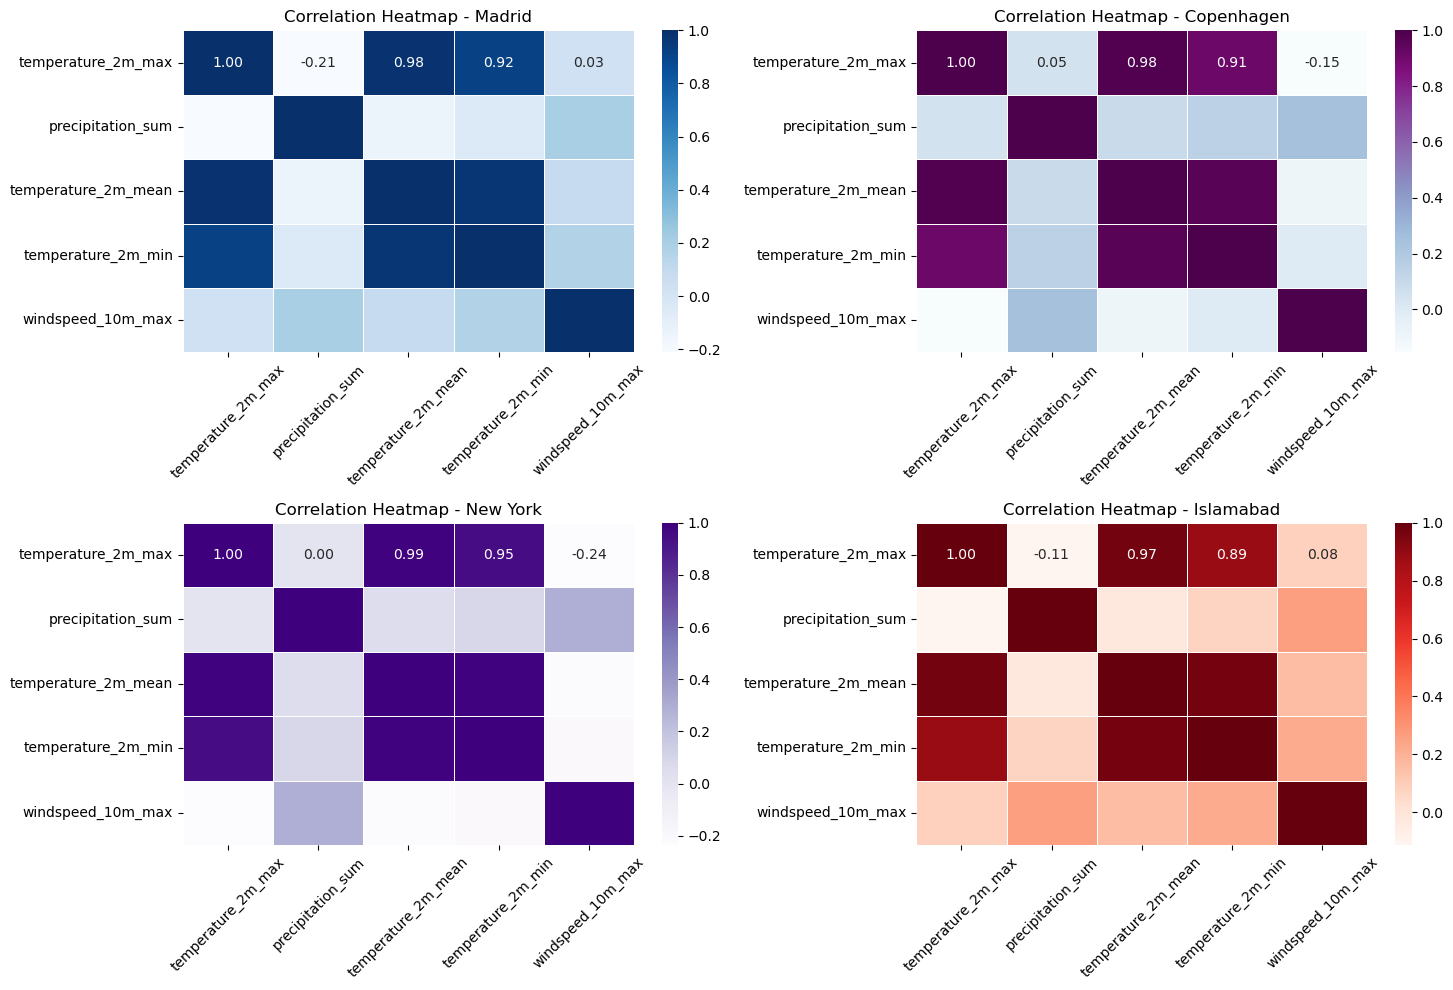

In [21]:
def plot_correlation_heatmaps(df1, df2, df3, df4, titles):
    dfs = [df1, df2, df3, df4]
    locations = countries
    colors = ["Blues", "BuPu", "Purples", "Reds"]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for df, location, title, color, ax in zip(dfs, locations, titles, colors, axes.flatten()):
        correlation = df[['temperature_2m_max', 'precipitation_sum', 'temperature_2m_mean', 'temperature_2m_min', 'windspeed_10m_max']].corr()
        heatmap = sns.heatmap(correlation, annot=True, cmap=color, fmt=".2f", linewidths=.5, ax=ax)
        heatmap.set_title(f'Correlation Heatmap - {location}')
        heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)  

    plt.tight_layout()
    plt.show()

plot_correlation_heatmaps(df_madrid, df_copenhagen, df_NY, df_islamabad, titles=['Madrid', 'Copenhagen', 'New York', 'Islamabad'])

The correlation matrices show the correlation coefficients between all the variables available in the four different datasets.
The correlation coefficient between maximum temperature and itself is 1, as expected, because it represents the correlation of a variable with itself.
The correlation coefficient between maximum temperature and precipitation is -0.21 for Madrid, suggesting a weak negative correlation, while in Copenhagen the correlation is 0.5, indicating a moderate positive relationship between the variables. For Islamabad, the correlation is -0.11, showing a weak negative correlation similar to Madrid. Lastly, the correlation for New York is 0, implying that there is no systematic tendency for precipitation to change as maximum temperature changes. In other words, knowing the value of one variable does not provide information about the value of the other variable. Overall, the correlations between maximum temperature and precipitation are very weak, and the information shared between the two is limited.

When considering the correlation between maximum and mean temperature as well as minimum and mean temperature, it is essential to recognize that correlation does not necessarily imply causation. Instead, it reflects their interdependence due to the calculation method. Mean temperature incorporates information from both maximum and minimum temperatures, so it is expected that they exhibit a high degree of correlation. The high correlation indicates that changes in maximum and minimum temperatures are likely to result in corresponding changes in mean temperature, which is consistent with the calculation method.

The more interesting relationship is the correlation between maximum temperature and minimum temperature.
The correlations indicate a strong positive relationship between maximum and minimum temperatures in all four cities. A correlation close to 1 suggests that as maximum temperature increases, minimum temperature also tends to increase. Additionally, slight differences are observed in the correlation coefficients between the cities. New York exhibits the highest correlation coefficient of 0.95, indicating an extremely strong positive relationship between maximum and minimum temperatures. Copenhagen and Madrid also show high correlations, with coefficients of 0.91 and 0.92, respectively. Islamabad has a slightly lower correlation coefficient of 0.89, indicating a slightly weaker but still significant positive relationship between maximum and minimum temperatures compared to the other cities.

These differences could be attributed to factors such as geographical location, climate patterns, and local environmental influences. For example, New York, being located in a temperate climate zone, may exhibit a more consistent relationship between maximum and minimum temperatures compared to Islamabad, which experiences more variability due to its continental climate.

#### *4.4 Is the data stationary? Or is differencing needed?*

For the next section, the goal is to forecast the maximum temperatures, but beforehand it is necessary to ensure that the data is stationary and does not require further adjustments. Rolling statistics and corresponding plots are used to examine the datasets for all four cities.

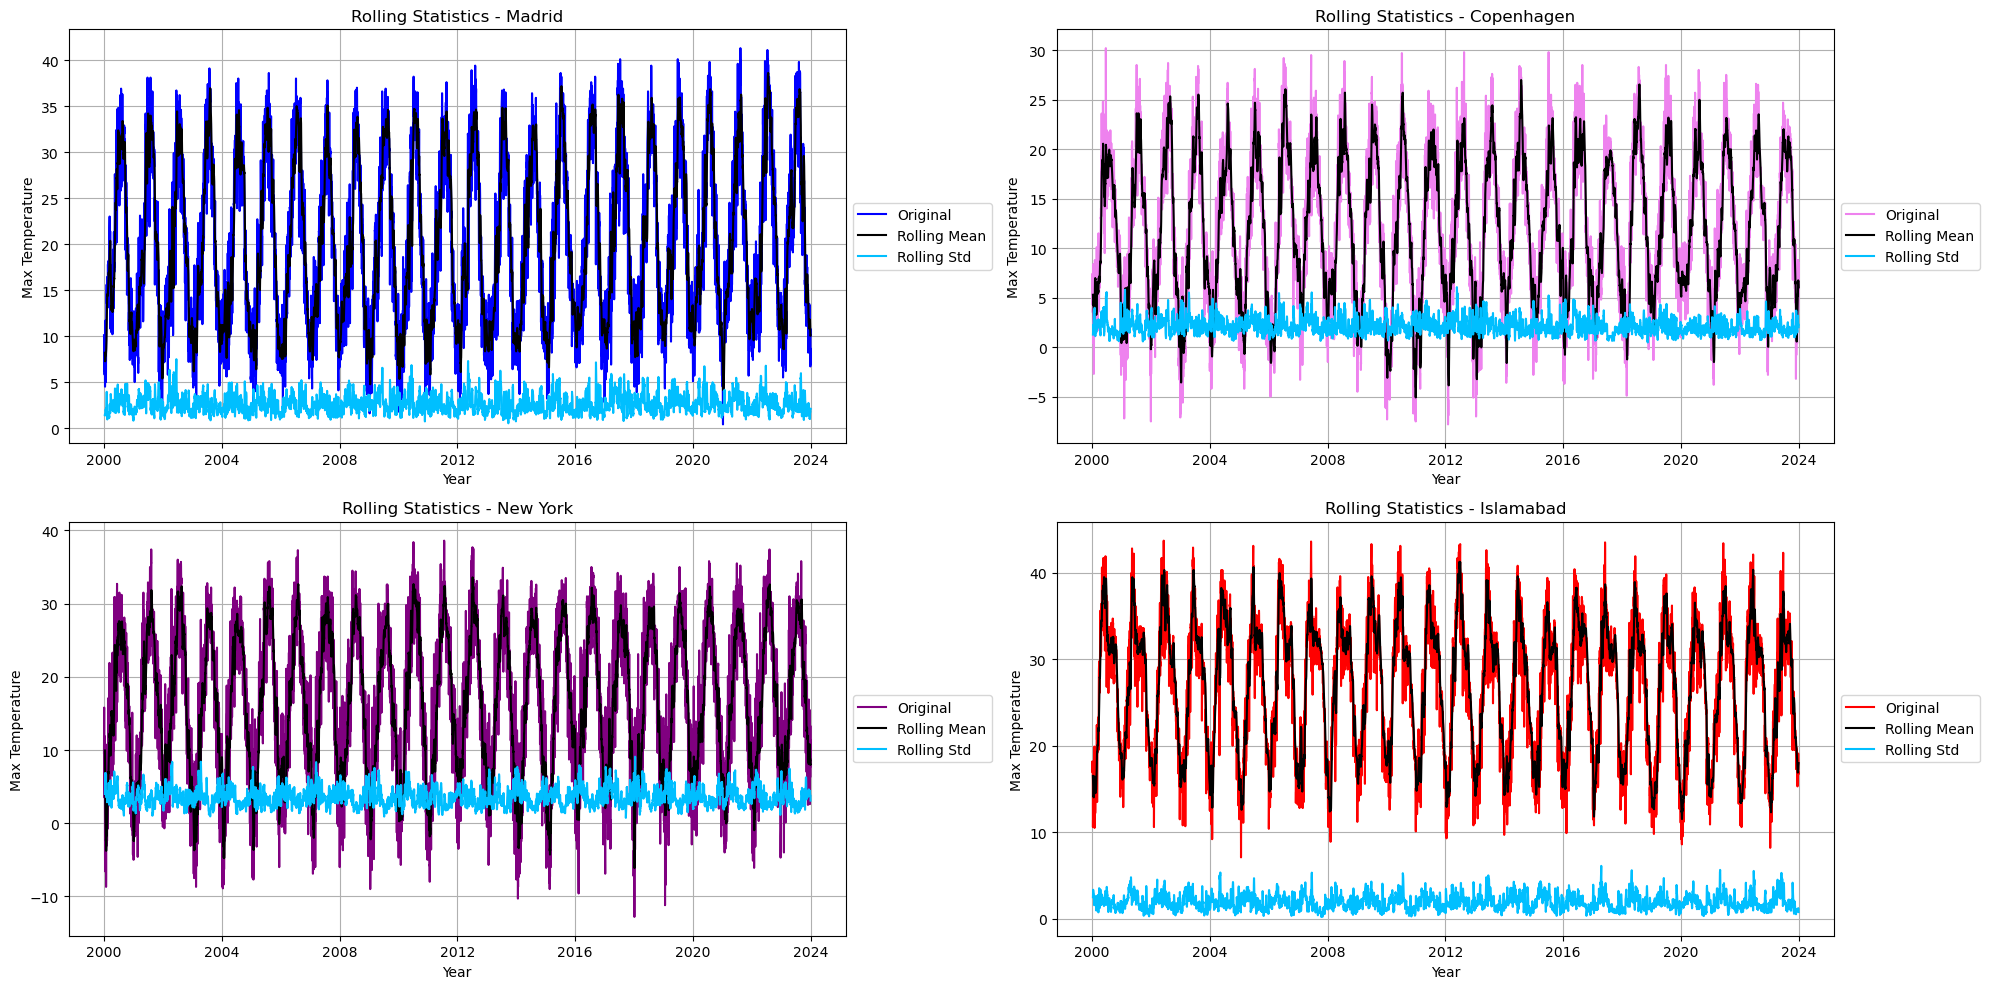

In [22]:
def plot_rolling_statistics_for_all(df1, df2, df3, df4, window=12):
    dfs = [df1, df2, df3, df4]
    locations = countries
    colors = generic_colors
    linestyles = ['-', '-', '-', '-']

    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    for i, (df, location, color, linestyle) in enumerate(zip(dfs, locations, colors, linestyles)):
        row = i // 2
        col = i % 2
        
        axes[row, col].plot(df['time'], df['temperature_2m_max'], color=generic_colors_four[i], label='Original', linestyle = linestyle)
        axes[row, col].plot(df['time'], df['temperature_2m_max'].rolling(window).mean(), color='black', label='Rolling Mean', linestyle = linestyle)
        axes[row, col].plot(df['time'], df['temperature_2m_max'].rolling(window).std(), color='deepskyblue', label='Rolling Std', linestyle = linestyle)
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel('Max Temperature')
        axes[row, col].set_title(f'Rolling Statistics - {location}')
        axes[row, col].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_rolling_statistics_for_all(df_madrid, df_copenhagen, df_NY, df_islamabad)

The data appears to be stationary, as the mean is roughly constant over time and there are no significant upward or downward trends. When examining the standard deviation, the development is similar and approximately constant over time, with no patterns of increasing or decreasing variability.

Additionally, an Augmented Dickey-Fuller test is performed for stationarity in the data to obtain quantitative measures and confirm the stationarity of the datasets.

In [23]:
def perform_adfuller_test(data, str):
    result = adfuller(data['temperature_2m_max'], autolag="AIC")
    print("For " + str + ":")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Observations used: %f' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

perform_adfuller_test(df_madrid, 'Madrid')
perform_adfuller_test(df_copenhagen, 'Copenhagen')
perform_adfuller_test(df_NY, 'New York')
perform_adfuller_test(df_islamabad, 'Islamabad')

For Madrid:
ADF Statistic: -6.611023
p-value: 0.000000
Observations used: 8728.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
For Copenhagen:
ADF Statistic: -5.754734
p-value: 0.000001
Observations used: 8740.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
For New York:
ADF Statistic: -6.691830
p-value: 0.000000
Observations used: 8728.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
For Islamabad:
ADF Statistic: -7.998551
p-value: 0.000000
Observations used: 8728.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


From the above results, for Madrid the p-value is very low and close to zero, and the ADF statistic is significantly lower than the critical values, indicating that the null hypothesis of non-stationarity can be rejected. The same applies to the other three cities.
Based on the ADF test results, temperature data for all four cities are stationary, as evidenced by their low p-values and ADF statistics below the critical values at all significance levels. Therefore, no further adjustments are required.

Lastly, to detect any trends or patterns, seasonal decomposition is performed on the temperature data by applying an additive model and plotting the original data, trend, seasonal component, and residual component.

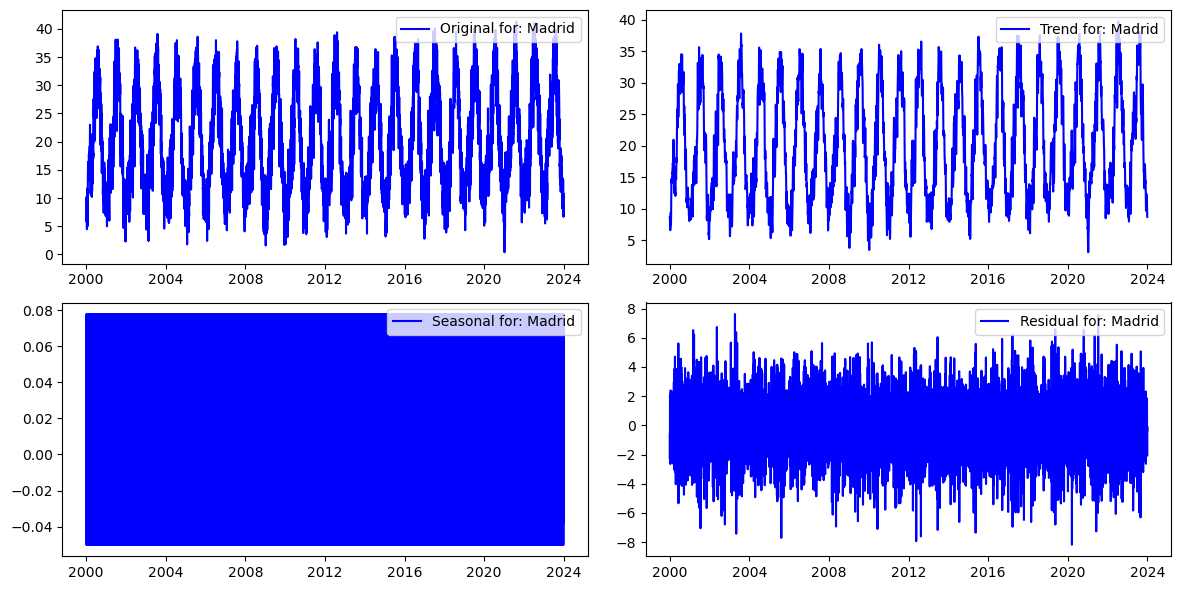

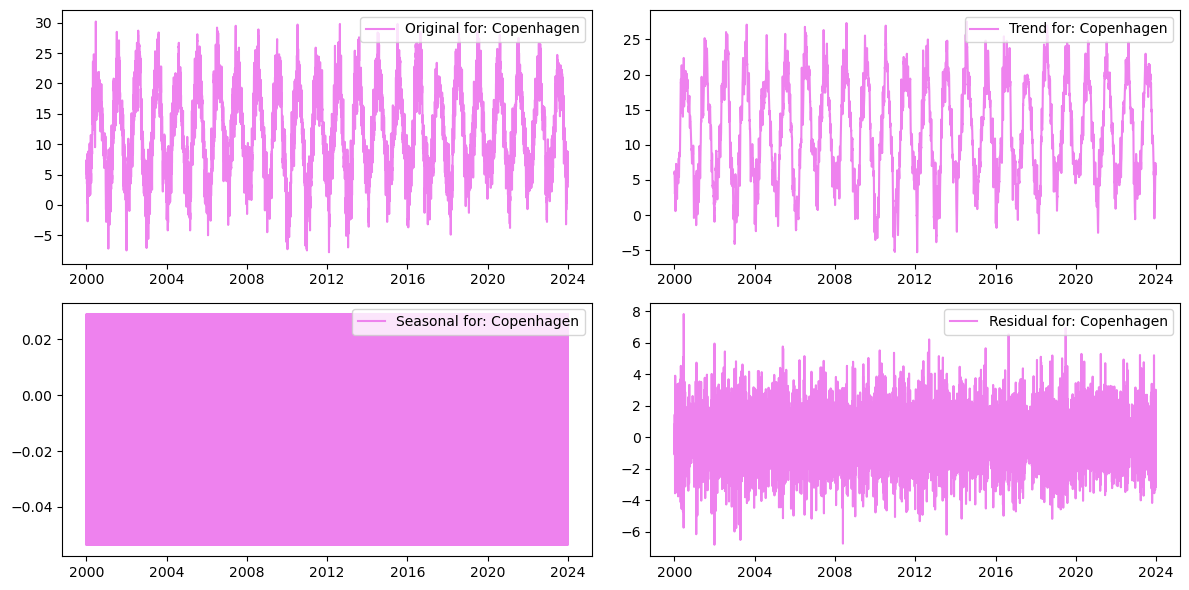

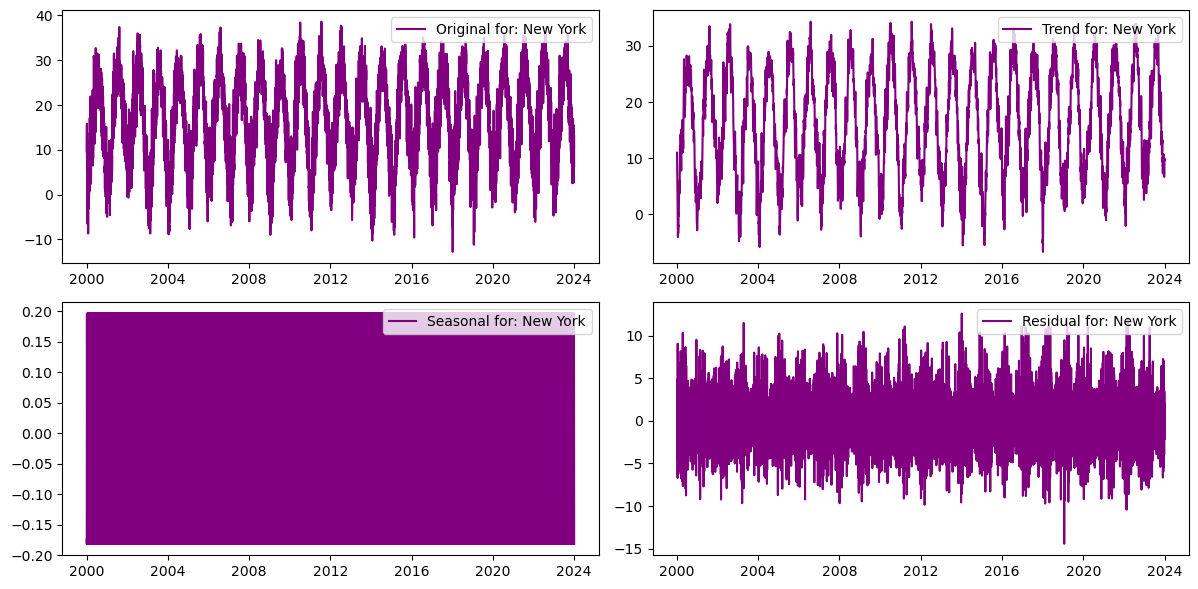

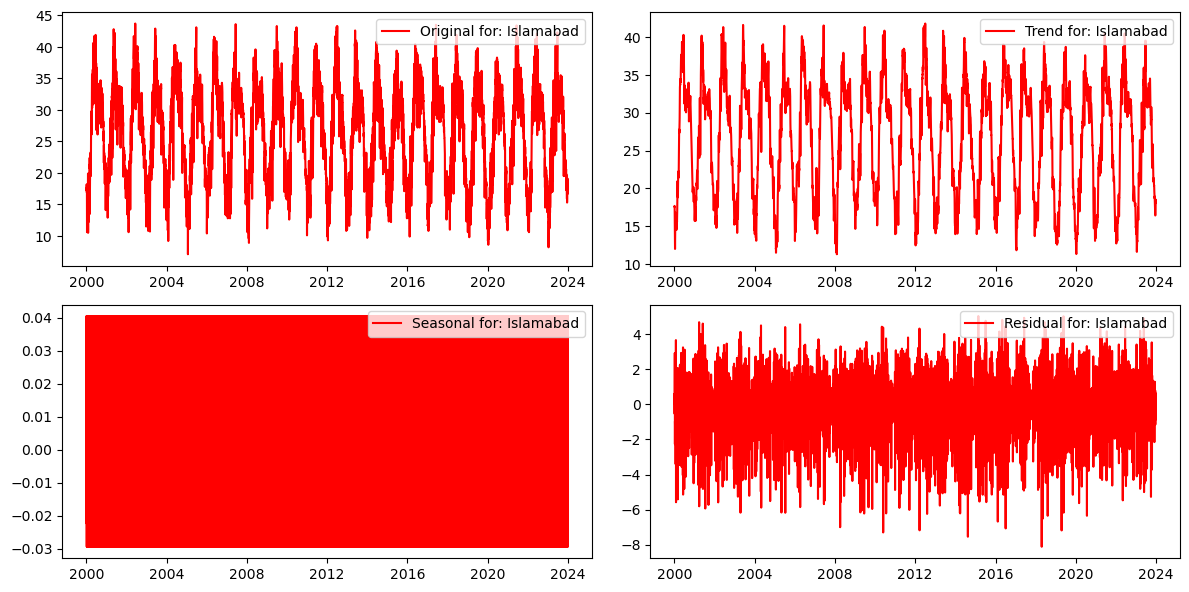

In [24]:
def plot_seasonal_decomposition(df, str, colors):
    df.set_index('time', inplace=True)
    decomposition = seasonal_decompose(df['temperature_2m_max'], model='additive')
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(df.index, df['temperature_2m_max'], color= colors, label='Original for: ' + str)
    plt.legend(loc='upper right')
    
    plt.subplot(2, 2, 2)
    plt.plot(decomposition.trend, color= colors,  label='Trend for: ' + str)
    plt.legend(loc='upper right')
    
    plt.subplot(2, 2, 3)
    plt.plot(decomposition.seasonal, color= colors, label='Seasonal for: ' + str)
    plt.legend(loc='upper right')
    
    plt.subplot(2, 2, 4)
    plt.plot(decomposition.resid, color= colors,  label='Residual for: ' + str)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_seasonal_decomposition(df_madrid, 'Madrid', 'blue')
plot_seasonal_decomposition(df_copenhagen, 'Copenhagen', 'violet')
plot_seasonal_decomposition(df_NY, 'New York', 'purple')
plot_seasonal_decomposition(df_islamabad, 'Islamabad', 'red')


Based on the results for all four cities there is no seasonality or trends occuring.

# 5. Predicting using time series model and forecasting ARIMA and XGBoost

#### *5.1 In the absence of detected trends or seasonality, the ARIMA model is adopted for prediction and forecasting. ARIMA is particularly adept at handling data devoid of trends or seasonality. The objective is to employ this model to predict future maximum temperatures for all four countries or to train a model capable of doing so. What can the current data indicate about the prediction of heatwaves?*

To employ the ARIMA model effectively, its parameters, denoted as (p, d, q), must be established. Following the Dickey-Fuller test conducted on all four cities, the p-value is less than 0.05, indicating rejection of the null hypothesis and confirming that the datasets are stationary. Consequently, there is no requirement for differencing the datasets, resulting in the parameter d in the ARIMA model being set to 0.

Next, the maximum temperature data is partitioned into training and testing sets using a predetermined ratio. The training data is used to train the model, while the testing data assesses the model's predictive performance on unseen data.

To determine the values for the p and q parameters, the autocorrelation function (ACF) plot is examined to identify the p value and the partial autocorrelation function (PACF) plot to determine the q value.

The ACF and PACF plots are generated and analyzed to establish the appropriate order for the p and q parameters.

First, the data is split into training and testing sets, and the ACF and PACF plots are created.

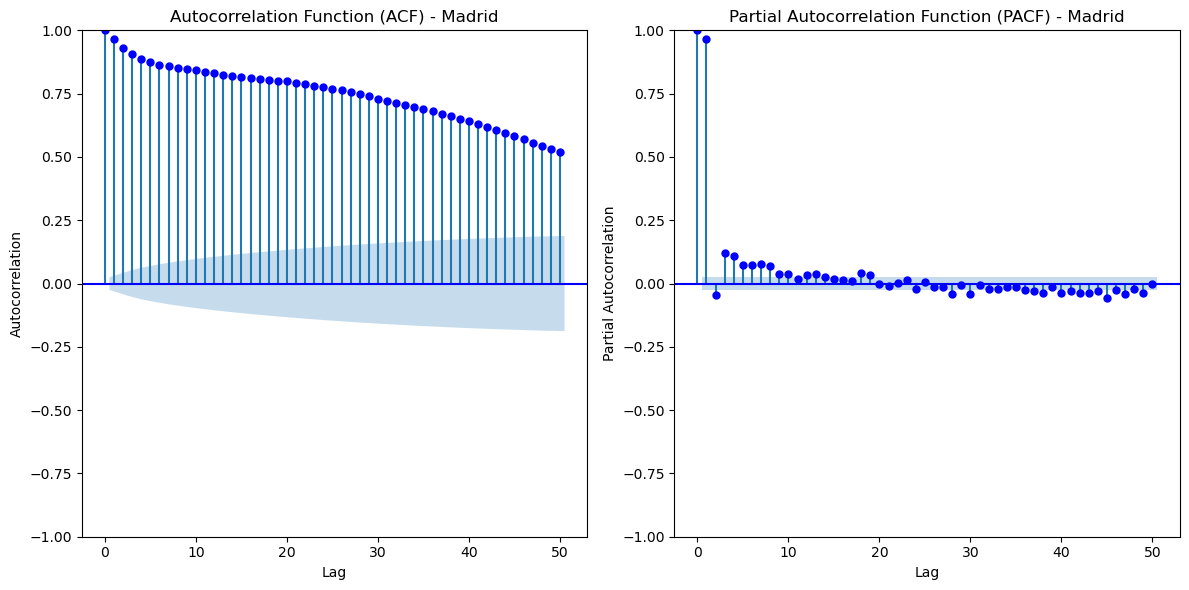

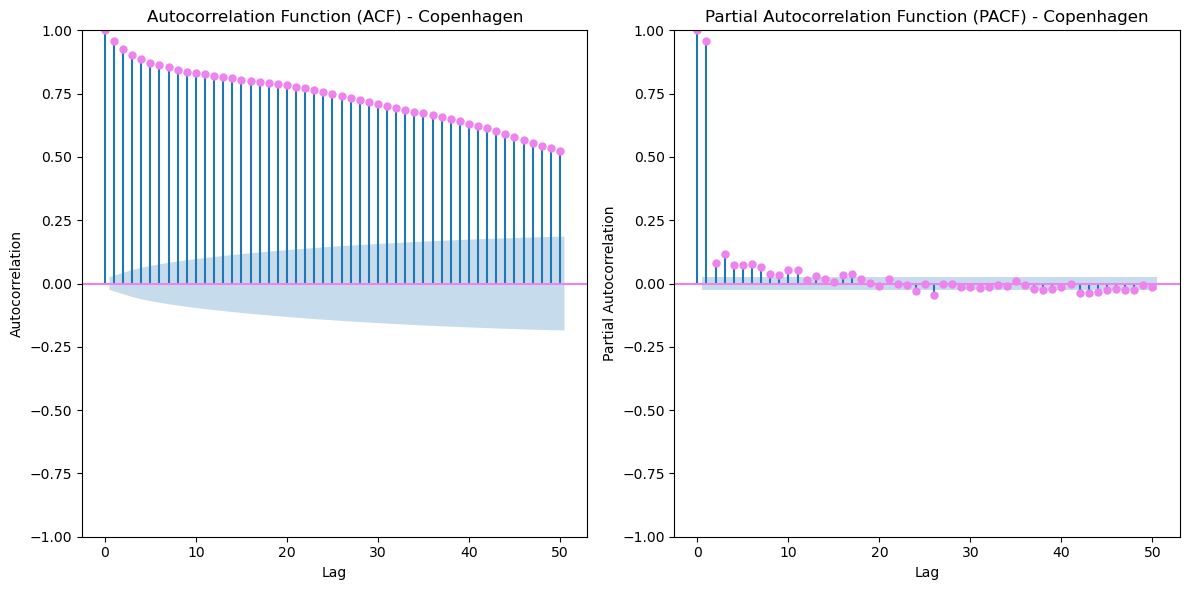

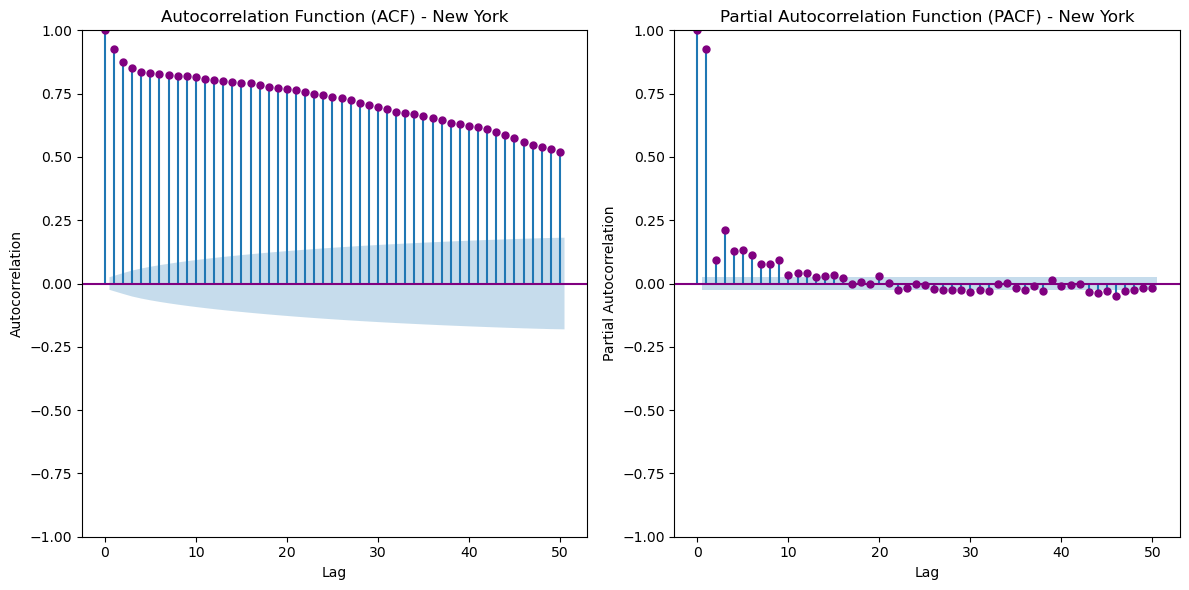

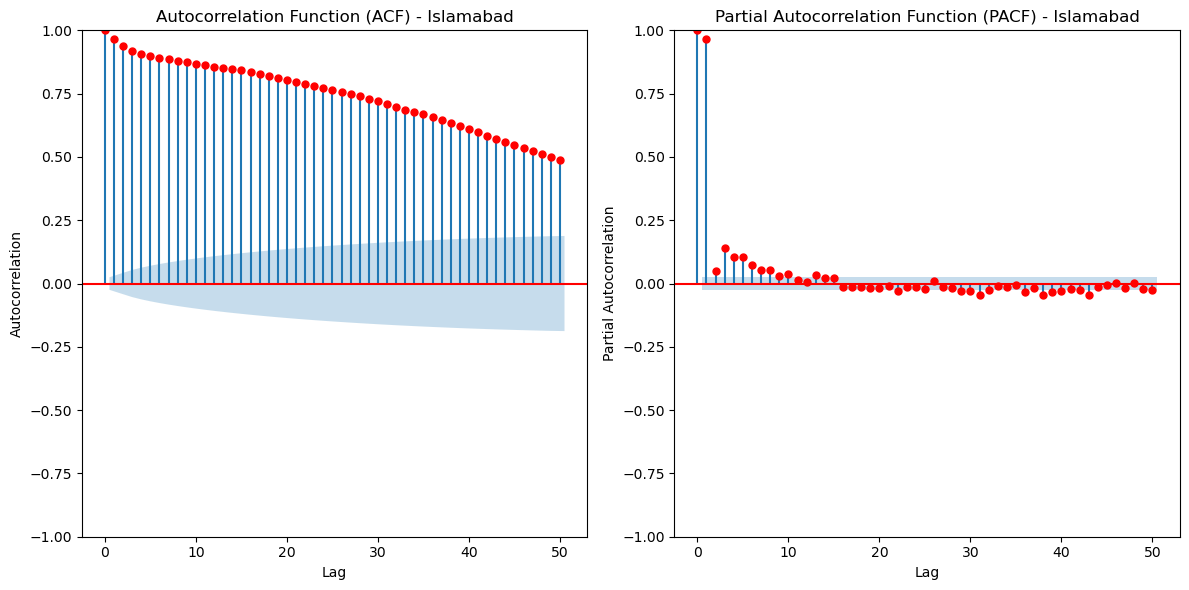

In [25]:
def split_data_by_year(df, train_start, train_end, test_start, test_end):
    df.reset_index(inplace=True)
    train_data = df[(df['time'] >= train_start) & (df['time'] <= train_end)]
    test_data = df[(df['time'] >= test_start) & (df['time'] <= test_end)]
    
    return train_data, test_data

def plot_acf_pacf(df, location, color):
    data = df
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_acf(data['temperature_2m_max'], lags=50, ax=axes[0], color=color)
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title(f'Autocorrelation Function (ACF) - {location}')
    
    plot_pacf(data['temperature_2m_max'], lags=50, ax=axes[1], color=color)
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Partial Autocorrelation')
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {location}')
    
    plt.tight_layout()
    plt.show()
    
    return data

train_start = '2000-01-01'
train_end = '2016-12-31'
test_start = '2017-01-01'
test_end = '2023-12-31'


train_data_madrid, test_data_madrid = split_data_by_year(df_madrid, train_start, train_end, test_start, test_end)
train_data_copenhagen, test_data_copenhagen = split_data_by_year(df_copenhagen, train_start, train_end, test_start, test_end)
train_data_NY, test_data_NY = split_data_by_year(df_NY, train_start, train_end, test_start, test_end)
train_data_islamabad, test_data_islamabad = split_data_by_year(df_islamabad, train_start, train_end, test_start, test_end)


train_data_madrid = plot_acf_pacf(train_data_madrid, 'Madrid', 'blue')
train_data_copenhagen = plot_acf_pacf(train_data_copenhagen, 'Copenhagen', 'violet')
train_data_NY = plot_acf_pacf(train_data_NY, 'New York', 'purple')
train_data_islamabad = plot_acf_pacf(train_data_islamabad, 'Islamabad', 'red')

Examining the ACF and PACF plots across all countries reveals consistent patterns. The analysis for Madrid is as follows:

For the ACF plot, a gradual decrease in lags is observed, with all values initially above the significance line. However, the significance of these values diminishes after lag 3. Consequently, the q value is set to 3. The potential impact of higher and lower values for q on the model's performance is also considered.

In the PACF plot, lag 1 and 2 exceed the significance threshold, while subsequent lags do not show similar significance. Accordingly, the p value is set to 2, representing the autoregressive (AR) component in the ARIMA model.

Based on this analysis, the initial parameters are determined as d = 0, p = 2, and q = 3.

##### *5.1.1 ARIMA on max temperature*

In [26]:
model_madrid = ARIMA(train_data_madrid['temperature_2m_max'], order=(2, 0, 3))
model_fit_madrid = model_madrid.fit()
print("Madrid Model Summary:")
print(model_fit_madrid.summary())


model_copenhagen = ARIMA(train_data_copenhagen['temperature_2m_max'], order=(2, 0, 3))
model_fit_copenhagen = model_copenhagen.fit()
print("Copenhagen Model Summary:")
print(model_fit_copenhagen.summary())

model_NY = ARIMA(train_data_NY['temperature_2m_max'], order=(2, 0, 3))
model_fit_NY = model_NY.fit()
print("New York Model Summary:")
print(model_fit_NY.summary())

model_islamabad = ARIMA(train_data_islamabad['temperature_2m_max'], order=(2, 0, 3))
model_fit_islamabad = model_islamabad.fit()
print("Islamabad Model Summary:")
print(model_fit_islamabad.summary())

Madrid Model Summary:
                               SARIMAX Results                                
Dep. Variable:     temperature_2m_max   No. Observations:                 6210
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -13759.669
Date:                Fri, 26 Apr 2024   AIC                          27533.338
Time:                        17:18:52   BIC                          27580.476
Sample:                             0   HQIC                         27549.679
                               - 6210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.0140      2.035      9.345      0.000      15.026      23.002
ar.L1          1.5465      0.042     36.820      0.000       1.464       1.629
ar.L2         -0.5493      0.0

The above summaries detail the fitting of ARIMA models to temperature data for the four cities.

In Madrid, the SARIMAX(2, 0, 3) structure was recommended. Notably, the coefficient for temperature_2m_max is statistically significant (p-value < 0.05), indicating a significant impact of maximum temperature changes on maximum temperature itself. The Ljung-Box test for autocorrelation suggests some residual correlation at lag 1.

Similarly, Copenhagen's summary indicates a SARIMAX(2, 0, 3) structure. Like Madrid, the coefficient for temperature_2m_max is statistically significant. However, the absence of significant residual correlation in the Ljung-Box test implies that residuals are likely independent and uncorrelated across different time lags.

In New York, the SARIMAX(2, 0, 3) model is suggested. Here, the highly statistically significant coefficient for temperature_2m_max underscores its substantial impact on maximum temperature. Additionally, no significant residual correlation is found by the Ljung-Box test.

Islamabad's model summary similarly adheres to a SARIMAX(2, 0, 3) structure, with a statistically significant coefficient for temperature_2m_max. Nonetheless, the Ljung-Box test highlights some residual autocorrelation at lag 1.

Across all models, the relationship between maximum temperatures is reasonably captured. The significance of the temperature_2m_max coefficient underscores its value as an exogenous factor, enhancing model performance.

Furthermore, the Ljung-Box tests provide insights into residual autocorrelation, pinpointing areas for potential improvement, particularly in models exhibiting significant residual correlation at lag 1.

Finally, comparing AIC and BIC values shows that lower values denote better model fit. Accordingly, the Copenhagen model exhibits the best fit, closely followed by the New York model, while the Madrid and Islamabad models display slightly higher AIC and BIC values.

The predictions generated by the model are now plotted.

Root Mean Squared Error (RMSE) for Madrid: 9.39
Root Mean Squared Error (RMSE) for Copenhagen: 6.77
Root Mean Squared Error (RMSE) for New York: 9.71
Root Mean Squared Error (RMSE) for Islamabad: 7.59


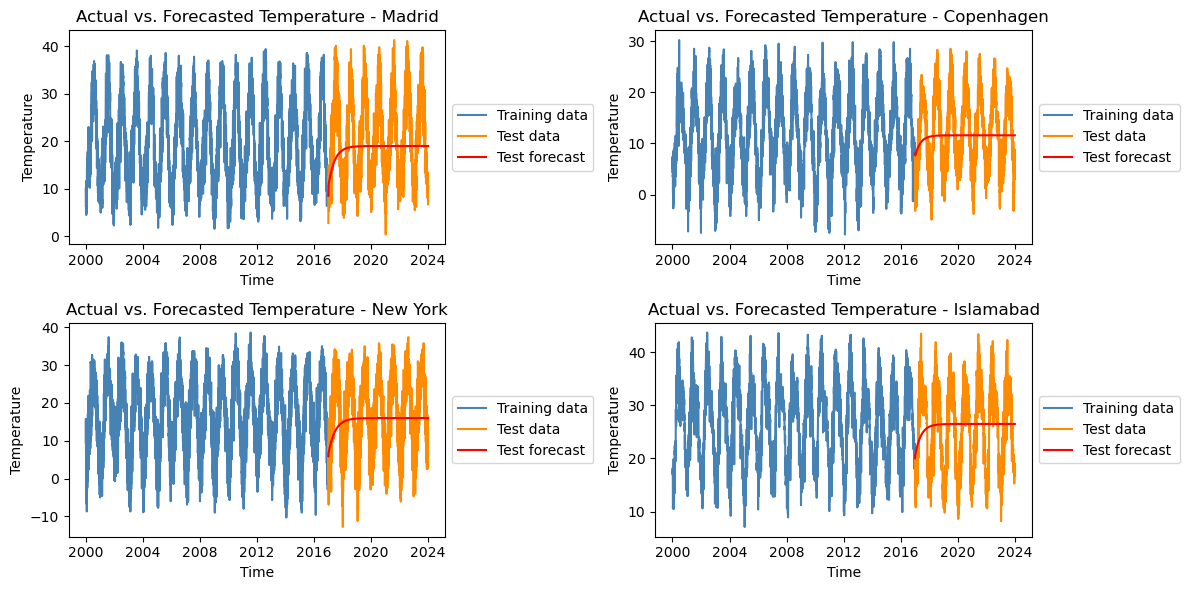

In [27]:

def generate_forecast_and_plot_for_all_data(model_fits, train_datasets, test_datasets, locations):
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    
    for model_fit, train_data, test_data, location, ax in zip(model_fits, train_datasets, test_datasets, locations, axes.flatten()):
        forecast_test = model_fit.forecast(steps=len(test_data))

        
        ax.plot(train_data['time'], train_data['temperature_2m_max'], label='Training data', color='steelblue')
        ax.plot(test_data['time'], test_data['temperature_2m_max'], label='Test data', color='darkorange')
        ax.plot(test_data['time'], forecast_test, label='Test forecast', color='red')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Temperature')
        ax.set_title(f'Actual vs. Forecasted Temperature - {location}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        rmse = mean_squared_error(test_data['temperature_2m_max'], forecast_test, squared=False)
        print(f"Root Mean Squared Error (RMSE) for {location}:", rmse.round(2))

    plt.tight_layout()
    plt.show()

model_fits = [model_fit_madrid, model_fit_copenhagen, model_fit_NY, model_fit_islamabad]
train_datasets = [train_data_madrid, train_data_copenhagen, train_data_NY, train_data_islamabad]
test_datasets = [test_data_madrid, test_data_copenhagen, test_data_NY, test_data_islamabad]
locations = ['Madrid', 'Copenhagen', 'New York', 'Islamabad']

generate_forecast_and_plot_for_all_data(model_fits, train_datasets, test_datasets, locations)

The Root Mean Squared Error (RMSE) is calculated to assess the forecasting accuracy of the ARIMA models.

For Madrid, the RMSE value of 9.39 indicates that, on average, the ARIMA model's predictions for maximum temperature deviated by approximately 9.39 degrees Celsius from the actual observed values in the test dataset.

Similarly, for Copenhagen, the RMSE is smaller at 6.77.

New York's RMSE of 9.71 is comparable to Madrid's.

In contrast, Islamabad performs better than Madrid and New York, with an RMSE of 7.59, which is closest to Copenhagen's.

While these differences may seem relatively small, in the context of Celsius degrees, deviations of around 6.7 degrees Celsius or more from the actual observed values are significant. This indicates that the model performs reasonably well but could benefit from improvement.

##### *5.1.2 Exploring other q-values in the arima model*

Exploring various values for q, given that all lags were above the significance level, the goal is to determine the optimal value for the model's performance. Although 3 was initially selected, it is assessed whether this value yields the best results.
To investigate, lag values of 1, 2, 3, and 15 are tested to observe their impact on the model.

In [28]:
def train_arima_models(train_data, test_data, orders):
    model_fits = []
    rmses = []
    
    for order in orders:
        model = ARIMA(train_data['temperature_2m_max'], order=order)
        model_fit = model.fit()
        model_fits.append(model_fit)
        
        forecast = model_fit.forecast(steps=len(test_data))

        rmse = mean_squared_error(test_data['temperature_2m_max'], forecast, squared=False)
        rmses.append(rmse)

    return model_fits, rmses

orders = [(2,0,3),(2, 0, 1), (2, 0, 2), (2, 0, 3), (2,0,15)]

model_fits_madrid, rmses_madrid = train_arima_models(train_data_madrid, test_data_madrid, orders)
model_fits_copenhagen, rmses_copenhagen = train_arima_models(train_data_copenhagen, test_data_copenhagen, orders)
model_fits_NY, rmses_NY = train_arima_models(train_data_NY, test_data_NY, orders)
model_fits_islamabad, rmses_islamabad = train_arima_models(train_data_islamabad, test_data_islamabad, orders)

print("RMSEs for Madrid:", [round(rsme, 2) for rsme in rmses_madrid])
print("RMSEs for Copenhagen:", [round(rsme, 2) for rsme in rmses_copenhagen ])
print("RMSEs for New York:",[round(rsme, 2) for rsme in rmses_NY ] )
print("RMSEs for Islamabad:", [round(rsme, 2) for rsme in rmses_islamabad])


RMSEs for Madrid: [9.39, 9.0, 9.26, 9.39, 23.37]
RMSEs for Copenhagen: [6.77, 6.78, 6.78, 6.77, 6.75]
RMSEs for New York: [9.71, 9.62, 9.75, 9.71, 14.51]
RMSEs for Islamabad: [7.59, 7.57, 7.61, 7.59, 7.61]


Based on the RMSE values obtained for different values of q in the ARIMA model:

For Madrid: RMSEs are [9.39, 9.0, 9.26, 9.39, 23.1]
For Copenhagen: RMSEs are [6.77, 6.77, 6.78, 6.77, 6.75]
For New York: RMSEs are [9.71, 9.62, 9.75, 9.71, 14.5]
For Islamabad: RMSEs are [7.59, 7.57, 7.61, 7.59, 7.61]

The ARIMA model generally performs best for all cities when q = 1. Therefore, for future predictions, q = 1 is set for all cities.

##### *5.1.3 ARIMA used with other variable*

Considering the correlations identified during the exploratory analysis, where a high correlation between maximum and minimum temperatures was observed for all cities, the ARIMA model is trained to incorporate both of these variables. Given the results from the previous section, where q = 1 was determined as the optimal parameter, the performance of a model incorporating both maximum and minimum temperatures is investigated.

In [29]:
model_madrid = ARIMA(train_data_madrid['temperature_2m_max'], exog=train_data_madrid[['temperature_2m_min']], order=(2, 0, 1))
model_fit_madrid = model_madrid.fit()
print("Madrid Model Summary:")
print(model_fit_madrid.summary())


model_copenhagen = ARIMA(train_data_copenhagen['temperature_2m_max'], exog=train_data_copenhagen[['temperature_2m_min']], order=(2, 0, 1))
model_fit_copenhagen = model_copenhagen.fit()
print("Copenhagen Model Summary:")
print(model_fit_copenhagen.summary())

model_NY = ARIMA(train_data_NY['temperature_2m_max'], exog=train_data_NY[['temperature_2m_min']], order=(2, 0, 1))
model_fit_NY = model_NY.fit()
print("New York Model Summary:")
print(model_fit_NY.summary())

model_islamabad = ARIMA(train_data_islamabad['temperature_2m_max'], exog=train_data_islamabad[['temperature_2m_min']], order=(2, 0, 1))
model_fit_islamabad = model_islamabad.fit()
print("Islamabad Model Summary:")
print(model_fit_islamabad.summary())


Madrid Model Summary:
                               SARIMAX Results                                
Dep. Variable:     temperature_2m_max   No. Observations:                 6210
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -13811.325
Date:                Fri, 26 Apr 2024   AIC                          27634.650
Time:                        17:21:51   BIC                          27675.054
Sample:                             0   HQIC                         27648.657
                               - 6210                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.7933      0.660     26.957      0.000      16.500      19.087
temperature_2m_min     0.2274      0.014     15.931      0.000       0.199       0.25

In the above output, summaries of ARIMA models fitted to temperature data from the four different cities are presented.

For Madrid, the results suggest a SARIMAX(2, 0, 1) structure, while the coefficient for temperature_2m_min is statistically significant (p-value < 0.05), indicating strong evidence that changes in minimum temperature significantly affect maximum temperature according to the model. The Ljung-Box test for autocorrelation indicates some residual correlation at lag 1.

For Copenhagen, the model also follows a SARIMAX(2, 0, 1) structure, and the coefficient for temperature_2m_min is statistically significant, similar to Madrid. However, the Ljung-Box test for autocorrelation does not show significant residual correlation, implying that the residuals appear independent and uncorrelated at different time lags, indicating that the model has adequately captured the underlying patterns in the data.

In the New York summary, the SARIMAX(2, 0, 1) model is again suggested. The coefficient for temperature_2m_min is highly statistically significant, indicating that changes in minimum temperature have a substantial and meaningful impact on maximum temperature according to the statistical model. The Ljung-Box test for autocorrelation shows no significant residual correlation.

In the Islamabad model summary, the model follows a SARIMAX(2, 0, 1) structure, and the coefficient for temperature_2m_min is statistically significant. Additionally, the Ljung-Box test indicates some residual autocorrelation at lag 1.

All models appear to capture the relationship between maximum and minimum temperatures reasonably well. The significance of the temperature_2m_min coefficient in all models suggests that including this variable as an exogenous factor improves model performance. The Ljung-Box tests provide insights into residual autocorrelation, with some models showing significant residual correlation at lag 1, indicating potential areas for improvement.

Comparing AIC and BIC values, lower values indicate better model fit, so models with lower AIC and BIC are preferred. Based on this criterion, the Copenhagen model appears to have the best fit, followed closely by the New York model, while the Madrid and Islamabad models display slightly higher AIC and BIC values.

Root Mean Squared Error (RMSE) for Madrid: 7.56
Root Mean Squared Error (RMSE) for Copenhagen: 4.71
Root Mean Squared Error (RMSE) for New York: 3.04
Root Mean Squared Error (RMSE) for Islamabad: 8.4


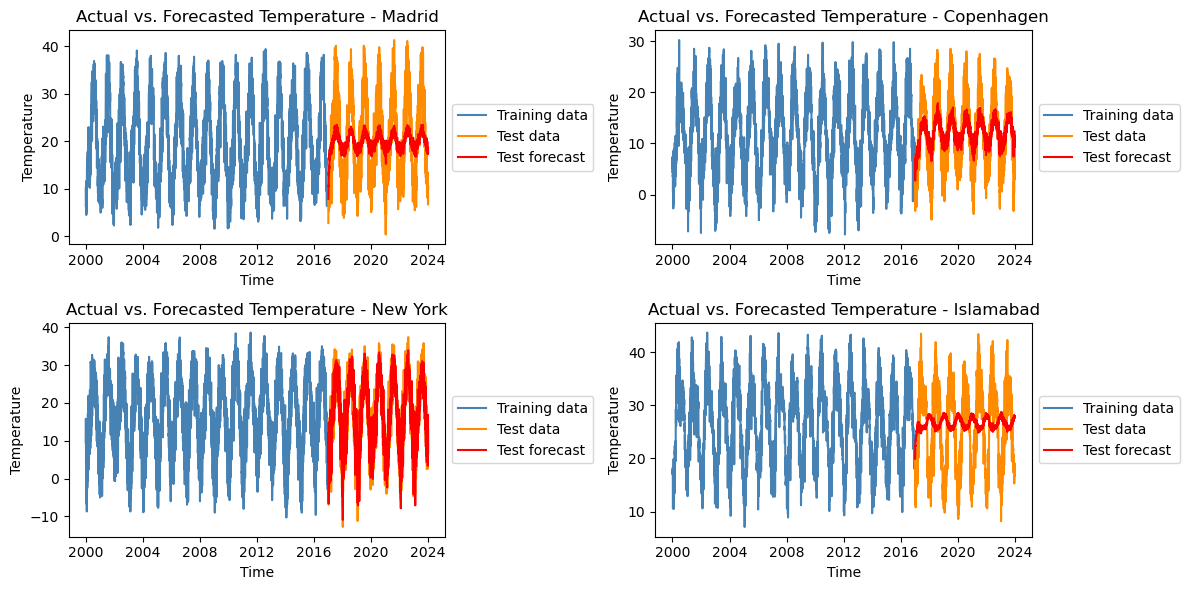

In [30]:
def generate_forecast_and_plot_for_all_data(model_fits, train_datasets, test_datasets, locations):
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    
    for model_fit, train_data, test_data, location, ax in zip(model_fits, train_datasets, test_datasets, locations, axes.flatten()):
        
        forecast_test = model_fit.forecast(steps=len(test_data), exog=test_data[['temperature_2m_min']])

        ax.plot(train_data['time'], train_data['temperature_2m_max'], label='Training data', color='steelblue')
        ax.plot(test_data['time'], test_data['temperature_2m_max'], label='Test data', color='darkorange')
        ax.plot(test_data['time'], forecast_test, label='Test forecast', color='red')
        
        ax.set_xlabel('Time')
        ax.set_ylabel('Temperature')
        ax.set_title(f'Actual vs. Forecasted Temperature - {location}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        rmse = mean_squared_error(test_data['temperature_2m_max'], forecast_test, squared=False)
        print(f"Root Mean Squared Error (RMSE) for {location}:", rmse.round(2))

    plt.tight_layout()
    plt.show()

model_fits = [model_fit_madrid, model_fit_copenhagen, model_fit_NY, model_fit_islamabad]
train_datasets = [train_data_madrid, train_data_copenhagen, train_data_NY, train_data_islamabad]
test_datasets = [test_data_madrid, test_data_copenhagen, test_data_NY, test_data_islamabad]
locations = ['Madrid', 'Copenhagen', 'New York', 'Islamabad']

generate_forecast_and_plot_for_all_data(model_fits, train_datasets, test_datasets, locations)


Before incorporating the new variable, the RMSE values for Madrid, Copenhagen, New York, and Islamabad were 9.39, 6.77, 9.71, and 7.59, respectively. After incorporating the new variable, the RMSE values changed to 7.56, 4.88, 3.04, and 8.4 for the respective cities.

Comparing the RMSE values before and after incorporating the new variable shows a significant improvement in model performance for all cities except Islamabad. For Madrid, Copenhagen, and New York, the RMSE values decreased, indicating that the model's predictions are now closer to the actual observed values. However, for Islamabad, the RMSE increased slightly, suggesting that model performance may have worsened in predicting temperatures for this city after incorporating the new variable.

#### *5.2 Using XGBoost* 

Since the ARIMA model did not provide the best results, another prediction method is explored.

For Madrid:
XGBoost RMSE (Test): 0.09351356826723672
XGBoost R squared (Test): 0.9998904269462849
For Copenhagen:
XGBoost RMSE (Test): 0.1250136058294463
XGBoost R squared (Test): 0.9997010306935096
For New York:
XGBoost RMSE (Test): 0.10460697814968614
XGBoost R squared (Test): 0.9998843986202549
For Islamabad:
XGBoost RMSE (Test): 0.09388275554900444
XGBoost R squared (Test): 0.999837998791688


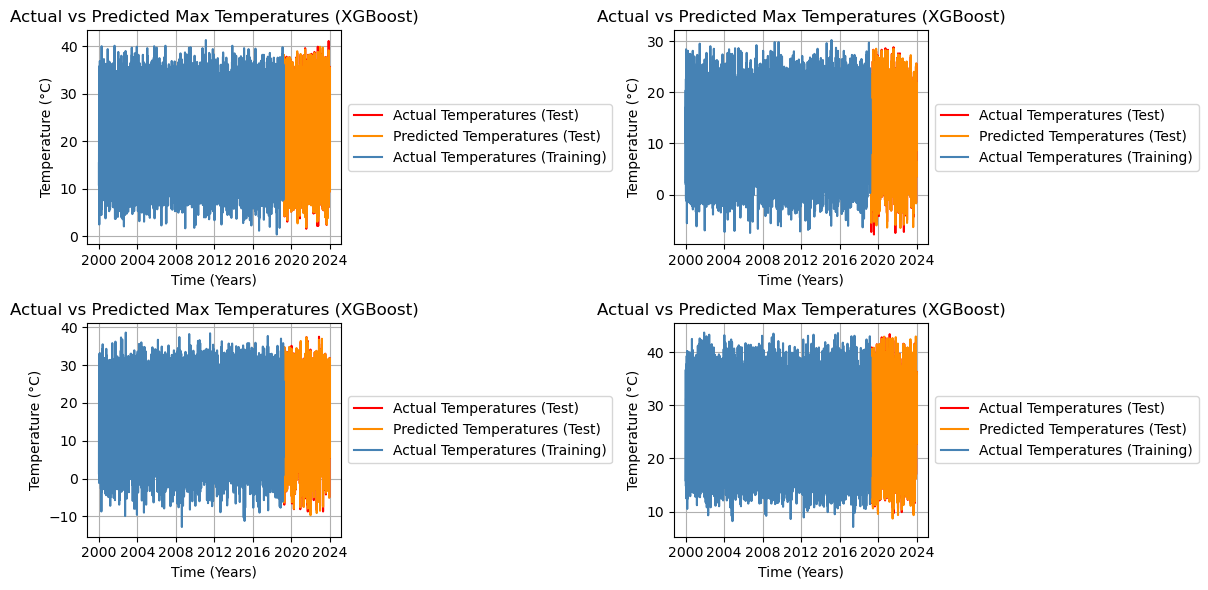

In [31]:

def predictions_XGBoost(df_list, countries, lag_values=[3, 6, 9], test_size=0.2, random_state=42):
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    
    for df, country_name, ax in zip(df_list, countries, axes.flatten()):
        for lag in lag_values:
            df[f'lag_{lag}'] = df['temperature_2m_max'].shift(lag)

        X = df[['temperature_2m_max'] + [f'lag_{lag}' for lag in lag_values]].values
        y = df['temperature_2m_max'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)

        xg_reg.fit(X_train, y_train)

        y_pred = xg_reg.predict(X_test)

        print(f'For {country_name}:')
        print('XGBoost RMSE (Test):', mean_squared_error(y_test, y_pred, squared=False))
        print('XGBoost R squared (Test):', r2_score(y_test, y_pred))

        test_time = df['time'].iloc[-len(y_test):]  
        ax.plot(test_time, y_test, label='Actual Temperatures (Test)', color='red')
        ax.plot(test_time, y_pred, label='Predicted Temperatures (Test)', color='darkorange')

        train_time = df['time'].iloc[:len(y_train)] 
        ax.plot(train_time, y_train, label='Actual Temperatures (Training)', color='steelblue')

        ax.set_xlabel('Time (Years)')
        ax.set_ylabel('Temperature (°C)')
        ax.set_title('Actual vs Predicted Max Temperatures (XGBoost)')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)
   
    
    plt.tight_layout()
    plt.show()

predictions_XGBoost([df_madrid, df_copenhagen, df_NY, df_islamabad], countries)

A significant improvement in performance is observed for the XGBoost model compared to the ARIMA model when predicting maximum temperatures. The next step is to investigate how well the XGBoost model can forecast future temperatures.

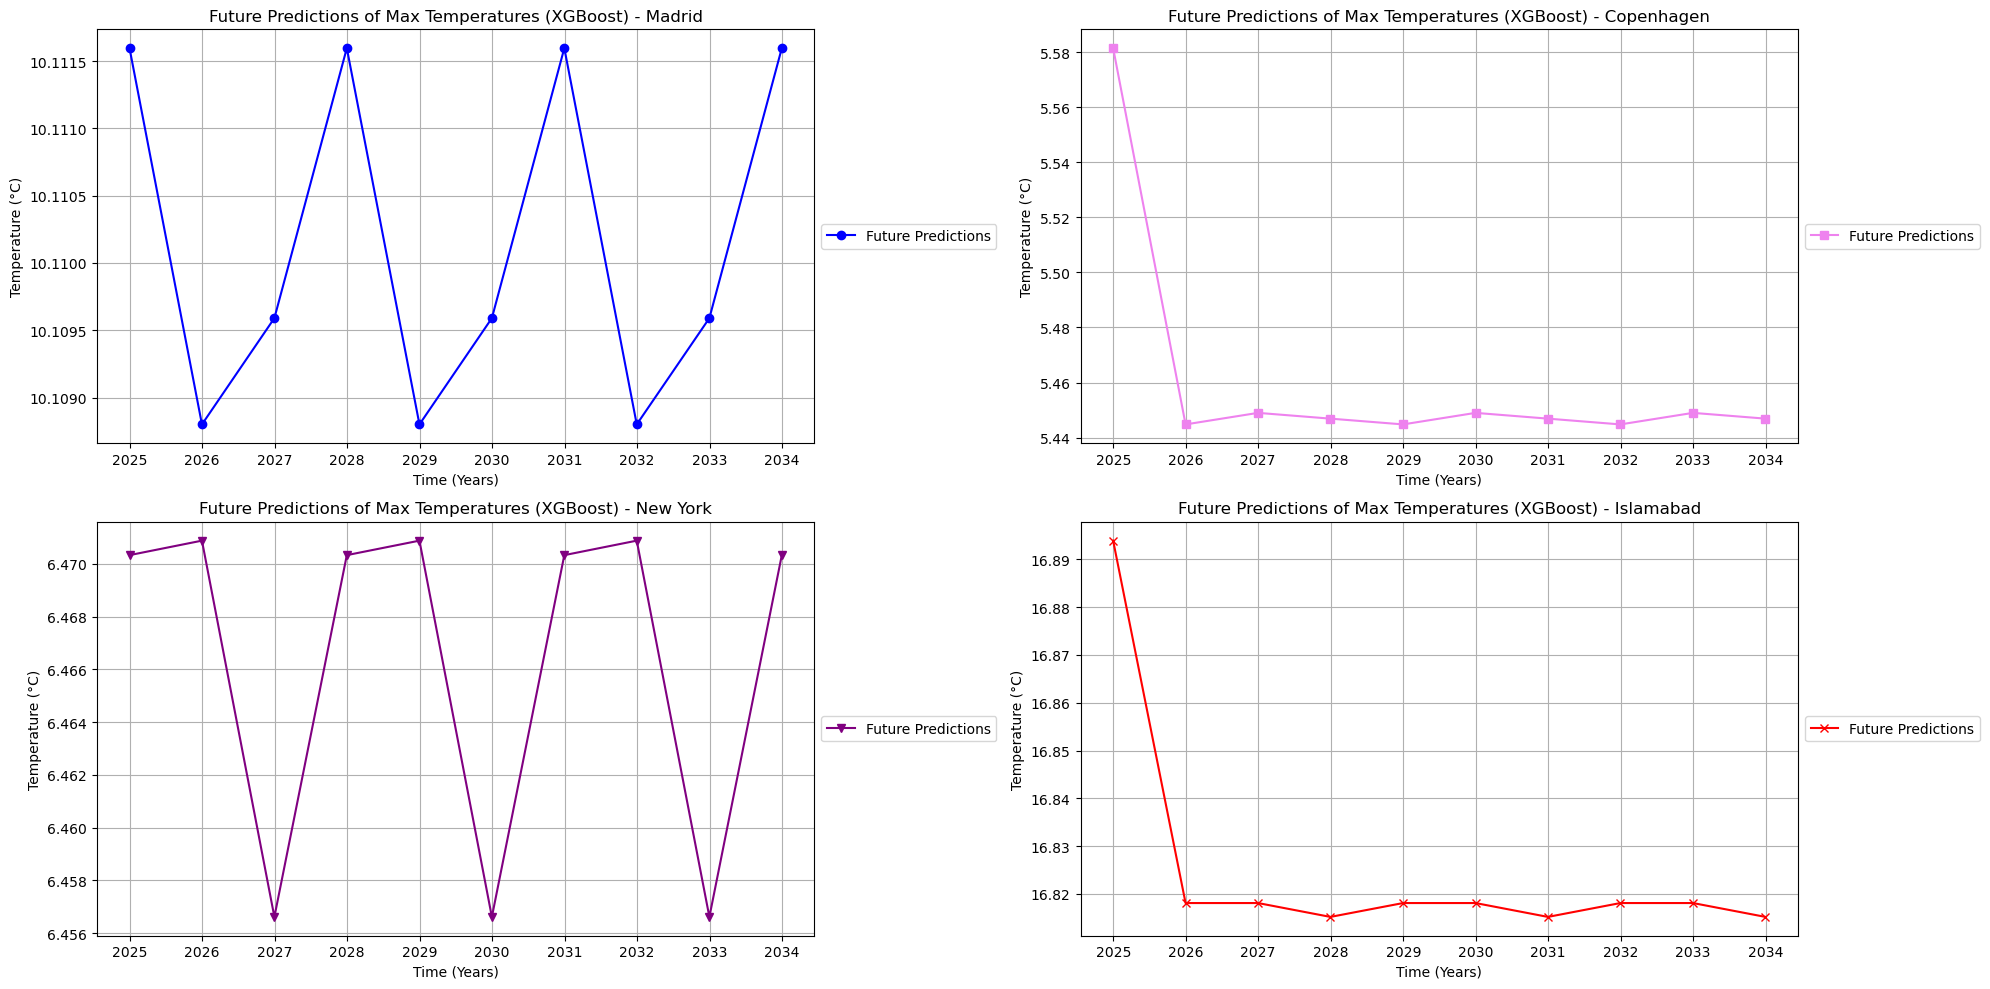

In [32]:
def future_predictions_XGBoost(df_list, countries, lag_values=[3, 6, 9], future_years=10, generic_colors=None, generic_markers=None):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))
   
    for df, country_name, color, marker, ax in zip(df_list, countries, generic_colors, generic_markers, axes.flatten()):
        for lag in lag_values:
            df[f'lag_{lag}'] = df['temperature_2m_max'].shift(lag)
 
        df.dropna(inplace=True)
 
        X = df[['temperature_2m_max'] + [f'lag_{lag}' for lag in lag_values]].values
        y = df['temperature_2m_max'].values
 
        xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
 
        xg_reg.fit(X, y)
 
        last_year_features = X[-1].reshape(1, -1)  
        future_predictions = []
        for _ in range(future_years):
            prediction = xg_reg.predict(last_year_features)[0]
            future_predictions.append(prediction)
            last_year_features[:, 1:] = np.roll(last_year_features[:, 1:], -1, axis=1)
            last_year_features[:, 0] = prediction
 
        future_years_index = pd.date_range(start=df['time'].iloc[-1], periods=future_years + 1, freq='Y')[1:]
        ax.plot(future_years_index, future_predictions, label='Future Predictions', color=color, marker=marker)
 
        ax.set_xlabel('Time (Years)')
        ax.set_ylabel('Temperature (°C)')
        ax.set_title(f'Future Predictions of Max Temperatures (XGBoost) - {country_name}')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)
   
    plt.tight_layout()
    plt.show()
 
future_predictions_XGBoost([df_madrid, df_copenhagen, df_NY, df_islamabad], countries, generic_colors=generic_colors_four, generic_markers=generic_markers)

Based on the analysis of both ARIMA and XGBoost models, predicting future temperatures accurately remains challenging. Several factors could contribute to this difficulty, such as limited data availability or the inherent complexity of the underlying patterns in the data, making them difficult to detect and forecast accurately.

# 6. Twitter and heatwave analysis

First, all libraries and dataset are imported to enable analyzing.

In [33]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [34]:
df_Twitter = pd.read_csv("The Climate Change Twitter Dataset.csv")

#### *6.1 Twitter dataset exploratory analysis*

In [35]:
df_Twitter.head(100)

created_at       id         lng        lat  \
0   2006-06-06 16:06:42+00:00     6132         NaN        NaN   
1   2006-07-23 21:52:30+00:00    13275  -73.949582  40.650104   
2   2006-08-29 01:52:30+00:00    23160         NaN        NaN   
3   2006-11-07 02:46:52+00:00    57868         NaN        NaN   
4   2006-11-27 14:27:43+00:00   304553         NaN        NaN   
..                        ...      ...         ...        ...   
95  2007-02-11 17:50:55+00:00  5431384 -122.676210  45.523450   
96  2007-02-12 06:51:49+00:00  5448722 -123.119340  49.249660   
97  2007-02-12 18:11:13+00:00  5461182         NaN        NaN   
98  2007-02-12 19:10:18+00:00  5462793         NaN        NaN   
99  2007-02-12 19:12:09+00:00  5462838   -0.125740  51.508530   

                               topic  sentiment    stance     gender  \
0                   Weather Extremes  -0.097180   neutral     female   
1                   Weather Extremes   0.575777   neutral  undefined   
2                   Weather Extremes   0.500479   neutral       male   
3                   Weather Extremes   0.032816   neutral       male   
4   Importance of Human Intervantion  -0.090428   neutral       male   
..                               ...        ...       ...        ...   
95                  Weather Extremes  -0.646426   neutral       male   
96                  Weather Extremes  -0.372242   neutral       male   
97                     Global stance   0.563522  believer       male   
98  Importance of Human Intervantion  -0.132112  believer       male   
99  Importance of Human Intervantion  -0.129530  believer       male   

    temperature_avg  aggressiveness  
0               NaN      aggressive  
1         -1.114768      aggressive  
2               NaN      aggressive  
3               NaN      aggressive  
4               NaN      aggressive  
..              ...             ...  
95         1.902093  not aggressive  
96         2.460628  not aggressive  
97              NaN      aggressive  
98              NaN      aggressive  
99         3.325016  not aggressive  

[100 rows x 10 columns]

In [36]:
num_entries = df_Twitter.shape[0]
print(num_entries)

15789411


As shown above, the dataset consists of 15,789,411 tweets on the topic of climate change. The variables in each column are defined as follows:

"created_at": The timestamp of the tweet.

"id": The unique ID of the tweet.

"lng": The longitude where the tweet was written.

"lat": The latitude where the tweet was written.

"topic": Categorization of the tweet into one of ten topics, namely: seriousness of gas emissions, importance of human intervention, global stance, significance of pollution awareness events, weather extremes, impact of resource overconsumption, Donald Trump versus science, ideological positions on global warming, politics, and undefined.

"sentiment": A score on a continuous scale ranging from -1 to 1, where values closer to 1 indicate positive sentiment, values closer to -1 indicate negative sentiment, and values near 0 indicate neutral sentiment.

"stance": Indicates if the tweet supports the belief in man-made climate change (believer), does not support the belief (denier), or neither supports nor rejects the belief (neutral).

"gender": Indicates whether the user who made the tweet is male, female, or undefined.

"temperature_avg": The temperature deviation in Celsius relative to the January 1951–December 1980 average at the time and place the tweet was written.

"aggressiveness": Indicates whether the tweet contains aggressive language or not.

In [37]:
new_york_df = df_Twitter[(df_Twitter['lat'] >= 40.4774) & (df_Twitter['lat'] <= 40.9176) & (df_Twitter['lng'] >= -74.2591) & (df_Twitter['lng'] <= -73.7002)]
copenhagen_df = df_Twitter[(df_Twitter['lat'] >= 55.5636) & (df_Twitter['lat'] <= 55.7183) & (df_Twitter['lng'] >= 12.4581)]
islamabad_df = df_Twitter[(df_Twitter['lat'] >= 33.5387) & (df_Twitter['lat'] <= 33.7393) & (df_Twitter['lng'] >= 72.8641) & (df_Twitter['lng'] <= 73.2207)]
madrid_df = df_Twitter[(df_Twitter['lat'] >= 40.3121) & (df_Twitter['lat'] <= 40.5639) & (df_Twitter['lng'] >= -3.8342) & (df_Twitter['lng'] <= -3.5215)]

Datasets are created for the tweets send in the interested regions of New York, Copenhagen, Islamabad and Madrid. 

In [38]:
new_york_df_weather = new_york_df[new_york_df["topic"].str.contains("Weather Extremes", case=False)]
copenhagen_df_weather = copenhagen_df[copenhagen_df["topic"].str.contains("Weather Extremes", case=False)]
islamabad_df_weather = islamabad_df[islamabad_df["topic"].str.contains("Weather Extremes", case=False)]
madrid_df_weather = madrid_df[madrid_df["topic"].str.contains("Weather Extremes", case=False)]

Datasets are created for tweets send in the topic Weather Extremes for each region of interest. 

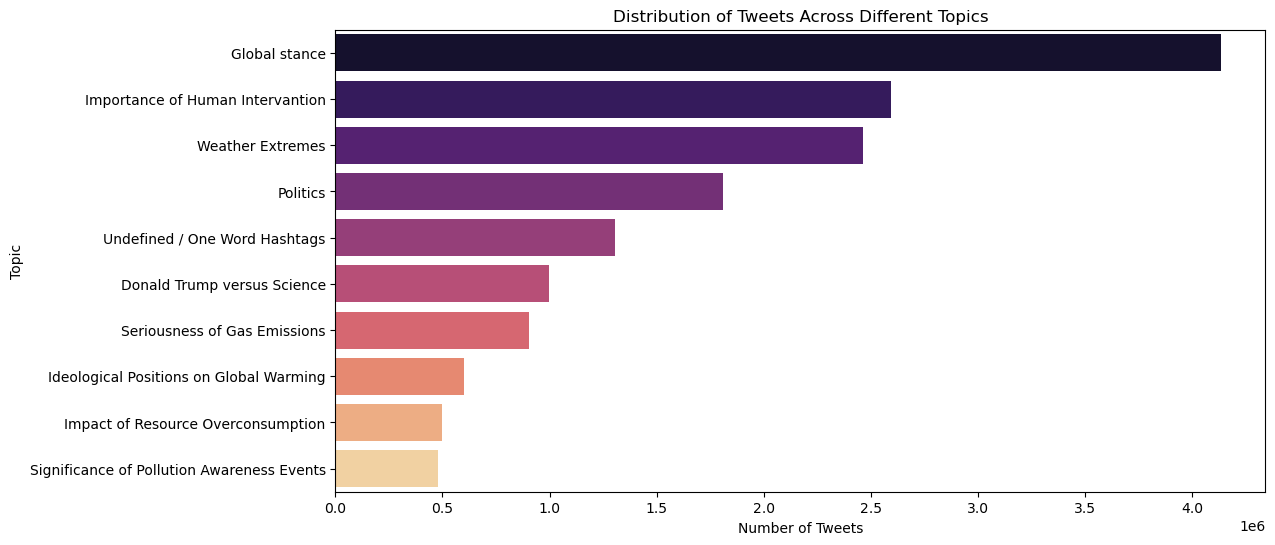

In [39]:
topic_distribution = df_Twitter['topic'].value_counts().reset_index()
topic_distribution.columns = ['topic', 'tweet_count']

plt.figure(figsize=(12, 6))
sns.barplot(x='tweet_count', y='topic', data=topic_distribution, palette='magma')
plt.xlabel('Number of Tweets')
plt.ylabel('Topic')
plt.title('Distribution of Tweets Across Different Topics')
plt.show()

In this plot the distribution of tweets about topics is shown. From the figure can be derived that tweets about the Global Stance is mostly tweeted about. But, the topic Weather Extremes is also widely discussed. This topic will also contain tweets of interest for the research about Heatwaves.

In [40]:
topic_sentiment = df_Twitter.groupby('topic')['sentiment'].mean().reset_index()
print(topic_sentiment)

                                        topic  sentiment
0                 Donald Trump versus Science  -0.159700
1                               Global stance   0.069316
2     Ideological Positions on Global Warming  -0.197715
3          Impact of Resource Overconsumption  -0.103795
4            Importance of Human Intervantion   0.069617
5                                    Politics  -0.084756
6                Seriousness of Gas Emissions  -0.047572
7  Significance of Pollution Awareness Events  -0.029122
8               Undefined / One Word Hashtags   0.241091
9                            Weather Extremes  -0.081851


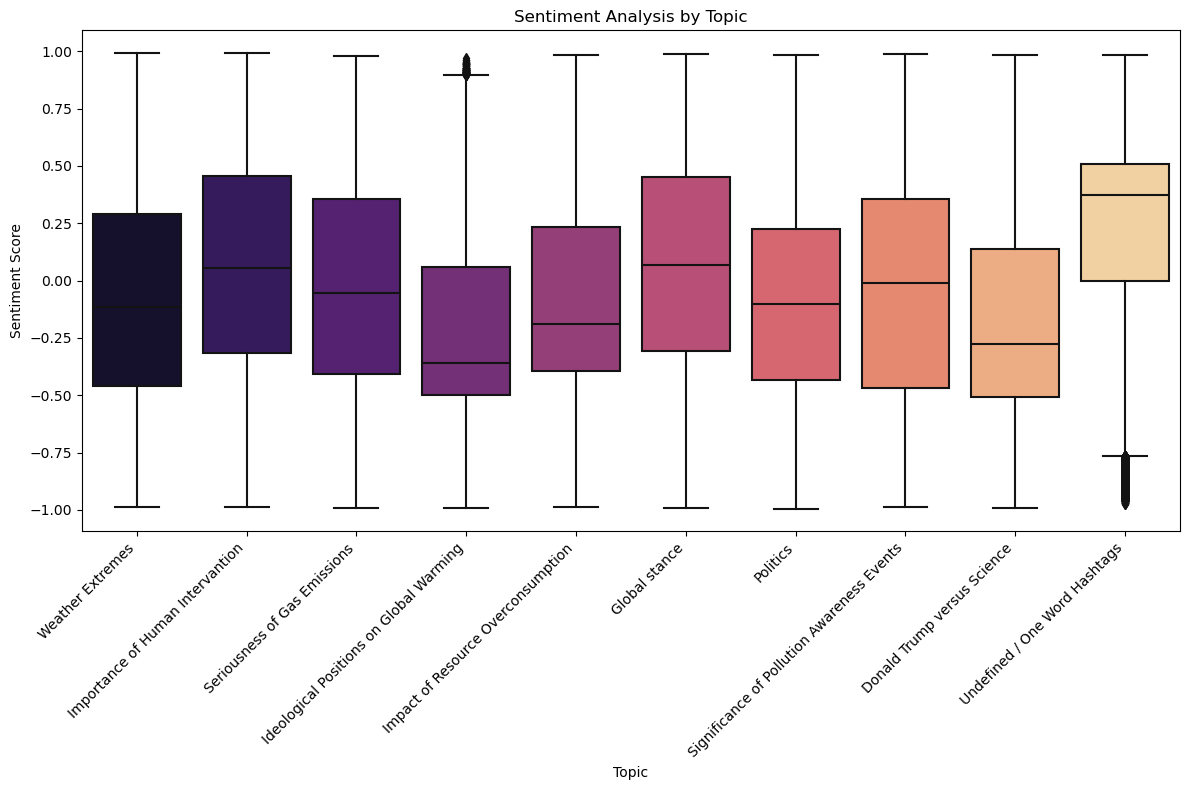

In [41]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='topic', y='sentiment', data=df_Twitter, palette='magma')
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis by Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The boxplots show the mean sentiment in each topic. Although, the sentiment will differ from day to day the plot gives a good overview of the general sentiment about topics. The things that spring out is that the topic Ideological Positions on Global Warming has a relativly negative sentiment (see median). This might be explained that this topic will generate discussion due to different opinions. The weather extremes have a negative median sentiment but nothing significant.

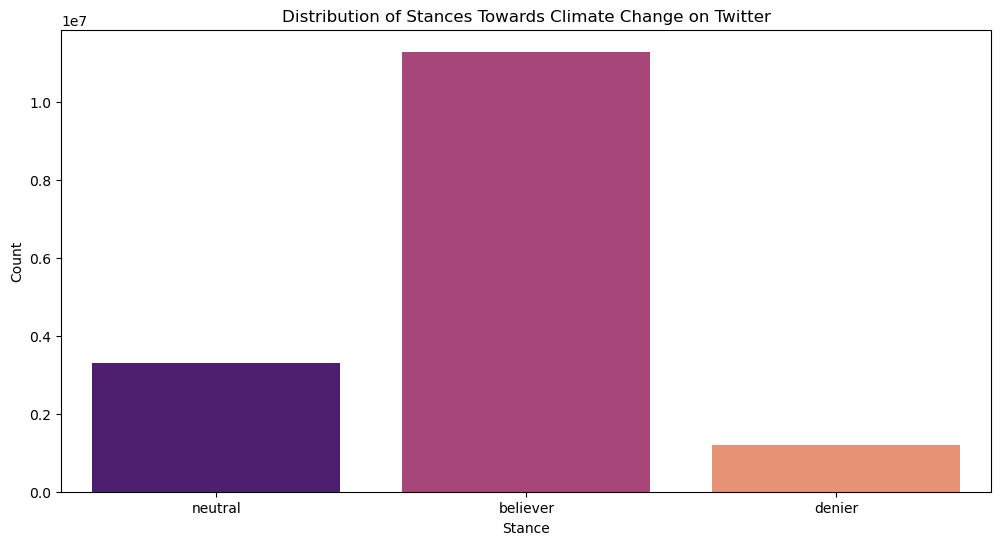

In [42]:
plt.figure(figsize=(12, 6))
sns.countplot(x='stance', data=df_Twitter, palette='magma')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.title('Distribution of Stances Towards Climate Change on Twitter')
plt.show()

Most tweets about climat change are send by people who are classified as a believer. The neutral and deniers have much less data. 

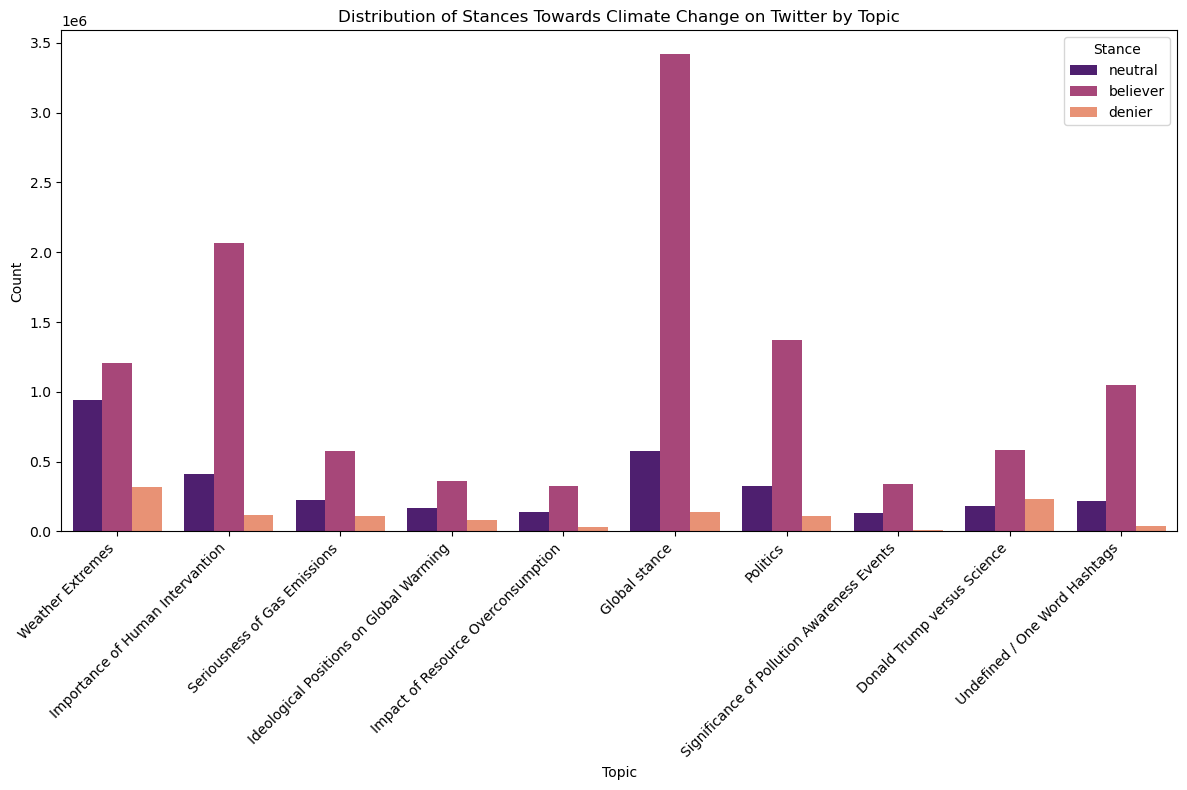

In [43]:
plt.figure(figsize=(12, 8))
sns.countplot(x='topic', hue='stance', data=df_Twitter, palette='magma')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.title('Distribution of Stances Towards Climate Change on Twitter by Topic')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stance')
plt.tight_layout()
plt.show()

The figure aboves shows the amount of neutral, believers or deniers of climate change tweeting on each topic. In the weather extremes there are clearly more neutral and believers tweeting about it. In each topic the believers are mostly in the majority. The deniers are only in the topic Trump VS science in the majority over the neutral stance tweeters. This might be caused due to the controversy and followers surrounding Trump.

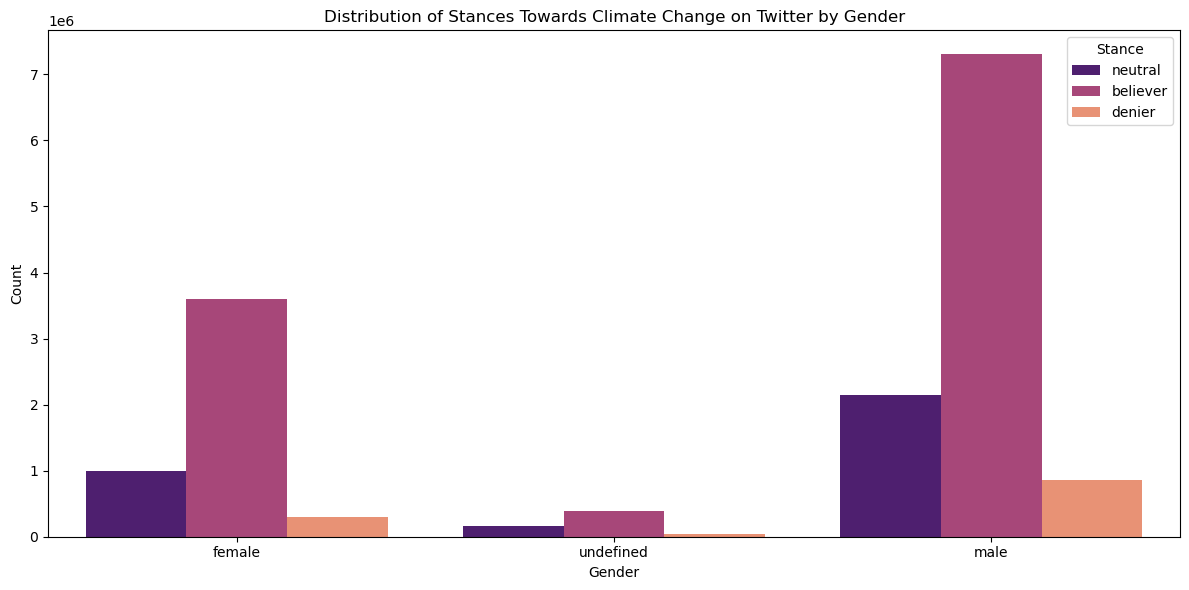

In [44]:
plt.figure(figsize=(12, 6))
sns.countplot(x='gender', hue='stance', data=df_Twitter, palette='magma')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Stances Towards Climate Change on Twitter by Gender')
plt.legend(title='Stance')
plt.tight_layout()
plt.show()

The figure shows that between gender no real differences in distribution are present about the stance. The general amount of tweets send by a male is larger in the dataset, but the distribution is equal between genders.

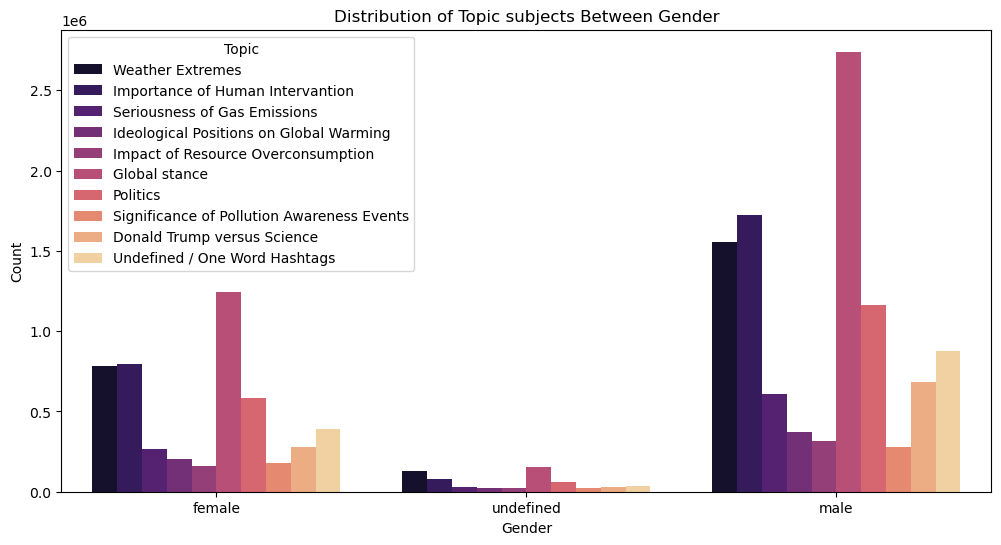

In [45]:
plt.figure(figsize=(12, 6))
sns.countplot(x='gender', hue='topic', data=df_Twitter, palette='magma')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Topic subjects Between Gender')
plt.legend(title='Topic', loc='upper left')
plt.show()

Also here similar distribution about tweet frequency in the topics can be seen between genders. Both genders seem to have equal interest in the topics and no differences can be spotted here.

In [46]:
madrid_df_weather['created_at'] = pd.to_datetime(madrid_df_weather['created_at'])
islamabad_df_weather['created_at'] = pd.to_datetime(islamabad_df_weather['created_at'])
copenhagen_df_weather['created_at'] = pd.to_datetime(copenhagen_df_weather['created_at'])
new_york_df_weather['created_at'] = pd.to_datetime(new_york_df_weather['created_at'])
madrid_df['created_at'] = pd.to_datetime(madrid_df['created_at'])
islamabad_df['created_at'] = pd.to_datetime(islamabad_df['created_at'])
copenhagen_df['created_at'] = pd.to_datetime(copenhagen_df['created_at'])
new_york_df['created_at'] = pd.to_datetime(new_york_df['created_at'])

Frequency_ExWeTweets_MDR = madrid_df_weather.groupby(madrid_df_weather["created_at"].dt.year)['id'].count()
Frequency_ExWeTweets_CPH = copenhagen_df_weather.groupby(copenhagen_df_weather["created_at"].dt.year)['id'].count()
Frequency_ExWeTweets_NY = new_york_df_weather.groupby(new_york_df_weather["created_at"].dt.year)['id'].count()
Frequency_ExWeTweets_ISL= islamabad_df_weather.groupby(islamabad_df_weather["created_at"].dt.year)['id'].count()

Frequency_ClimateTweets_CPH = copenhagen_df.groupby(copenhagen_df["created_at"].dt.year)['id'].count()
Frequency_ClimateTweets_MDR = madrid_df.groupby(madrid_df["created_at"].dt.year)['id'].count()
Frequency_ClimateTweets_NY = new_york_df.groupby(new_york_df["created_at"].dt.year)['id'].count()
Frequency_ClimateTweets_ISL = islamabad_df.groupby(islamabad_df["created_at"].dt.year)['id'].count()

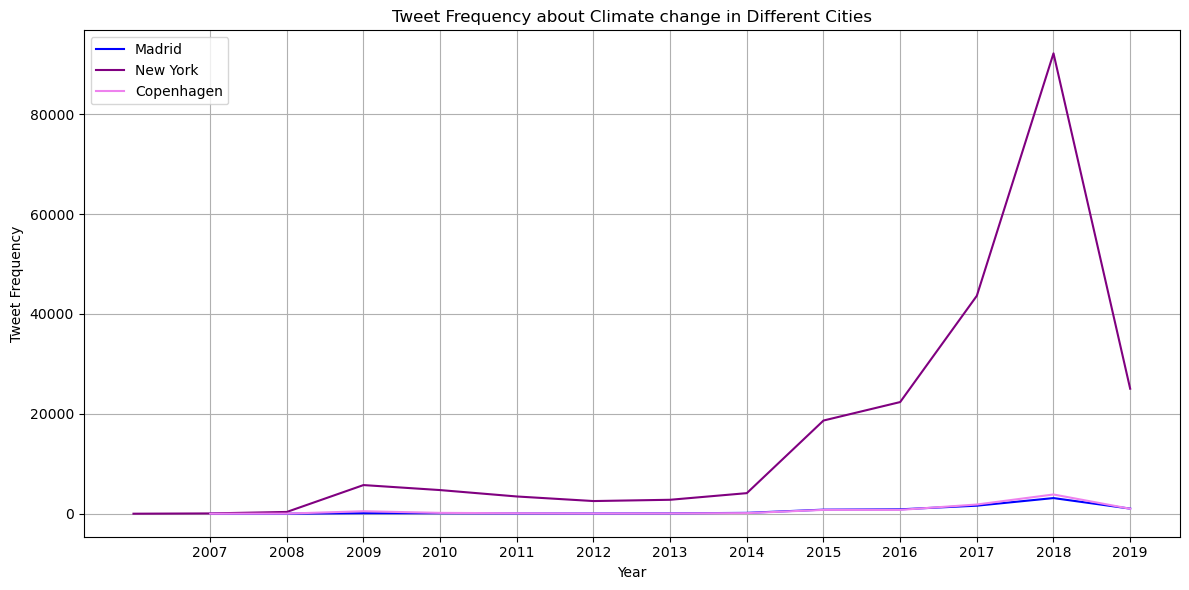

In [47]:
plt.figure(figsize=(12, 6))

plt.plot(Frequency_ClimateTweets_MDR.index, Frequency_ClimateTweets_MDR.values, label='Madrid', color='blue')
#plt.plot(Frequency_ClimateTweets_ISL.index, Frequency_ClimateTweets_ISL.values, label='Islamabad', color='red')
plt.plot(Frequency_ClimateTweets_NY.index, Frequency_ClimateTweets_NY.values, label='New York', color='purple')
plt.plot(Frequency_ClimateTweets_CPH.index, Frequency_ClimateTweets_CPH.values, label='Copenhagen', color='violet')

plt.title('Tweet Frequency about Climate change in Different Cities')
plt.xlabel('Year')
plt.ylabel('Tweet Frequency')
plt.legend()
plt.grid(True)
plt.xticks(Frequency_ExWeTweets_MDR.index)
plt.tight_layout()
plt.show()

What can be identified in the plot is that in New York much more tweets are sent than for Madrid or Copenhagen. The tweets in Islamabad are not timestamped so the trend over time cannot be shown. 

In [48]:
df_Twitter['created_at'] = pd.to_datetime(df_Twitter['created_at'])
df_Twitter['month'] = df_Twitter['created_at'].dt.month
df_Twitter['year'] = df_Twitter['created_at'].dt.year

data_filtered = df_Twitter[df_Twitter['stance'].isin(['believer', 'denier'])]
grouped = data_filtered.groupby(['year', 'month', 'stance']).size().unstack(fill_value=0)
grouped['denier_to_believer_ratio'] = grouped['denier'] / grouped['believer']
grouped.fillna(0, inplace=True)

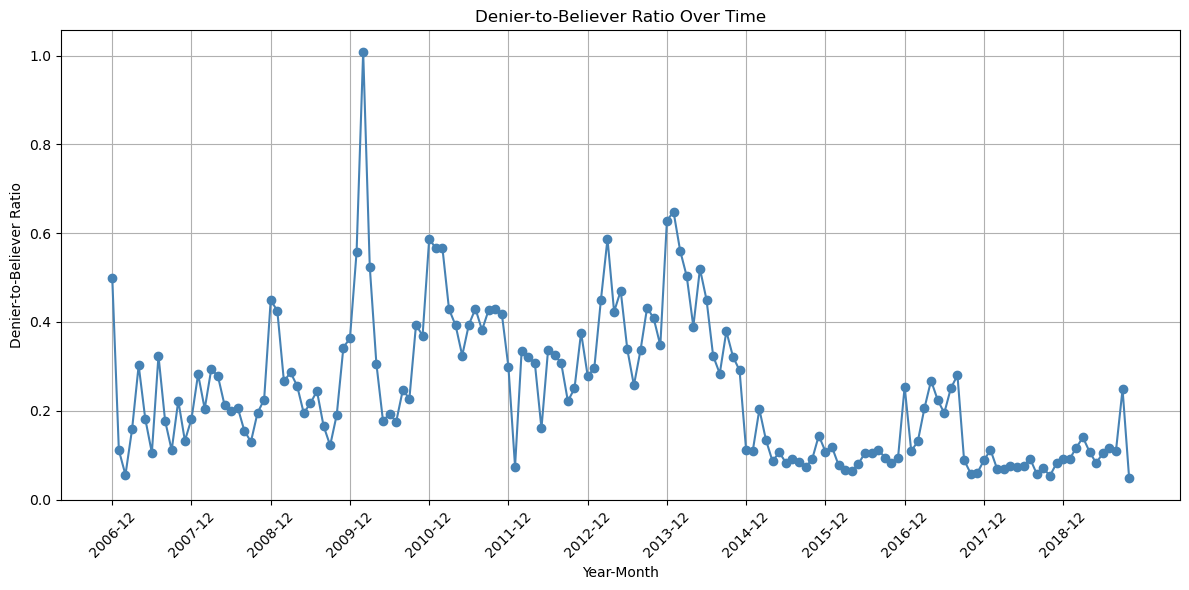

In [49]:
grouped['year_month'] = grouped.index.map(lambda x: f"{x[0]}-{x[1]:02d}")
unique_years = sorted(grouped.index.get_level_values('year').unique())

plt.figure(figsize=(12, 6))
plt.plot(grouped['year_month'], grouped['denier_to_believer_ratio'], marker='o', linestyle='-', color='steelblue')
plt.title('Denier-to-Believer Ratio Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Denier-to-Believer Ratio')
plt.xticks(grouped['year_month'][::12], rotation=45) 
plt.grid(True)
plt.tight_layout()
plt.show()

Overall, a decrease in the denier-to-believer ratio suggests a shift towards greater acceptance or acknowledgment of the reality of climate change within the population, regardless of whether it's driven by a decrease in deniers, an increase in believers, or a combination of both factors.

#### *6.2 Sentiment analysis*
This section focuses on the analysis of tweets related to heatwaves in four cities: New York, Copenhagen, Madrid, and Islamabad. The analysis provides insights into the impact of heatwaves on public opinion and identifies trends related to this significant environmental phenomenon.

##### *6.2.1 New York analysis*
##### *Article analysis*
The analysis begins with New York. Since it is a city known for its media presence, news coverage related to heatwaves is also analyzed. In addition to tweet data, data on articles regarding heatwaves is obtained using the API of one of the world's most renowned and influential news organizations, The New York Times.

In [50]:
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

params = {
    'q': "heat wave",             
    'fq': "headline:\"New York\" AND headline:\"heat wave\"",  
    'api-key': "jX0yT67TCUAvUCZxzOjSvvCd7lwRHwL2", 
    'begin_date': '20000101',   
    'end_date': '20231231',
    'sort': 'newest',  
    'page': 0,                    
    'page_limit': 5              
}

articles = []

while params['page'] < params['page_limit']:
    response = requests.get(url, params=params)
    result = response.json()

    articles.extend(result['response']['docs'])

    params['page'] += 1

articles_sorted = sorted(articles, key=lambda x: x['pub_date'])

for res in articles_sorted:
    pub_date = datetime.strptime(res['pub_date'], "%Y-%m-%dT%H:%M:%S%z").strftime("%Y-%m-%d")
    print("Publication date: %s, Title: %s" % (pub_date, res['headline']['main']))
    
print("Total %d news retrieved" % len(articles_sorted))

Publication date: 2004-07-19, Title: 1954:New York Heat Wave : IN OUR PAGES:100, 75 AND 50 YEARS AGO
Publication date: 2004-07-19, Title: 1954:New York Heat Wave : IN OUR PAGES:100, 75 AND 50 YEARS AGO
Publication date: 2006-08-01, Title: New York’s Heat Wave Prompts Record Power Use
Publication date: 2006-08-04, Title: 10 Dead From Heat Wave in New York
Publication date: 2006-08-10, Title: Manhattan: Heat Wave Death Toll Rises
Publication date: 2006-08-17, Title: Manhattan: 4 More Deaths Tied to Heat Wave
Publication date: 2006-11-16, Title: Heat Wave Was a Factor in 140 Deaths, New York Says
Publication date: 2006-11-16, Title: Heat Wave Was a Factor in 140 Deaths, New York Says
Publication date: 2008-06-10, Title: Heat Wave Blankets New York City
Publication date: 2010-07-06, Title: Send Us Your Photos of the New York Heat Wave
Publication date: 2010-07-06, Title: New York Wilts Under Record-Breaking Heat Wave
Publication date: 2010-07-08, Title: Heat Wave Continues in New York 
Pub

The focus of the API requests is on the titles rather than the full content of the articles. Articles are retrieved based on headlines containing keywords such as "New York" and "heat wave," including their variations or abbreviations. Another important parameter is the publication dates of these articles, which are matched to the period of the initial weather data to gather as many relevant articles as possible. A limitation encountered was a restriction on the number of articles that could be requested per minute, requiring parts of the article request process to be manually repeated.

In [51]:
df_articles_obtained = pd.DataFrame([
    {
        'time': datetime.strptime(res['pub_date'], "%Y-%m-%dT%H:%M:%S%z").strftime("%Y-%m-%d"),
        'Title': res['headline']['main']
    }
    for res in articles_sorted
])

df_articles_obtained.to_csv("heatwave.csv", index=False)

In [52]:
df1 = pd.read_csv('heatwave.csv')
df2 = pd.read_csv('heatwave2.csv')
df3 = pd.read_csv('heatwave3.csv')

df_articles = pd.concat([df1, df2, df3], ignore_index=True)

df_articles = df_articles.drop_duplicates()

print(df_articles.shape)
df_articles

(27, 2)


time                                              Title
0   2004-07-19  1954:New York Heat Wave : IN OUR PAGES:100, 75...
2   2006-08-01      New York’s Heat Wave Prompts Record Power Use
3   2006-08-04                 10 Dead From Heat Wave in New York
4   2006-08-10              Manhattan: Heat Wave Death Toll Rises
5   2006-08-17         Manhattan: 4 More Deaths Tied to Heat Wave
6   2006-11-16  Heat Wave Was a Factor in 140 Deaths, New York...
8   2008-06-10                   Heat Wave Blankets New York City
9   2010-07-06      Send Us Your Photos of the New York Heat Wave
10  2010-07-06     New York Wilts Under Record-Breaking Heat Wave
11  2010-07-08                   Heat Wave Continues in New York 
12  2013-07-15                          New York Today: Heat Wave
13  2013-07-25                    New York Today: What Heat Wave?
14  2015-02-20  New York’s Forecast: Rising Seas, Continual He...
15  2015-07-29                 New York Today: Ride the Heat Wave
16  2015-09-16                  1915: New York Gasps in Heat Wave
17  2017-06-13  New York Today: Staying Healthy During a Heat ...
18  2018-08-08              New York Today: Eating in a Heat Wave
19  2019-07-16                 Heat Wave Is Hitting New York City
20  2019-07-21  Amid Heat Wave in New York, 50,000 Lose Electr...
21  2021-08-11  Alerts from coast to coast: Seattle and Portla...
22  2022-07-18  New York City Will Get Its Own Heat Wave This ...
23  2022-07-19  New York City Opens Cooling Centers as It Brac...
24  2022-07-23  One Day in the Heat: What Cooling Off Looks an...
25  2022-07-29  A heat wave stirs drought conditions in parts ...
26  2023-09-07  Back to School or Back to Summer? A Heat Wave ...
27  2006-08-01           As Heat Wave Looms, N.Y. Cuts Energy Use
29  2019-07-19  Heat Wave N.Y.C.: OZY Fest and Triathlon Canceled

After obtaining a total of 27 articles, the titles from each request were saved in dataframes and then merged into a single dataframe to begin the analysis.

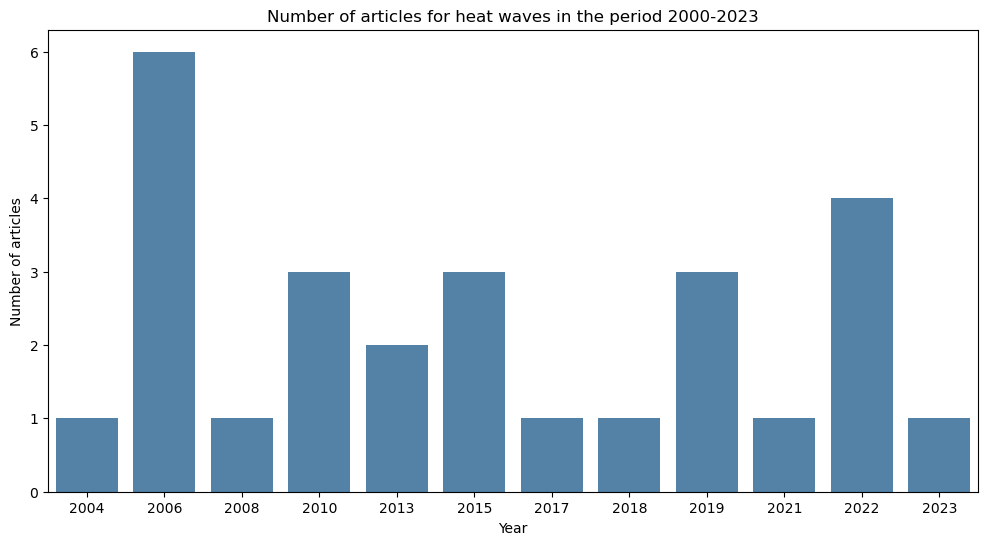

In [53]:
df_articles['time'] = pd.to_datetime(df_articles['time'])

articles = df_articles['time'].dt.year.value_counts().sort_index().reset_index()
articles.columns = ['Year', 'Number of articles']

plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Number of articles', data=articles, color='steelblue')
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Number of articles for heat waves in the period 2000-2023')
plt.show()

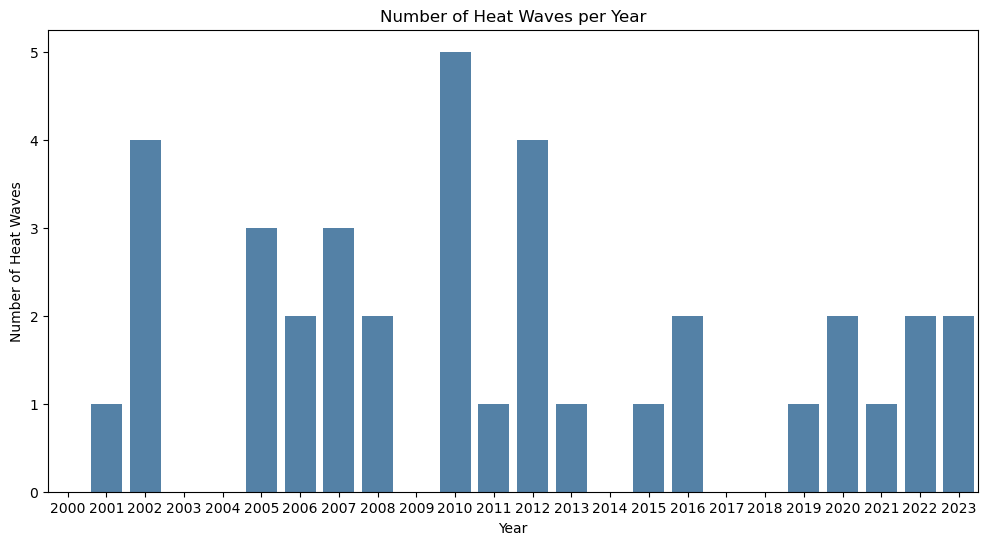

In [54]:
df_weather_NY = pd.read_csv('NY_2000-2023.csv')
df_weather_NY['time'] = pd.to_datetime(df_weather_NY['time'])
heatwave_data_NY = []

for year in df_weather_NY['time'].dt.year.unique():
    
    heatwave_num = heat_wave_counter(heat_wave_detector(df_weather_NY, 32.2, 3, year, year))
    heatwave_data_NY.append({'Year': year, 'Heat Waves': heatwave_num})
    
heatwave_data_NY = pd.DataFrame(heatwave_data_NY)

plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Heat Waves', data=heatwave_data_NY, color='steelblue')
plt.title('Number of Heat Waves per Year')
plt.xlabel('Year')
plt.ylabel('Number of Heat Waves')
plt.show()

In [55]:
ny_heatwaves = heat_wave_detector(df_weather_NY, 32.2, 3, 2000, 2023)

print("Number of heat waves in NY during the period 2000-2023:", heat_wave_counter(ny_heatwaves))

Number of heat waves in NY during the period 2000-2023: 37


From the last two plots, it can be observed that there is no immediate correlation between the number of articles published and the number of heatwaves. The analysis then continues by examining the periods during which these articles were published.

In [56]:
temps_and_titles = pd.merge(df_weather_NY, df_articles, on='time')

temps_and_titles = temps_and_titles[['time', 'temperature_2m_max', 'Title']]

temps_and_titles

time  temperature_2m_max  \
0  2004-07-19                26.1   
1  2006-08-01                36.4   
2  2006-08-01                36.4   
3  2006-08-04                31.3   
4  2006-08-10                29.0   
5  2006-08-17                28.8   
6  2006-11-16                19.4   
7  2008-06-10                33.9   
8  2010-07-06                38.4   
9  2010-07-06                38.4   
10 2010-07-08                29.1   
11 2013-07-15                32.9   
12 2013-07-25                20.7   
13 2015-02-20                -9.0   
14 2015-07-29                32.7   
15 2015-09-16                27.7   
16 2017-06-13                34.2   
17 2018-08-08                30.3   
18 2019-07-16                33.0   
19 2019-07-19                33.0   
20 2019-07-21                34.3   
21 2021-08-11                31.8   
22 2022-07-18                30.1   
23 2022-07-19                33.7   
24 2022-07-23                34.4   
25 2022-07-29                30.6   
26 2023-09-07                35.1   

                                                Title  
0   1954:New York Heat Wave : IN OUR PAGES:100, 75...  
1       New York’s Heat Wave Prompts Record Power Use  
2            As Heat Wave Looms, N.Y. Cuts Energy Use  
3                  10 Dead From Heat Wave in New York  
4               Manhattan: Heat Wave Death Toll Rises  
5          Manhattan: 4 More Deaths Tied to Heat Wave  
6   Heat Wave Was a Factor in 140 Deaths, New York...  
7                    Heat Wave Blankets New York City  
8       Send Us Your Photos of the New York Heat Wave  
9      New York Wilts Under Record-Breaking Heat Wave  
10                   Heat Wave Continues in New York   
11                          New York Today: Heat Wave  
12                    New York Today: What Heat Wave?  
13  New York’s Forecast: Rising Seas, Continual He...  
14                 New York Today: Ride the Heat Wave  
15                  1915: New York Gasps in Heat Wave  
16  New York Today: Staying Healthy During a Heat ...  
17              New York Today: Eating in a Heat Wave  
18                 Heat Wave Is Hitting New York City  
19  Heat Wave N.Y.C.: OZY Fest and Triathlon Canceled  
20  Amid Heat Wave in New York, 50,000 Lose Electr...  
21  Alerts from coast to coast: Seattle and Portla...  
22  New York City Will Get Its Own Heat Wave This ...  
23  New York City Opens Cooling Centers as It Brac...  
24  One Day in the Heat: What Cooling Off Looks an...  
25  A heat wave stirs drought conditions in parts ...  
26  Back to School or Back to Summer? A Heat Wave ...

In [57]:
perc = len(temps_and_titles[temps_and_titles['temperature_2m_max'] >= 30]) / len(temps_and_titles) * 100

print("%.2f%% of these articles were published during a hot period" % perc)

70.37% of these articles were published during a hot period


In [58]:
temps_and_titles['During_heat_wave'] = ''

for date in ny_heatwaves:
    temps_and_titles.loc[temps_and_titles['time'] == date, 'During_heat_wave'] = 'yes'
    
perc2 = len(temps_and_titles[temps_and_titles['During_heat_wave'] == 'yes']) / len(temps_and_titles) * 100

temps_and_titles

time  temperature_2m_max  \
0  2004-07-19                26.1   
1  2006-08-01                36.4   
2  2006-08-01                36.4   
3  2006-08-04                31.3   
4  2006-08-10                29.0   
5  2006-08-17                28.8   
6  2006-11-16                19.4   
7  2008-06-10                33.9   
8  2010-07-06                38.4   
9  2010-07-06                38.4   
10 2010-07-08                29.1   
11 2013-07-15                32.9   
12 2013-07-25                20.7   
13 2015-02-20                -9.0   
14 2015-07-29                32.7   
15 2015-09-16                27.7   
16 2017-06-13                34.2   
17 2018-08-08                30.3   
18 2019-07-16                33.0   
19 2019-07-19                33.0   
20 2019-07-21                34.3   
21 2021-08-11                31.8   
22 2022-07-18                30.1   
23 2022-07-19                33.7   
24 2022-07-23                34.4   
25 2022-07-29                30.6   
26 2023-09-07                35.1   

                                                Title During_heat_wave  
0   1954:New York Heat Wave : IN OUR PAGES:100, 75...                   
1       New York’s Heat Wave Prompts Record Power Use              yes  
2            As Heat Wave Looms, N.Y. Cuts Energy Use              yes  
3                  10 Dead From Heat Wave in New York                   
4               Manhattan: Heat Wave Death Toll Rises                   
5          Manhattan: 4 More Deaths Tied to Heat Wave                   
6   Heat Wave Was a Factor in 140 Deaths, New York...                   
7                    Heat Wave Blankets New York City                   
8       Send Us Your Photos of the New York Heat Wave              yes  
9      New York Wilts Under Record-Breaking Heat Wave              yes  
10                   Heat Wave Continues in New York                    
11                          New York Today: Heat Wave              yes  
12                    New York Today: What Heat Wave?                   
13  New York’s Forecast: Rising Seas, Continual He...                   
14                 New York Today: Ride the Heat Wave                   
15                  1915: New York Gasps in Heat Wave                   
16  New York Today: Staying Healthy During a Heat ...                   
17              New York Today: Eating in a Heat Wave                   
18                 Heat Wave Is Hitting New York City                   
19  Heat Wave N.Y.C.: OZY Fest and Triathlon Canceled              yes  
20  Amid Heat Wave in New York, 50,000 Lose Electr...                   
21  Alerts from coast to coast: Seattle and Portla...                   
22  New York City Will Get Its Own Heat Wave This ...              yes  
23  New York City Opens Cooling Centers as It Brac...              yes  
24  One Day in the Heat: What Cooling Off Looks an...              yes  
25  A heat wave stirs drought conditions in parts ...                   
26  Back to School or Back to Summer? A Heat Wave ...

In [59]:
print("%.2f%% of these articles were published during a heat wave" % perc2)

33.33% of these articles were published during a heat wave


The majority of articles published by The New York Times were during periods of hot weather, but not necessarily during a heatwave. Specifically, only one-third of these articles were published during a heatwave, indicating that heatwaves may not consistently be considered headline-worthy for regular publication.

In [60]:
def preprocess(commentBody):  
    commentBody = commentBody.str.replace('’', ' ')  
    return commentBody

new_titles = preprocess(temps_and_titles['Title'])
new_titles = pd.DataFrame(new_titles)

new_titles['sentiment_textblob'] = new_titles.Title.map(lambda text: TextBlob(text).sentiment.polarity)

new_titles['sentiment_vader'] = new_titles.Title.map(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'])

new_titles

Title  sentiment_textblob  \
0   1954:New York Heat Wave : IN OUR PAGES:100, 75...            0.000000   
1       New York s Heat Wave Prompts Record Power Use            0.136364   
2            As Heat Wave Looms, N.Y. Cuts Energy Use            0.000000   
3                  10 Dead From Heat Wave in New York           -0.031818   
4               Manhattan: Heat Wave Death Toll Rises            0.000000   
5          Manhattan: 4 More Deaths Tied to Heat Wave            0.500000   
6   Heat Wave Was a Factor in 140 Deaths, New York...            0.136364   
7                    Heat Wave Blankets New York City            0.136364   
8       Send Us Your Photos of the New York Heat Wave            0.136364   
9      New York Wilts Under Record-Breaking Heat Wave            0.136364   
10                   Heat Wave Continues in New York             0.136364   
11                          New York Today: Heat Wave            0.136364   
12                    New York Today: What Heat Wave?            0.136364   
13  New York s Forecast: Rising Seas, Continual He...           -0.025568   
14                 New York Today: Ride the Heat Wave            0.136364   
15                  1915: New York Gasps in Heat Wave            0.136364   
16  New York Today: Staying Healthy During a Heat ...            0.318182   
17              New York Today: Eating in a Heat Wave            0.136364   
18                 Heat Wave Is Hitting New York City            0.136364   
19  Heat Wave N.Y.C.: OZY Fest and Triathlon Canceled            0.000000   
20  Amid Heat Wave in New York, 50,000 Lose Electr...            0.136364   
21  Alerts from coast to coast: Seattle and Portla...            0.136364   
22  New York City Will Get Its Own Heat Wave This ...            0.368182   
23  New York City Opens Cooling Centers as It Brac...            0.136364   
24  One Day in the Heat: What Cooling Off Looks an...            0.136364   
25  A heat wave stirs drought conditions in parts ...            0.136364   
26  Back to School or Back to Summer? A Heat Wave ...           -0.040909   

    sentiment_vader  
0            0.0000  
1            0.0000  
2           -0.1779  
3           -0.6486  
4           -0.5994  
5            0.0000  
6            0.0000  
7            0.0000  
8            0.0000  
9            0.0000  
10           0.0000  
11           0.0000  
12           0.0000  
13           0.3832  
14           0.0000  
15           0.0000  
16           0.4019  
17           0.0000  
18           0.0000  
19           0.0000  
20          -0.4019  
21           0.0000  
22           0.0000  
23           0.0000  
24           0.3612  
25           0.0000  
26           0.0000

In [61]:
new_titles['sentiment_vader'].mean()

-0.025240740740740748

Finally, the article sentiment analysis is conducted using two techniques: TextBlob and Vader. TextBlob is a Python library for processing textual data, while Vader is a pre-trained sentiment analysis model that provides sentiment scores for a given text. Both return a value between -1 (negative sentiment) and 1 (positive sentiment), indicating the overall sentiment of the text. The difference is that the value from Vader is a compound score, which combines all other sentiment scores (positive, neutral, and negative). The results indicate that the Vader model appears to be more accurate.

##### *Article analysis conclusion*
Based on the Vader model, the majority of articles show a neutral sentiment. After calculating the mean of the scores, the overall sentiment score is -0.025, indicating that articles published by The New York Times about heatwaves in New York City generally exhibit a slightly negative to neutral sentiment. This outcome aligns with expectations, as a reputable publisher like The New York Times tends to provide factual information in a neutral tone, prioritizing objectivity. Any observed negativity in the coverage of heatwaves is likely driven by genuine concerns about the associated risks and impacts, both locally and globally.

##### *Tweet Analysis for New York*

In [62]:
mean_sentiment_per_day =  new_york_df_weather.groupby("created_at")["sentiment"].mean()
new_york_df['created_at'] = pd.to_datetime(new_york_df['created_at'])
new_york_df_weather['created_at'] = pd.to_datetime(new_york_df_weather['created_at'])
mean_sentiment_year_NY = new_york_df_weather.groupby(new_york_df_weather['created_at'].dt.year)['sentiment'].mean()
general_sentiment_year_NY = new_york_df.groupby(new_york_df["created_at"].dt.year)["sentiment"].mean()

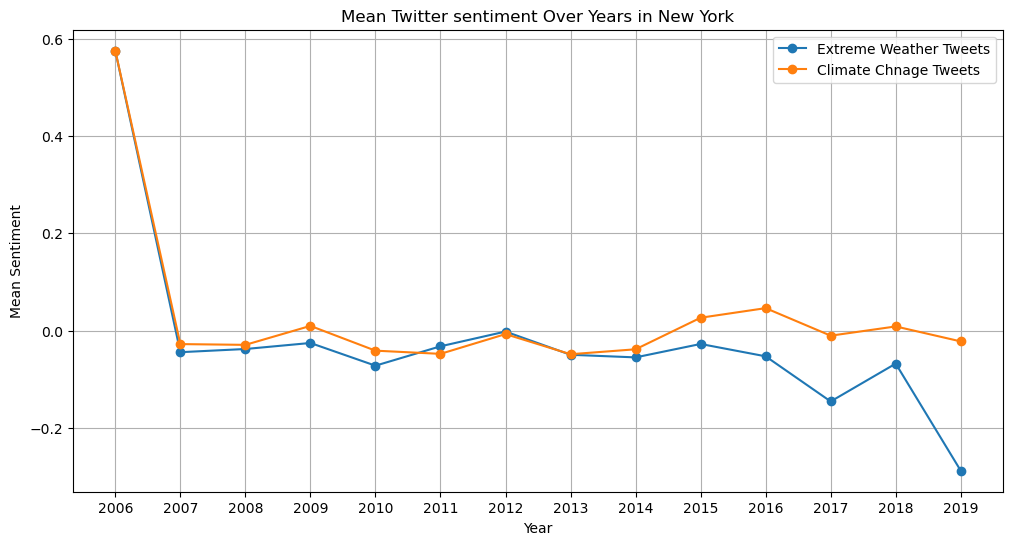

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(mean_sentiment_year_NY.index, mean_sentiment_year_NY.values, label='Extreme Weather Tweets', marker='o')
plt.plot(general_sentiment_year_NY.index, general_sentiment_year_NY.values, label='Climate Chnage Tweets', marker='o')

plt.title('Mean Twitter sentiment Over Years in New York')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.xticks(mean_sentiment_year_NY.index)

plt.show()

The plot shows that the general sentiment is neutral in the tweets about climate change. The trend for the topic extreme weather is similar but after 2015 the sentimenent gets more negative. 

In [64]:
General_sentiment_Gender_NY = new_york_df.groupby(new_york_df["gender"])["sentiment"].mean()
ExtremeW_sentiment_Gender_NY = new_york_df_weather.groupby(new_york_df_weather["gender"])["sentiment"].mean()

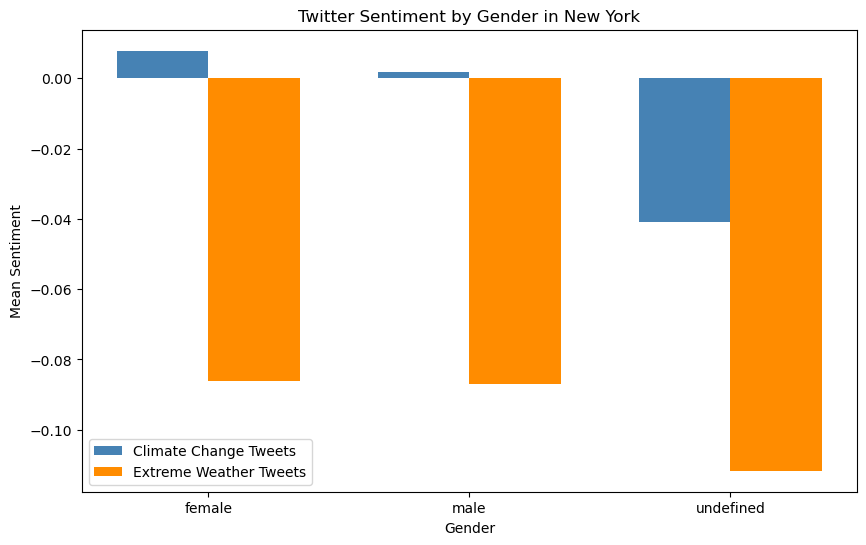

In [65]:
plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_Gender_NY))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_Gender_NY, width=bar_width, label='Climate Change Tweets', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_Gender_NY, width=bar_width, label='Extreme Weather Tweets', color='darkorange')

ax1.set_xlabel('Gender')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment by Gender in New York')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_Gender_NY.index)
ax1.legend()

plt.show()

The difference between gender is not present. Both male and female twitter users have a neutral sentiment on Climate change and slightly negative on extreme weather.

In [66]:
General_sentiment_stance_NY = new_york_df.groupby(new_york_df["stance"])["sentiment"].mean()
ExtremeW_sentiment_stance_NY = new_york_df_weather.groupby(new_york_df_weather["stance"])["sentiment"].mean()

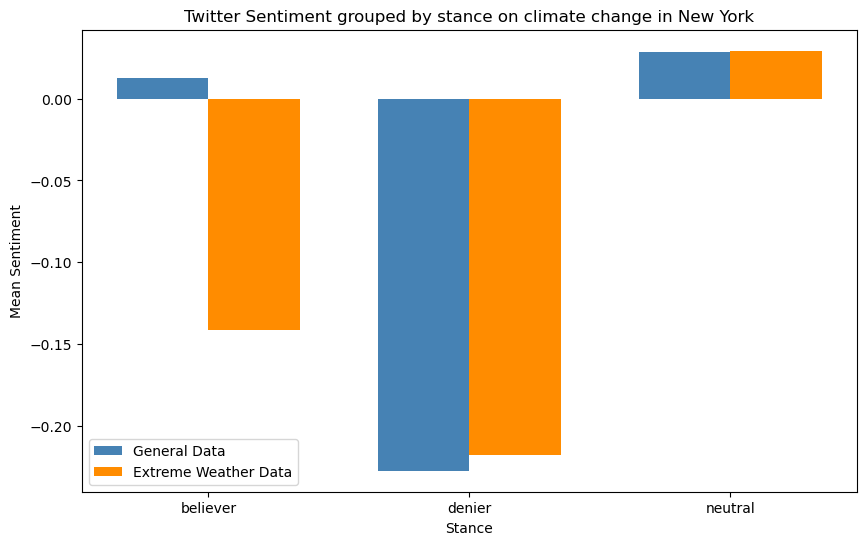

In [67]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_stance_NY))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_stance_NY, width=bar_width, label='General Data', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_stance_NY, width=bar_width, label='Extreme Weather Data', color='darkorange')

ax1.set_xlabel('Stance')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment grouped by stance on climate change in New York')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_stance_NY.index)
ax1.legend()

plt.show()

The plot shows that, in general, deniers exhibit more negative sentiment on Twitter regarding both climate change in general and extreme weather specifically. Believers are neutral on climate change but express significantly more negativity when it comes to extreme weather.

##### *Conclusion New York Twitter Analysis*

Based on the analysis, the general sentiment towards climate change on Twitter tends to be neutral, with a noticeable shift towards negativity regarding extreme weather, especially after 2015. This sentiment trend is consistent across both male and female users. Additionally, deniers tend to exhibit more negative sentiment overall, particularly towards climate change in general. Believers, while neutral on climate change, express significantly more negativity towards extreme weather events. This indicates a complex interplay between beliefs, attitudes, and reactions toward climate-related topics on social media platforms.

##### *6.2.2 Copenhagen Analysis*

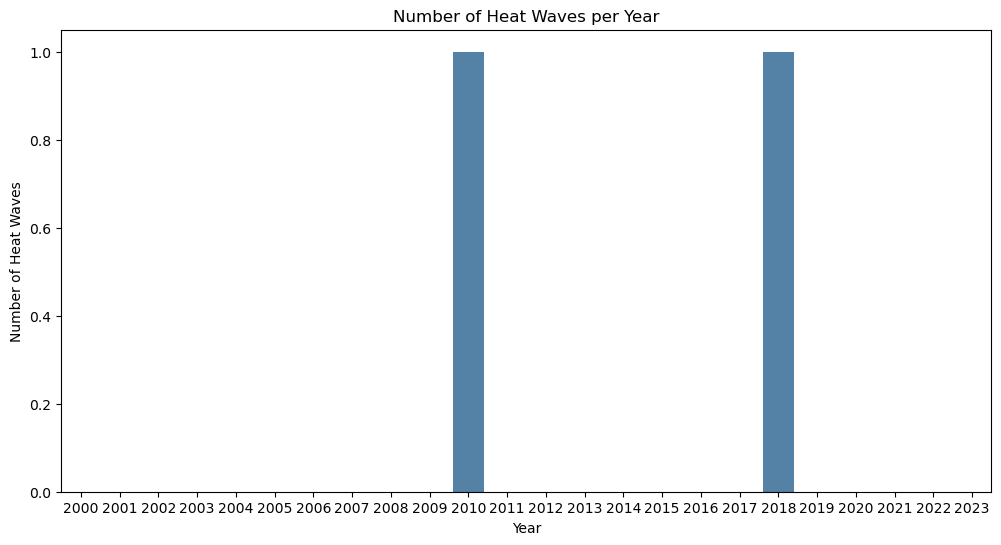

In [68]:
df_weather_CPH = pd.read_csv('Cph_2000-2023.csv')
df_weather_CPH['time'] = pd.to_datetime(df_weather_CPH['time'])
heatwave_data_CPH = []

for year in df_weather_CPH['time'].dt.year.unique():
    
    heatwave_num = heat_wave_counter(heat_wave_detector(df_weather_CPH, 28, 3, year, year))
    heatwave_data_CPH.append({'Year': year, 'Heat Waves': heatwave_num})
    
heatwave_data_CPH = pd.DataFrame(heatwave_data_CPH)

plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Heat Waves', data=heatwave_data_CPH, color='steelblue')
plt.title('Number of Heat Waves per Year')
plt.xlabel('Year')
plt.ylabel('Number of Heat Waves')
plt.show()

##### *Tweet analysis for Copenhagen*

In [69]:
mean_sentiment_per_day_CPH = copenhagen_df_weather.groupby("created_at")["sentiment"].mean()
mean_sentiment_per_day_CPH
copenhagen_df_weather['created_at'] = pd.to_datetime(copenhagen_df_weather['created_at'])
copenhagen_df['created_at'] = pd.to_datetime(copenhagen_df['created_at'])
mean_sentiment_year_CPH = copenhagen_df_weather.groupby(copenhagen_df_weather["created_at"].dt.year)['sentiment'].mean()
general_sentiment_year_CPH = copenhagen_df.groupby(copenhagen_df["created_at"].dt.year)["sentiment"].mean()

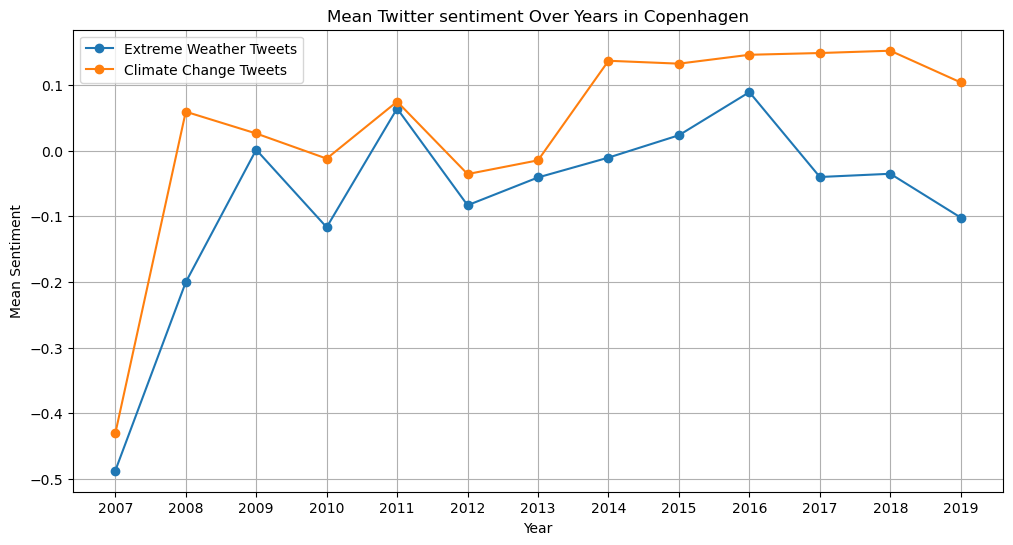

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(mean_sentiment_year_CPH.index, mean_sentiment_year_CPH.values, label='Extreme Weather Tweets', marker='o')
plt.plot(general_sentiment_year_CPH.index, general_sentiment_year_CPH.values, label='Climate Change Tweets', marker='o')

plt.title('Mean Twitter sentiment Over Years in Copenhagen')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.xticks(mean_sentiment_year_CPH.index)


plt.show()

The figure illustrates that, overall, individuals in Copenhagen express a neutral to slightly positive sentiment regarding climate change on Twitter. However, sentiments show a slight downturn concerning extreme weather occurrences post-2016, suggesting a growing concern or dissatisfaction, possibly due to the increased frequency of heatwaves.

In [71]:
General_sentiment_Gender_CPH = copenhagen_df.groupby(copenhagen_df["gender"])["sentiment"].mean()
ExtremeW_sentiment_Gender_CPH = copenhagen_df_weather.groupby(copenhagen_df_weather["gender"])["sentiment"].mean()

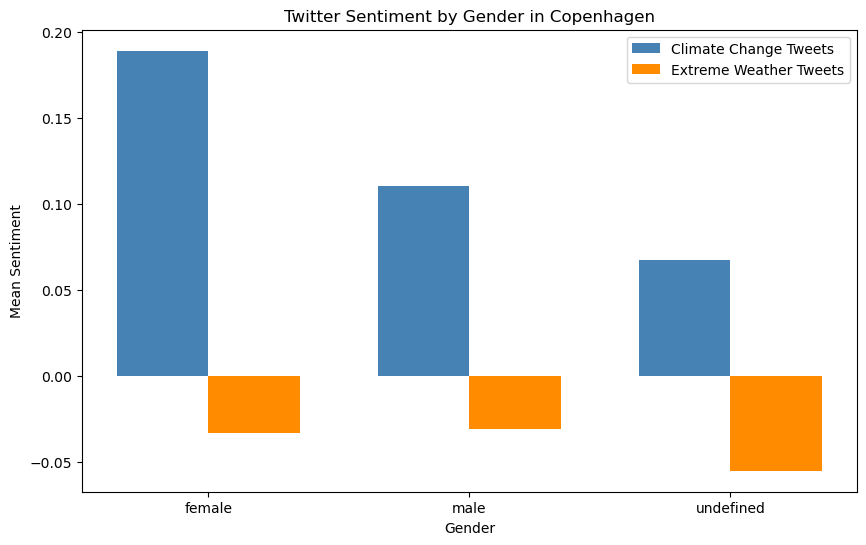

In [72]:
plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_Gender_NY))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_Gender_CPH, width=bar_width, label='Climate Change Tweets', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_Gender_CPH, width=bar_width, label='Extreme Weather Tweets', color='darkorange')

ax1.set_xlabel('Gender')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment by Gender in Copenhagen')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_Gender_CPH.index)
ax1.legend()

plt.show()

The figure reveals a notable contrast: female citizens of Copenhagen exhibit significantly more positivity in their tweets about climate change compared to male citizens. Interestingly, both male and female citizens display similar levels of negativity when discussing extreme weather events in their tweets.

In [73]:
General_sentiment_stance_CPH = copenhagen_df.groupby(copenhagen_df["stance"])["sentiment"].mean()
ExtremeW_sentiment_stance_CPH = copenhagen_df_weather.groupby(copenhagen_df_weather["stance"])["sentiment"].mean()

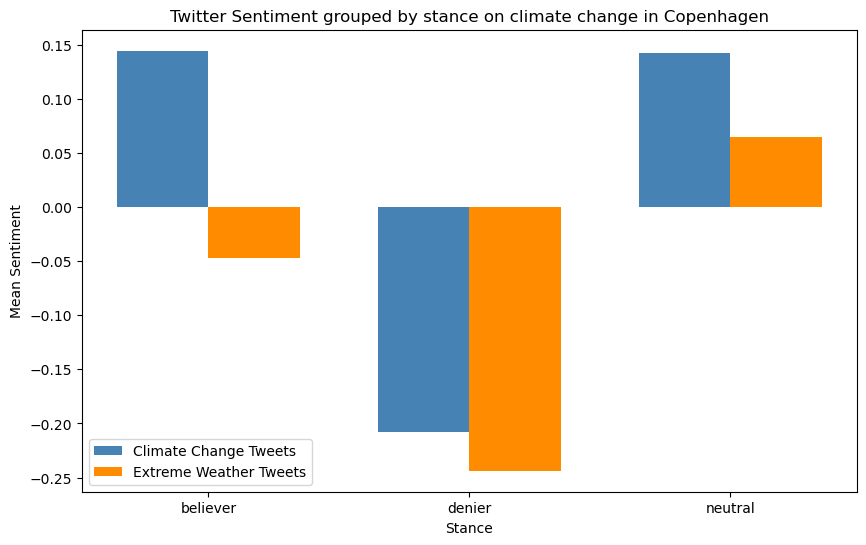

In [74]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_stance_CPH))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_stance_CPH, width=bar_width, label='Climate Change Tweets', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_stance_CPH, width=bar_width, label='Extreme Weather Tweets', color='darkorange')

ax1.set_xlabel('Stance')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment grouped by stance on climate change in Copenhagen')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_stance_CPH.index)
ax1.legend()

plt.show()

As depicted in the figure, individuals who deny climate change express markedly more negativity in their tweets compared to believers, who maintain a slightly positive sentiment in Copenhagen. Additionally, deniers exhibit a significantly higher level of negativity in their tweets about extreme weather compared to believers, who express only slight negativity on the topic.

##### *Conclusion Copenhagen Analysis*
The analysis of Twitter sentiment in Copenhagen reveals several key insights. Overall, sentiment regarding climate change tends to be neutral to slightly positive among the general populace. However, a noticeable shift occurs post-2016, indicating a slight downturn in sentiment, particularly concerning extreme weather events, potentially linked to the increasing prevalence of heatwaves.

A gender-based discrepancy is observed, with female citizens displaying notably more positivity in climate change-related tweets compared to male citizens. Both genders exhibit similar levels of negativity when discussing extreme weather events.

Contrasting sentiments are also observed between individuals who deny climate change and those who believe in it. Deniers express significantly more negativity in their tweets than believers, who maintain a slightly positive sentiment overall. This trend persists regarding extreme weather, with deniers showing markedly higher levels of negativity compared to believers, who express only slight negativity on the topic.

In summary, while Copenhagen residents generally express a neutral to slightly positive sentiment towards climate change on Twitter, notable variations exist based on gender and belief stance, with post-2016 concerns regarding extreme weather events and heatwaves becoming increasingly evident.

##### *6.2.3 Madrid Analysis*

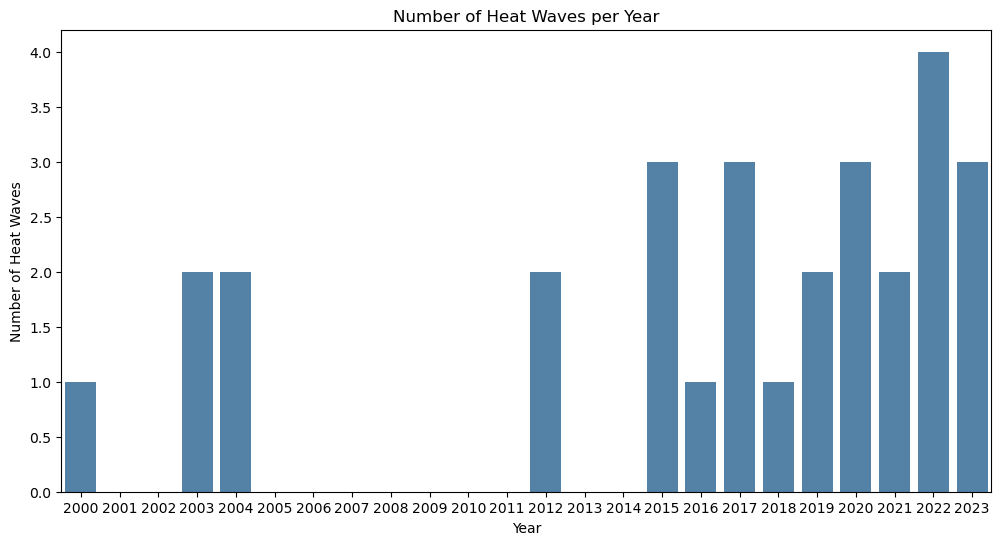

In [75]:
df_weather_MDR = pd.read_csv('madrid_2000-2023.csv')
df_weather_MDR['time'] = pd.to_datetime(df_weather_MDR['time'])
heatwave_data_MDR = []

for year in df_weather_MDR['time'].dt.year.unique():
    
    heatwave_num = heat_wave_counter(heat_wave_detector(df_weather_MDR, 36.3, 3, year, year))
    heatwave_data_MDR.append({'Year': year, 'Heat Waves': heatwave_num})
    
heatwave_data_MDR = pd.DataFrame(heatwave_data_MDR)

plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Heat Waves', data=heatwave_data_MDR, color='steelblue')
plt.title('Number of Heat Waves per Year')
plt.xlabel('Year')
plt.ylabel('Number of Heat Waves')
plt.show()

In [76]:
mdr_heatwaves = heat_wave_detector(df_weather_MDR, 36.3, 3, 2000, 2023)

print("Number of heat waves in CPH during the period 2000-2023:", heat_wave_counter(mdr_heatwaves))

Number of heat waves in CPH during the period 2000-2023: 29


##### *Tweet analysis for Madrid*

In [77]:
mean_sentiment_per_day_MDR = madrid_df_weather.groupby("created_at")["sentiment"].mean()
madrid_df_weather['created_at'] = pd.to_datetime(madrid_df_weather['created_at'])
madrid_df['created_at'] = pd.to_datetime(madrid_df['created_at'])
mean_sentiment_year_MDR = madrid_df_weather.groupby(madrid_df_weather["created_at"].dt.year)['sentiment'].mean()
general_sentiment_year_MDR = madrid_df.groupby(madrid_df["created_at"].dt.year)["sentiment"].mean()

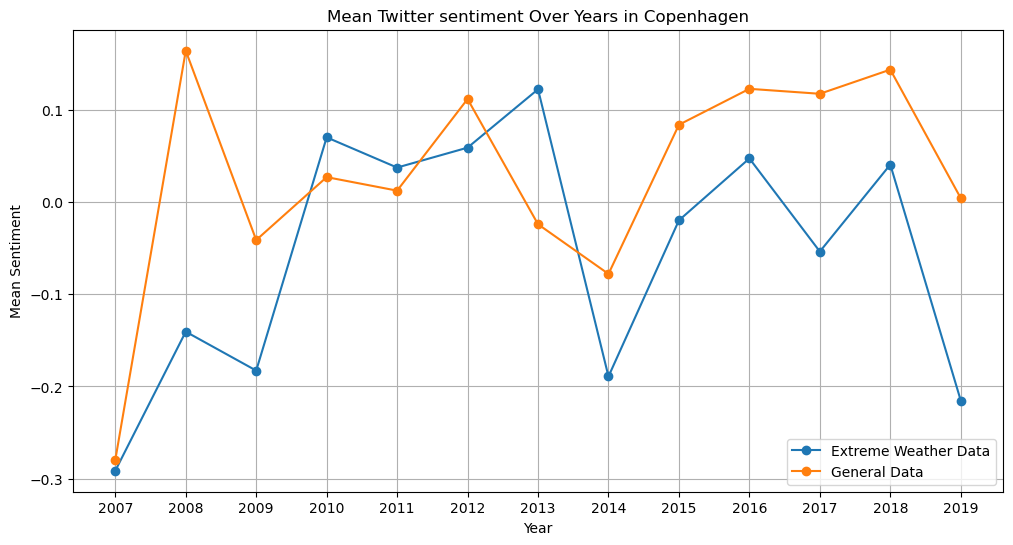

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(mean_sentiment_year_MDR.index, mean_sentiment_year_MDR.values, label='Extreme Weather Data', marker='o')
plt.plot(general_sentiment_year_MDR.index, general_sentiment_year_MDR.values, label='General Data', marker='o')

plt.title('Mean Twitter sentiment Over Years in Copenhagen')
plt.xlabel('Year')
plt.ylabel('Mean Sentiment')
plt.legend()
plt.grid(True)
plt.xticks(mean_sentiment_year_MDR.index)


plt.show()

The graphic above illustrates sentiment trends over the years. Notably, sentiments expressed in tweets about climate change and extreme weather exhibit a parallel pattern, showing no discernible differences. Overall, the prevailing stance across both categories remains largely neutral over time.

In [79]:
General_sentiment_Gender_MDR = madrid_df.groupby(madrid_df["gender"])["sentiment"].mean()
ExtremeW_sentiment_Gender_MDR = madrid_df_weather.groupby(madrid_df_weather["gender"])["sentiment"].mean()

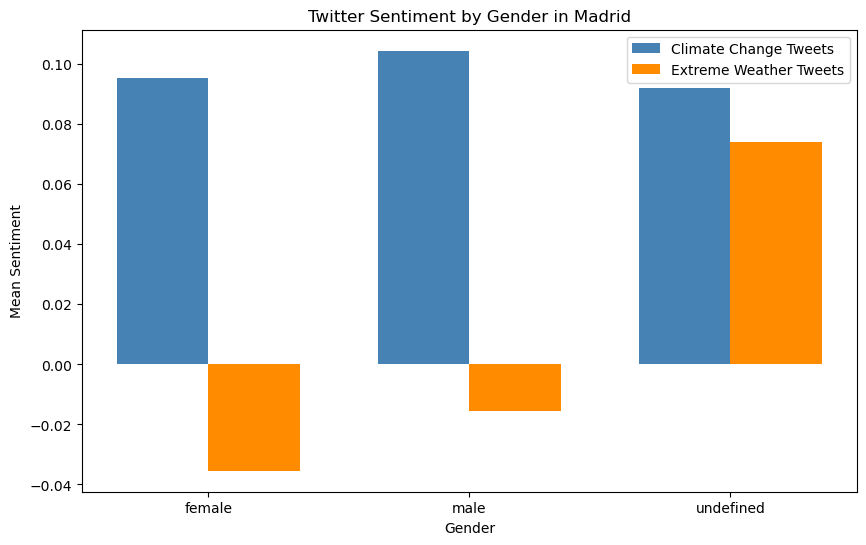

In [80]:
plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_Gender_MDR))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_Gender_MDR, width=bar_width, label='Climate Change Tweets', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_Gender_MDR, width=bar_width, label='Extreme Weather Tweets', color='darkorange')

ax1.set_xlabel('Gender')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment by Gender in Madrid')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_Gender_MDR.index)
ax1.legend()

plt.show()

The figure depicts that both male and female tweeters in Madrid generally express a positive sentiment when discussing climate change. However, when the topic shifts to extreme weather, their sentiments tend to hover around neutrality.

In [81]:
General_sentiment_stance_MDR = madrid_df.groupby(madrid_df["stance"])["sentiment"].mean()
ExtremeW_sentiment_stance_MDR = madrid_df_weather.groupby(madrid_df_weather["stance"])["sentiment"].mean()

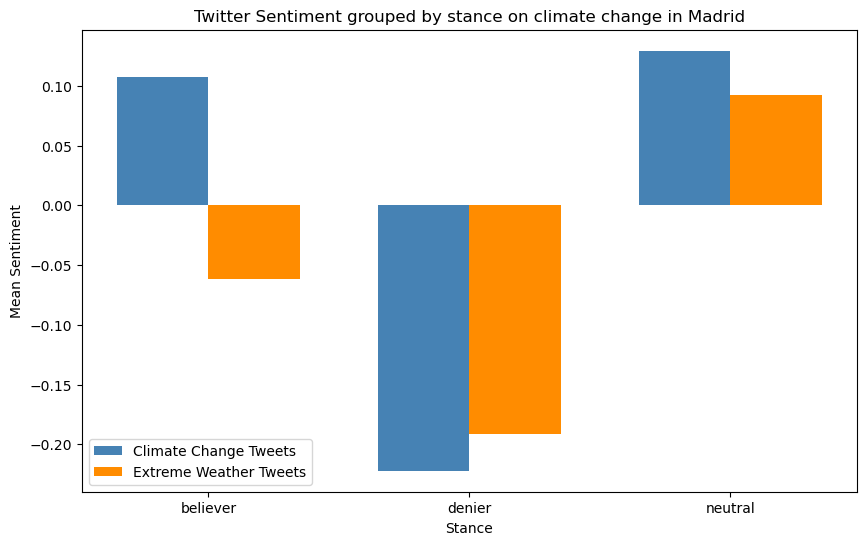

In [82]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_stance_MDR))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_stance_MDR, width=bar_width, label='Climate Change Tweets', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_stance_MDR, width=bar_width, label='Extreme Weather Tweets', color='darkorange')

ax1.set_xlabel('Stance')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment grouped by stance on climate change in Madrid')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_stance_MDR.index)
ax1.legend()

plt.show()

As depicted in the figure, individuals who deny climate change express markedly more negativity in their tweets compared to believers, who maintain a slightly positive sentiment in Madrid. Additionally, deniers exhibit a significantly higher level of negativity in their tweets about extreme weather compared to believers, who express only a slight negativity on the topic.

##### *Conclusion Madrid Analysis*

The analysis of sentiment across different topics and demographics on Twitter in Madrid provides several noteworthy conclusions.

Firstly, the graphical representation of sentiment trends reveals that tweets discussing climate change and extreme weather show a consistent parallel pattern over time. Despite fluctuations, there are no substantial discernible differences between the sentiments expressed in these categories, with an overall tendency towards neutrality.

Secondly, when examining gender-specific sentiment, both male and female tweeters in Madrid tend to convey a generally positive sentiment regarding climate change. However, when the conversation shifts towards extreme weather, sentiments from both genders tend to lean towards neutrality.

Lastly, there is a distinct contrast between individuals who deny climate change and those who believe in it. Deniers exhibit notably more negativity in their tweets compared to believers, who maintain a slightly positive sentiment overall. This difference persists even when discussing extreme weather, with deniers expressing significantly higher levels of negativity compared to believers, who express only slight negativity on the topic.

In summary, the sentiment analysis highlights the consistency of sentiment trends over time, the similarity in sentiment between male and female tweeters regarding climate change and extreme weather, and the significant contrast in sentiment between climate change deniers and believers in Madrid.

##### *6.2.4 Islamabad Analysis*

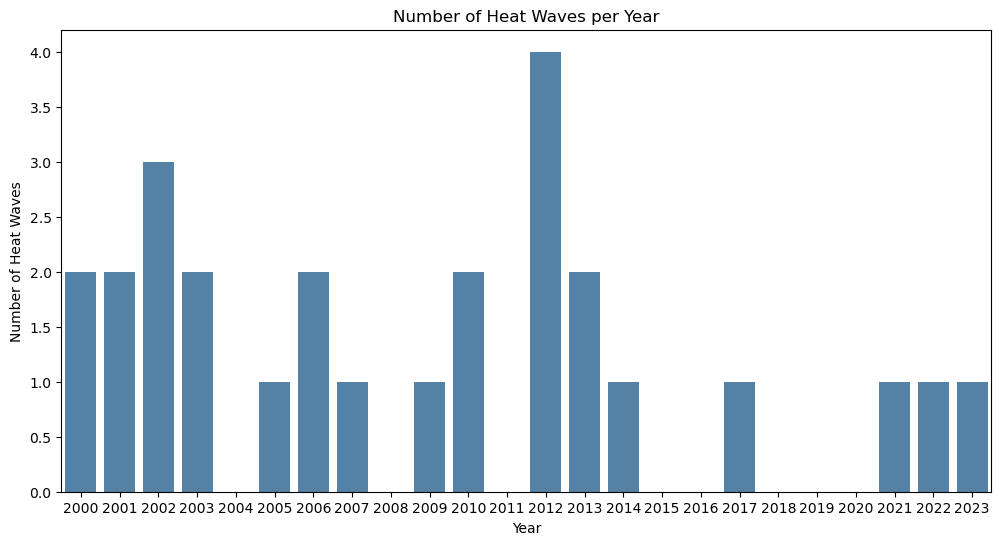

In [83]:
df_weather_isl = pd.read_csv('Islamabad_2000-2023.csv')
df_weather_isl['time'] = pd.to_datetime(df_weather_isl['time'])
heatwave_data_isl = []

for year in df_weather_isl['time'].dt.year.unique():
    
    heatwave_num = heat_wave_counter(heat_wave_detector(df_weather_isl, 40, 3, year, year))
    heatwave_data_isl.append({'Year': year, 'Heat Waves': heatwave_num})
    
heatwave_data_isl = pd.DataFrame(heatwave_data_isl)

plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Heat Waves', data=heatwave_data_isl, color='steelblue')
plt.title('Number of Heat Waves per Year')
plt.xlabel('Year')
plt.ylabel('Number of Heat Waves')
plt.show()

In [84]:
General_sentiment_Gender_ISM = islamabad_df.groupby(islamabad_df["gender"])["sentiment"].mean()
ExtremeW_sentiment_Gender_ISM = islamabad_df_weather.groupby(islamabad_df_weather["gender"])["sentiment"].mean()

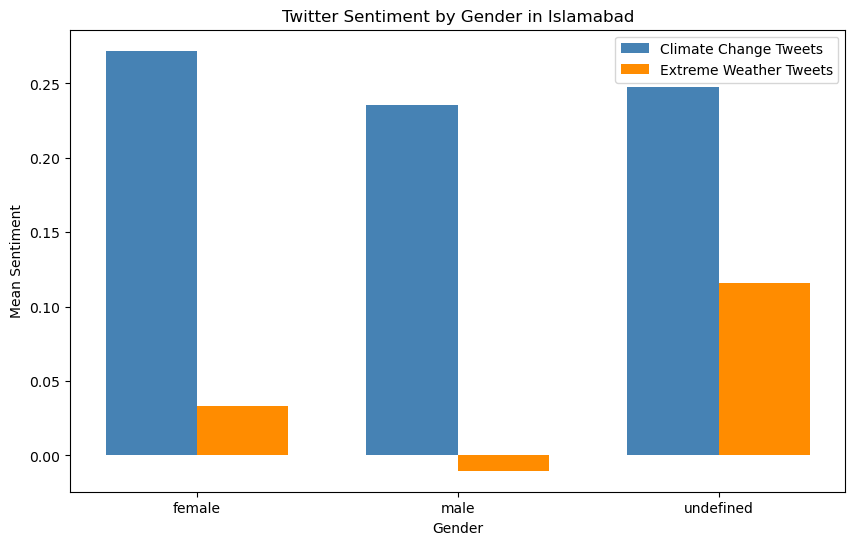

In [85]:
plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0])

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_Gender_ISM))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_Gender_ISM, width=bar_width, label='Climate Change Tweets', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_Gender_ISM, width=bar_width, label='Extreme Weather Tweets', color='darkorange')

ax1.set_xlabel('Gender')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment by Gender in Islamabad')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_Gender_ISM.index)
ax1.legend()

plt.show()

The plot shows that both genders have a much more positive sentiment in their tweets about climate change. On the topic extreme weather they are more or less neutral which really differs from the other cities.

In [86]:
General_sentiment_stance_ISM = islamabad_df.groupby(islamabad_df["stance"])["sentiment"].mean()
ExtremeW_sentiment_stance_ISM = islamabad_df_weather.groupby(islamabad_df_weather["stance"])["sentiment"].mean()

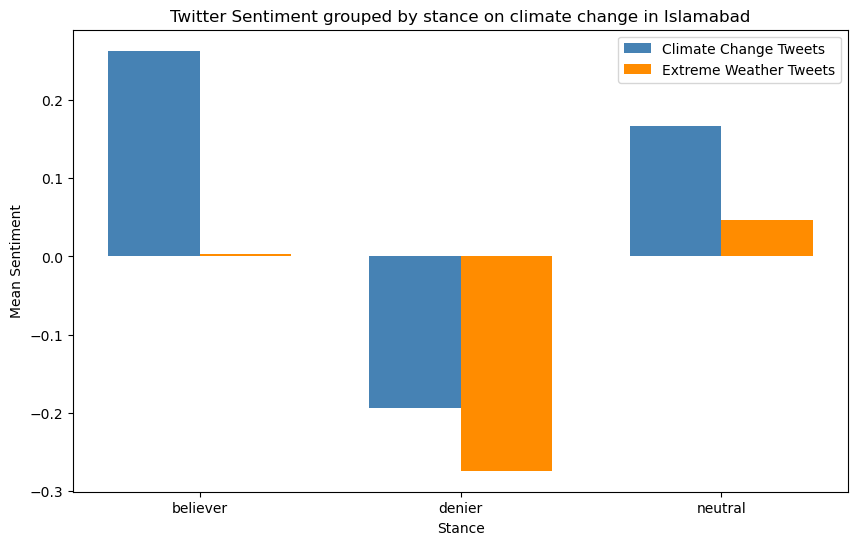

In [87]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
bar_positions1 = range(len(General_sentiment_stance_ISM))
bar_positions2 = [pos + bar_width for pos in bar_positions1]

ax1.bar(bar_positions1, General_sentiment_stance_ISM, width=bar_width, label='Climate Change Tweets', color='steelblue')
ax1.bar(bar_positions2, ExtremeW_sentiment_stance_ISM, width=bar_width, label='Extreme Weather Tweets', color='darkorange')

ax1.set_xlabel('Stance')
ax1.set_ylabel('Mean Sentiment')
ax1.set_title('Twitter Sentiment grouped by stance on climate change in Islamabad')
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions1])
ax1.set_xticklabels(General_sentiment_stance_ISM.index)
ax1.legend()

plt.show()

Also, it can be observed that deniers are generally more negative on Twitter regarding both climate change and extreme weather, while believers tend to be more positive or neutral on these topics.

##### *Conclusion Islamabad Twitter Analysis*
In general, people in Islamabad are much less negative on Twitter about climate change and extreme weather. This may be due to the population being more accustomed to heat and the city’s infrastructure being better equipped to handle high temperatures. Additionally, in Islamabad, no gender differences are observed in sentiment, and climate change deniers are much more negative than believers, consistent with patterns seen in other cities.

# 7. Heat wave effect on sentiment
This section analyzes daily sentiment during heatwave periods. The daily sentiment for each month is plotted alongside indications of heatwaves, allowing for examination of the effects of heatwaves on Twitter sentiment. Two of the longest heatwaves are analyzed for each city. Islamabad and Madrid are not analyzed due to insufficient daily data, as not all days contain tweets suitable for analysis.

#### *New York*
The two heatwaves are chosen, one lasted 3 days (2010-07-03 to 2010-07-06) and the other 4 days (2016-07-21 to 2016-07-25).

In [88]:
start_date = '2010-07-01'
end_date = '2010-08-01'
filtered_data = new_york_df_weather[(new_york_df['created_at'] >= start_date) & (new_york_df_weather['created_at'] <= end_date)]
filtered_data['date'] = pd.to_datetime(filtered_data['created_at']).dt.date
daily_sentiment = filtered_data.groupby('date')['sentiment'].mean()

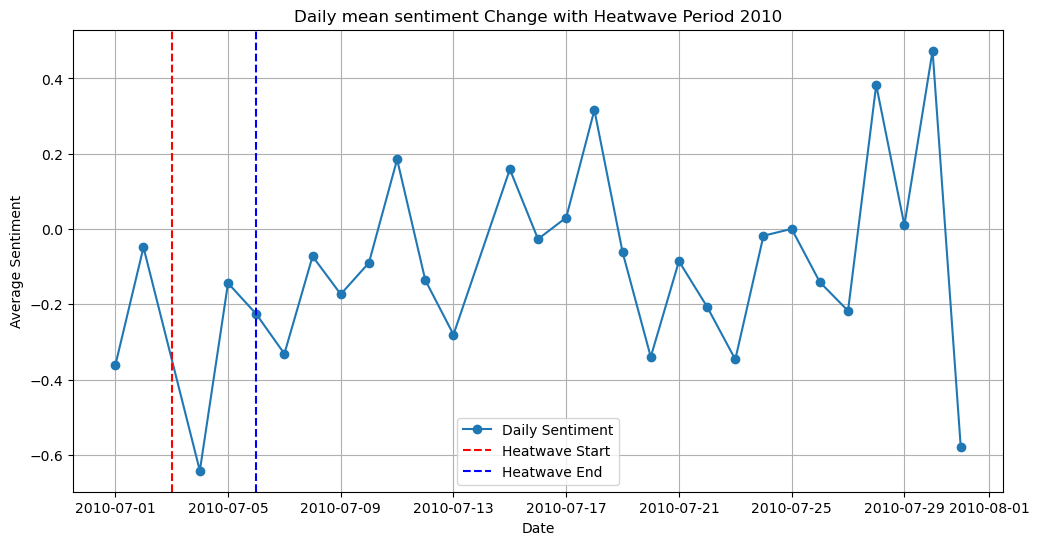

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o', linestyle='-', label='Daily Sentiment')

heatwave_periods = [ ['2010-07-03', '2010-07-06']]
for period in heatwave_periods:
    start_date, end_date = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in period]
    plt.axvline(x=start_date, color='r', linestyle='--', label='Heatwave Start')
    plt.axvline(x=end_date, color='b', linestyle='--', label='Heatwave End')

plt.legend() 
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Daily mean sentiment Change with Heatwave Period 2010')
plt.grid(True)
plt.show()

In [90]:
start_date = '2016-07-01'
end_date = '2016-08-01'
filtered_data = new_york_df_weather[(new_york_df['created_at'] >= start_date) & (new_york_df_weather['created_at'] <= end_date)]
filtered_data['date'] = pd.to_datetime(filtered_data['created_at']).dt.date
daily_sentiment = filtered_data.groupby('date')['sentiment'].mean()

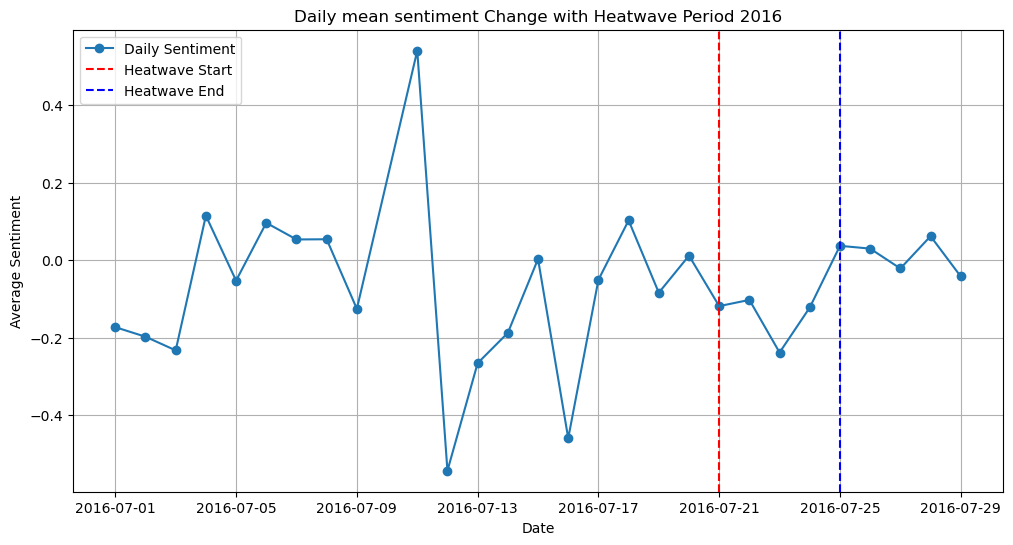

In [91]:
plt.figure(figsize=(12, 6))  
plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o', linestyle='-', label='Daily Sentiment')

heatwave_periods = [ ['2016-07-21', '2016-07-25']]
for period in heatwave_periods:
    start_date, end_date = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in period]
    plt.axvline(x=start_date, color='r', linestyle='--', label='Heatwave Start')
    plt.axvline(x=end_date, color='b', linestyle='--', label='Heatwave End')

plt.legend() 
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Daily mean sentiment Change with Heatwave Period 2016')
plt.grid(True)
plt.show()

During the heatwave of 2010, a dip in sentiment is observed, with sentiment becoming noticeably negative on Twitter in the region. The heatwave of 2016 also shows a clear drop in sentiment, with people expressing more negativity on Twitter during the event. However, considering the general trends for both heatwaves, these changes do not appear to be unusual.

#### *Copenhagen*
The one heatwave in Copenhagen is in 2010 and is 3 days long. This is the only of the two heatwaves with twitter data.

In [92]:
start_date = '2010-06-20'
end_date = '2010-07-20'
filtered_data = copenhagen_df_weather[(copenhagen_df_weather['created_at'] >= start_date) & (copenhagen_df_weather['created_at'] <= end_date)]
filtered_data['date'] = pd.to_datetime(filtered_data['created_at']).dt.date
daily_sentiment = filtered_data.groupby('date')['sentiment'].mean()

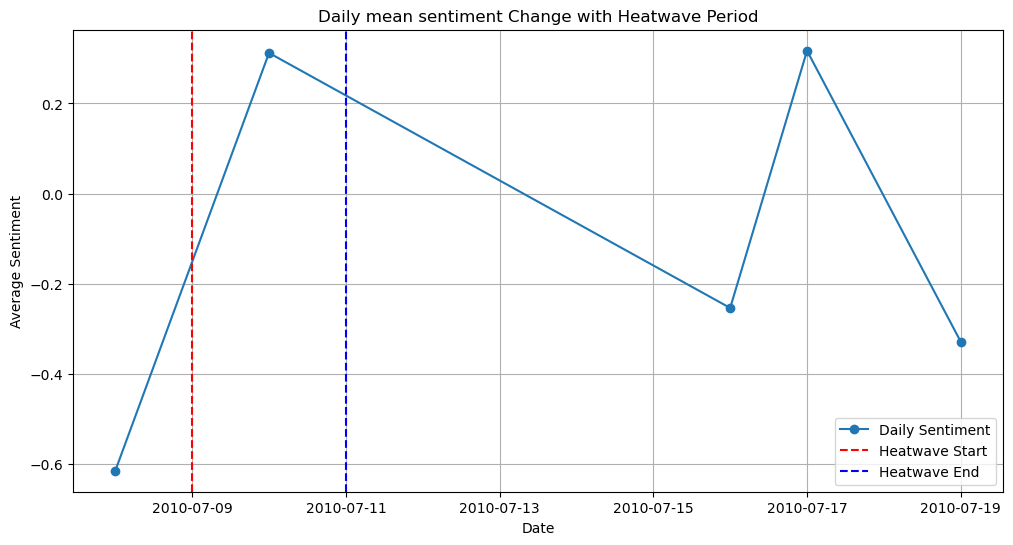

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values, marker='o', linestyle='-', label='Daily Sentiment')

heatwave_periods = [ ['2010-07-09', '2010-07-11']]
for period in heatwave_periods:
    start_date, end_date = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in period]
    plt.axvline(x=start_date, color='r', linestyle='--', label='Heatwave Start')
    plt.axvline(x=end_date, color='b', linestyle='--', label='Heatwave End')

plt.legend() 
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.title('Daily mean sentiment Change with Heatwave Period')
plt.grid(True)
plt.show()

The graph illustrates a significant shift in sentiment from strongly negative to slightly positive. This change may be unusual, but can be explained. In Copenhagen, as in other Nordic countries, the climate tends to be cold. Therefore, when temperatures rise above 28°C, it can be considered as a heatwave relative to the local climate and might have contributed in people's mood during these 3 days.


# 8. Conclusions
#### *Conclusions Prediction Model*
This study examined the dynamics of heatwaves in four distinct cities—Madrid, New York, Copenhagen, and Islamabad—and identified key insights into the relationships between temperature variables and maximum temperature predictions.

Across the analyzed period, maximum and minimum temperatures showed fluctuating yet overall stable trends. Although variations occurred, no consistent long-term increase in temperature was detected in any of the cities. Correlation analysis revealed strong positive associations between maximum and minimum temperatures across all locations, indicating a close linkage between these variables.

A notable finding was the increasing winter temperature trend observed in Copenhagen and Islamabad, highlighting growing concerns regarding seasonal shifts influenced by climate change.

Additionally, weak correlations between maximum temperature and precipitation indicated that rainfall had limited influence on temperature variations in the studied areas.

Both ARIMA and XGBoost models were applied to predict future maximum temperatures. ARIMA models produced reasonable forecasts, and predictive accuracy increased when additional variables—such as minimum temperature—were included. XGBoost also delivered strong results, particularly in capturing nonlinear relationships and enhancing prediction quality.
Despite these improvements, predicting future temperatures remains challenging due to limited data availability and the complexity of underlying climate patterns. Continued refinement of predictive approaches is necessary to gain more robust insights into temperature dynamics.

#### *Conclusions Sentiment Analysis*
The analysis of tweets indicates that extreme weather events, including heatwaves, are widely discussed globally. Overall sentiment tends to lean slightly negative, reflecting public concern about the impacts of such events. No significant gender-based differences were found in tweet volume or beliefs regarding climate change. Over time, the ratio of climate change deniers to believers has decreased, though it is unclear whether this is due to fewer deniers, more believers, or both. New York generated significantly more climate-related tweets than the other cities, although this may be influenced by data availability.

An examination of articles and social media sentiment in New York showed that published reports on heatwaves generally adopt a neutral to slightly negative tone, reflecting balanced and objective perspectives on climate-related concerns. Twitter sentiment remains largely neutral overall, though negativity surrounding extreme weather events has increased notably after 2015. This pattern is consistent among both male and female users. Climate change deniers consistently express more negative sentiment—particularly toward climate change—while believers tend to maintain neutral views on climate change and express more negativity specifically toward extreme weather events.

In Copenhagen, Twitter sentiment is generally neutral to slightly positive regarding climate change. However, sentiment has declined somewhat since 2016, especially in discussions related to extreme weather. Female users express slightly more positive sentiment toward climate change than male users, though both genders show similar negativity when describing extreme weather events. Clear differences also emerge between deniers and believers, with deniers expressing more negative sentiment overall and believers maintaining slightly positive attitudes even when addressing challenging topics.

In Madrid, sentiment trends regarding climate change and extreme weather remain generally neutral over time. Both male and female users express positive sentiment when discussing climate change but adopt a more neutral tone when referring to extreme weather. Climate change deniers show more negative sentiment overall—especially concerning climate change and extreme weather—while believers maintain slightly positive sentiment across both topics.

In Islamabad, sentiment toward climate change and extreme weather is less negative than in the other cities. This may be linked to greater familiarity with high temperatures and stronger infrastructure for heat management. No meaningful gender-based sentiment differences were observed. As in other cities, climate change deniers express more negative sentiment compared to believers.

When comparing the effect of heatwaves on Twitter sentiment in New York and Copenhagen, distinct patterns appear. In New York, heatwaves in 2010 and 2016 corresponded with noticeable declines in sentiment, though these dips aligned with broader long-term patterns. In contrast, Copenhagen showed a shift from strongly negative to slightly positive sentiment during heatwaves. This response may reflect the relative rarity of high temperatures in Nordic regions, where temperatures above 28°C are considered unusually high and may significantly influence public mood.





#### *Business Case*
The findings of this study provide valuable insights for urban planners and policymakers. The results can inform strategies aimed at enhancing city infrastructure and improving resilience to heatwaves, particularly in regions where extreme heat is frequently experienced and viewed negatively. Understanding how extreme temperatures influence public sentiment highlights the importance of developing urban environments that remain livable during heat events and preparing for more frequent and intense heatwaves in the future.

# 9. Sources

[1]Effrosynidis, D., Sylaïos, G., & Arampatzis, A. (2022). Exploring climate change on Twitter using seven aspects: Stance, sentiment, aggressiveness, temperature, gender, topics, and disasters. PloS One, 17(9), e0274213. https://doi.org/10.1371/journal.pone.0274213.

[2]Effrosynidis, D., Karasakalidis, A. I., Sylaïos, G., & Arampatzis, A. (2022). The climate change Twitter dataset. Expert Systems With Applications, 204, 117541. https://doi.org/10.1016/j.eswa.2022.117541

https://www.kaggle.com/datasets/deffro/the-climate-change-twitter-dataset?resource=download&fbclid=IwZXh0bgNhZW0CMTAAAR230eZb2PV1bRQiow4vAS1XUSUm4uZEI1jyg1FqSO_KHdTTfCoSwA0H_rE_aem_AX9EJ3BvndZNiz3mIeoEf61hGfox-BLNNLEfJKmBplvaNJ8mEt6bwTgi2XPDfGbX5YbI4Of4paXLKypMGcTNr0ce

https://prometeosevilla.com/en/heat-waves/

https://www.weather.gov/okx/excessiveheat

https://en.klimatilpasning.dk/knowledge/climate/denmarksfutureclimate/changes-in-temperature/

https://developer.nytimes.com/docs/articlesearch-product/1/overview

https://open-meteo.com/